# Clickstream data propensity model 

In [1]:
import pandas as pd
import numpy as np 

## Investigation of structure, quality and content

1. **Structure investigation**: Exploring the general shape of the dataset, as well as the data types of data features.
2. **Quality investigation**: Get a feeling for the general quality of the dataset, with regards to duplicates, missing values and unwanted entries.
3. **Content investigation**: Once the structure and quality of the dataset is understood, we can go ahead and perform a more in-depth exploration on the features values and look at how different features relate to each other.

But first we need to find an interesting dataset. Let's go ahead and load the "DVMWare Data"

In [2]:
df_train=pd.read_csv('IMB_621_VMW_SERVER_CASE_DATA.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (444,445,446,447,450,451,452,453,455,456,457,458,461,463,464,465,466,474,475,476,477,480,481,482,483,485,486,487,488,491,493,494,495,496,785) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_val=pd.read_csv('VMWare Validation Dataset.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (444,445,446,447,450,451,452,453,455,456,458,461,463,464,465,468,470,474,475,476,477,480,481,482,483,485,486,488,491,493,494,495,498,500,770) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Structure Investigation

Before looking at the content of our feature matrix $X$, let's first look at the general structure of the dataset. For example, how many columns and rows does the dataset have?

In [4]:
df_train.shape,df_val.shape

((100000, 958), (49999, 958))

So we know that this dataset has 100000 samples and 958 features. And how many different data types do these 958 features contain?

In [5]:
pd.value_counts(df_train.dtypes)

float64    590
int64      268
object     100
dtype: int64

Looking at the data, we now know there are partially encoded columns like Board_CBSE, Board_ICSE of Board_SSC categorical variable also Degree_Engg from the Course_Degree categorical variable, missing out proper encoding of all the category types of a feature. Which we need to drop and encode them with one hot encoding correctly. 

</t>Also there are Encoded columns for gender and placement with Gender-B and Placement-B, of which the categorical features can be dropped.

## 1.1. Structure of non-numerical features

Data types can be numerical and non-numerical. First, let's take a closer look at the **non-numerical** entries.

In [6]:
# Display non-numerical features
df_train.select_dtypes(exclude="number").head()

flag db_industry       db_city                db_companyname db_country  \
0    t     Unknown    Stadthagen                    Unitymedia         DE   
1    t     Unknown       Kimitsu              FreeBit Co.,Ltd.         JP   
2    t     Unknown  Kuala Lumpur  Tmnet, Telekom Malaysia Bhd.         MY   
3    t     Unknown    Valmadrera                Telecom Italia         IT   
4    t     Unknown       Cardiff                           NaN         GB   

  db_employeerange db_accountwatch  db_audience db_subindustry  \
0              NaN             NaN  Residential            NaN   
1              NaN             NaN          SMB            NaN   
2              NaN             NaN         SOHO            NaN   
3              NaN             NaN  Residential            NaN   
4              NaN             NaN  Residential            NaN   

  prodA_launch_date  ... idc_verticals citdb_ent_it_emple citdb_ent_server  \
0          1/1/2008  ...       Unknown                NaN          Unknown   
1          1/1/2008  ...       Unknown                NaN          Unknown   
2          1/1/2008  ...       Unknown                NaN          Unknown   
3          1/1/2008  ...         Other                NaN          Unknown   
4          1/1/2008  ...      Services                NaN          Unknown   

  citdb_ent_it_budget citdb_ent_hardware_budget  load_timestamp  \
0             Unknown                       NaN  6/23/2016 5:00   
1             Unknown                       NaN  6/23/2016 5:00   
2             Unknown                       NaN  6/23/2016 5:00   
3             Unknown                       NaN  6/23/2016 5:00   
4             Unknown                       NaN  6/23/2016 5:00   

  hyperthreading_active_flag hv_replay_capable_flag record_type  \
0                          Y                      Y     Unknown   
1                          Y                      Y     Unknown   
2                          Y                      Y     Unknown   
3                        NaN                    NaN      PERSON   
4                        NaN                    NaN      PERSON   

  prodV_booking_pct  
0               0.5  
1               0.5  
2                 0  
3                 0  
4                 0  

[5 rows x 100 columns]

Using the `.describe()` function we can also investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present.

In [7]:
df_train.describe(exclude="number")

flag db_industry db_city db_companyname db_country db_employeerange  \
count   100000      100000   75493          59703      82224            21070   
unique       1          33   12143          18352        175                6   
top          t     Unknown   Tokyo  Comcast Cable         US       Very Small   
freq    100000       76982    2684           3000      39408             9397   

            db_accountwatch  db_audience         db_subindustry  \
count                   845        85948                  23018   
unique                  348          122                    170   
top     null:null:null:null  Residential  Software Applications   
freq                    295        42813                   2359   

       prodA_launch_date  ... idc_verticals citdb_ent_it_emple  \
count             100000  ...        100000               5606   
unique                 1  ...            14                  8   
top             1/1/2008  ...       Unknown               <250   
freq              100000  ...         61883               3551   

       citdb_ent_server citdb_ent_it_budget citdb_ent_hardware_budget  \
count            100000              100000                      5606   
unique                8                   8                         7   
top             Unknown             Unknown               <$5 million   
freq              94398               94398                      4270   

        load_timestamp hyperthreading_active_flag hv_replay_capable_flag  \
count           100000                      61707                  61707   
unique               1                          2                      2   
top     6/23/2016 5:00                          Y                      Y   
freq            100000                      61484                  61654   

       record_type prodV_booking_pct  
count       100000           97421.0  
unique           3            9315.0  
top        Unknown               0.0  
freq         60802           68746.0  

[4 rows x 100 columns]

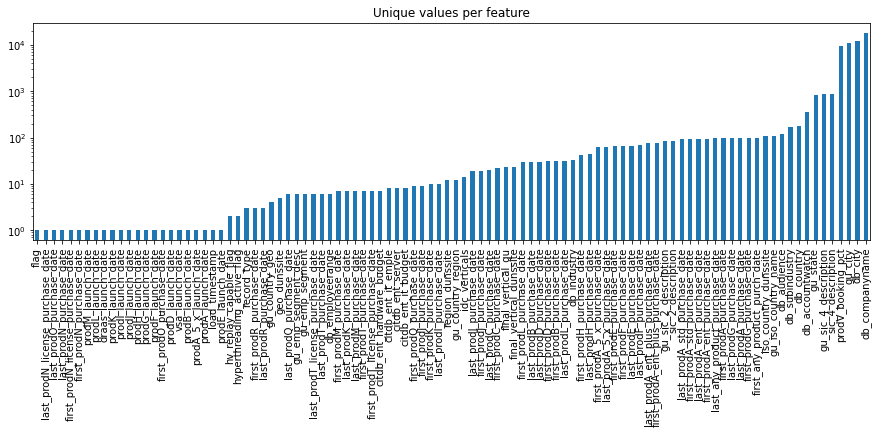

In [20]:
# For each numerical feature compute number of unique entries
unique_values = df_train.select_dtypes(
  exclude="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

## 1.2. Structure of numerical features

Next, let's take a closer look at the numerical features. More precisely, let's investigate how many unique values each of these feature has. This process will give us some insights about the number of **binary** (2 unique values), **ordinal** (3 to ~10 unique values) and **continuous** (more than 10 unique values) features in the dataset.

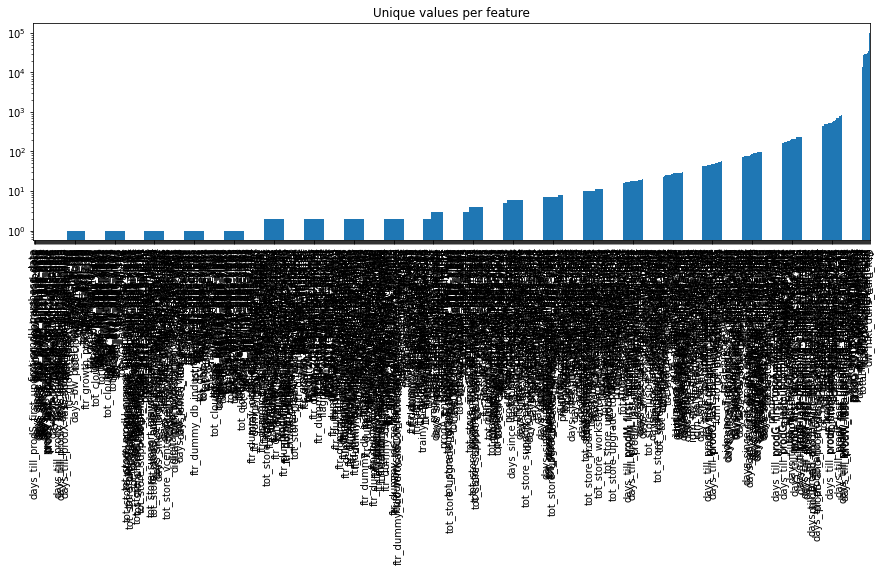

In [22]:
# For each numerical feature compute number of unique entries
unique_values = df_train.select_dtypes(
  include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

## 1.3. Conclusion of structure investigation

At the end of this first investigation, we have a better understanding of the general structure of our dataset. Number of samples and features, what kind of data type each feature has, and how many of them are binary, ordinal, categorical or continuous. 

# 2. Quality Investigation

Before focusing on the actual content stored in these features, let's first take a look at the general quality of the dataset. The goal is to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries or recording errors.

But first let us find our Y (Response variable) 

In [8]:
df_train.filter(regex='workstation|Workstation').columns

Index(['tot_store_workstation_pro_product_page_views',
       'tot_store_workstation_player_product_page_views',
       'tot_store_upgrade_to_workstation_pro_page_views',
       'tot_store_upgrade_to_workstation_player_page_views',
       'tot_store_support_pis_workstation_pro_page_views',
       'tot_store_support_pis_workstation_player_page_views',
       'num_workstation_campaign_responses',
       'digital_num_workstation_webcast_responses',
       'num_workstation_seminar_responses',
       'digital_workstation_paid_search_responses',
       'digital_workstation_online_responses',
       'digital_workstation_eval_responses', 'num_workstation_responses',
       'num_workstation_campaign_network_role_responses',
       'trainy_period_workstation_purchase_flag'],
      dtype='object')

In [9]:
df_train.filter(regex='Purchase|purchase').columns

Index(['purchase_events', 'first_prodA_purchase_date',
       'first_prodA_5_x_purchase_date', 'first_prodB_purchase_date',
       'first_prodC_purchase_date', 'first_prodD_purchase_date',
       'first_prodE_purchase_date', 'first_prodF_purchase_date',
       'first_prodG_purchase_date', 'first_prodH_purchase_date',
       ...
       'days_since_first_prodA_ent_plus_purchase_date',
       'days_since_first_prodU_purchase_date',
       'days_since_last_prodT_purchase_date',
       'days_since_last_prodT_license_purchase_date',
       'days_since_last_prodN_license_purchase_date',
       'days_since_last_prodA_std_purchase_date',
       'days_since_last_prodA_ent_purchase_date',
       'days_since_last_prodA_ent_plus_purchase_date',
       'days_since_last_prodU_purchase_date',
       'trainy_period_workstation_purchase_flag'],
      dtype='object', length=121)

We have trainy_period_workstation_purchase_flag which sounds like the variable that is encoded with {1,0}, with 0 as not_purchased during the period and 1 as purchased workstation during the period

In [11]:
df_train.trainy_period_workstation_purchase_flag.value_counts(normalize=True)*100

0    96.5
1     3.5
Name: trainy_period_workstation_purchase_flag, dtype: float64

only 3.5% of purchases of workstation in the data

**The Dependant variable for our prediction will be**

In [5]:
response_variable ='trainy_period_workstation_purchase_flag'

From the above query we can observe no missing records in the response variable 

In [13]:
print(f'The Class imbalance ratio is : {df_train.trainy_period_workstation_purchase_flag.value_counts().max()/df_train.trainy_period_workstation_purchase_flag.value_counts().min()}')

The Class imbalance ratio is : 27.571428571428573


<div class="alert alert-block alert-danger" >
The **High-Imbalance ratio** which is way greater than 4 is a clear indicator of applying imbalance remedy to build correct model. 

## 2.1. Duplicates

Duplicates are entries that represent the same sample point multiple times. For example, if a measurement was registered twice by two different people. Detecting such duplicates is not always easy, as each dataset might have a unique identifier (e.g. an index number or recording time that is unique to each new sample) which you might want to ignore first.

In [5]:
# Check number of duplicates while ignoring the dependant feature
n_duplicates = df_train.drop(labels=[response_variable], axis=1).duplicated().sum()
print(f"We have {n_duplicates} duplicates in the database.")

#  Extract column names of all features, except 'Placement_B'
columns_to_consider = df_train.drop(labels=[response_variable], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
df_X = df_train.drop_duplicates(subset=columns_to_consider)
df_X.shape



We have 0 duplicates in the database.


(100000, 958)

## 2.2. Missing values

Another quality issue worth to investigate are missing values. Having some missing values is normal. What we want to identify at this stage are big holes in the dataset, i.e. samples or features with a lot of missing values.

### 2.2.1. Dropping colums which doesnt have 80% of the records

To look at number of missing values per sample we have multiple options. The most straight forward one is to simply visualize the output of `df_X.isna()`, with something like this:

In [6]:
# Atleast 80% rows per features
row_threshold = 0.8
num_rows = np.ceil(df_train.shape[0]*row_threshold)
num_rows
df_train.dropna(thresh=num_rows, axis=1,inplace=True)

In [7]:
df_train.shape

(100000, 476)

after dropping columns with a threshold of 75% of rows to be filled in the feature, now we have 476 features we can analyse on.

In [8]:
'''
Applying Threshold -- Need to have atleast this number 
thresh --> Require that many non-NA values.
'''
# Atleast 75% features per row
col_threshold = 1
num_cols = np.ceil(df_train.shape[1]*col_threshold)
num_cols
df_train.dropna(thresh=num_cols,inplace=True)

In [9]:
df_train.shape

(77493, 476)

In [10]:
final_features = df_train.columns.to_list()

In [11]:
df_val=df_val[final_features]

In [12]:
df_val.shape

(49999, 476)

In [13]:
'''
Applying Threshold -- Need to have atleast this number 
thresh --> Require that many non-NA values.
'''

# Atleast 75% features per row
col_threshold = 1
num_cols = np.ceil(df_val.shape[1]*col_threshold)
num_cols
df_val.dropna(thresh=num_cols,inplace=True)

In [14]:
df_val.shape

(37850, 476)

we choose to drop any row with missing value and finally we have 77493 records with 476 features

In [16]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [17]:
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values

Your selected dataframe has 476 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [18]:
### run from this after dropping missing value columns

In [16]:
#df_train['prodV_booking_pct']=df_train['prodV_booking_pct'].fillna(-1) 
df_train['prodV_booking_pct']=df_train['prodV_booking_pct'].replace('#NAME?',np.nan)
df_train['prodV_booking_pct']=df_train['prodV_booking_pct'].apply(lambda x: x.astype(float) if x==str else x)
df_train['prodV_booking_pct']=df_train[['prodV_booking_pct']].astype(float)

In [17]:
#df_val['prodV_booking_pct']=df_val['prodV_booking_pct'].fillna(-1) 
df_val.loc[:,'prodV_booking_pct']=df_val.loc[:,'prodV_booking_pct'].replace('#NAME?',np.nan)
df_val.loc[:,'prodV_booking_pct']=df_val.loc[:,'prodV_booking_pct'].apply(lambda x: x.astype(float) if x==str else x)
df_val.loc[:,'prodV_booking_pct']=df_val.loc[:,['prodV_booking_pct']].astype(float)

cleaning up errors such as '#Name?' 

In [18]:
df_val[['prodV_booking_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37850 entries, 0 to 49998
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prodV_booking_pct  37850 non-null  float64
dtypes: float64(1)
memory usage: 591.4 KB


In [19]:
category_list = list(df_train.select_dtypes(include='object'))

#category_list.pop(category_list.index('db_country'))
category_list

['flag',
 'db_industry',
 'db_country',
 'db_audience',
 'prodA_launch_date',
 'prodA_5_x_launch_date',
 'prodB_launch_date',
 'vsa_launch_date',
 'prodD_launch_date',
 'prodE_launch_date',
 'prodF_launch_date',
 'prodG_launch_date',
 'prodH_launch_date',
 'prodJ_launch_date',
 'prodI_launch_date',
 'prodK_launch_date',
 'draas_launch_date',
 'prodL_launch_date',
 'prodM_launch_date',
 'first_any_product_purch_date',
 'first_prodG_purchase_date',
 'last_any_product_purchase_date',
 'last_prodG_purchase_date',
 'geo_dunssite',
 'gu_emp_segment_desc',
 'idc_verticals',
 'citdb_ent_server',
 'citdb_ent_it_budget',
 'load_timestamp',
 'record_type']

here we can observe datetime colums as object type, conveting them back to datetime objects so we can have time based sampling, according to strategy.

In [20]:
find_date_ls =['first_any_product_purch_date',
 'first_prodG_purchase_date',
 'last_any_product_purchase_date',
 'last_prodG_purchase_date',]

In [27]:
df_train.shape

(77493, 476)

In [21]:
df_train.filter(regex='date|Date').columns

Index(['prodA_launch_date', 'prodA_5_x_launch_date', 'prodB_launch_date',
       'vsa_launch_date', 'prodD_launch_date', 'prodE_launch_date',
       'prodF_launch_date', 'prodG_launch_date', 'prodH_launch_date',
       'prodJ_launch_date', 'prodI_launch_date', 'prodK_launch_date',
       'draas_launch_date', 'prodL_launch_date', 'prodM_launch_date',
       'first_any_product_purch_date', 'first_prodG_purchase_date',
       'last_any_product_purchase_date', 'last_prodG_purchase_date',
       'days_since_first_prodG_purchase_date',
       'days_since_last_prodG_purchase_date'],
      dtype='object')

In [22]:
df_train[find_date_ls]=df_train[find_date_ls].apply(pd.to_datetime)
df_val[find_date_ls]=df_val[find_date_ls].apply(pd.to_datetime)

In [23]:
_={}
for col in find_date_ls:
    _[col]=(min(df_train[col]),max(df_train[col])) 

In [24]:
_

{'first_any_product_purch_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00')),
 'first_prodG_purchase_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00')),
 'last_any_product_purchase_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00')),
 'last_prodG_purchase_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00'))}

`The dates from training data ranges from 2008-01-01 to 2015-12-01`

`the dates at validation date is ranging from 2008-01-01 toi 2016-03-01`

<div class="alert alert-block alert-danger" >
For training, we will use aggregate data up to September 2015 and predict the Workstation buyers durg October–December 2015.

In [25]:
X_train=df_train[df_train['last_any_product_purchase_date']<='2015-09-01'].loc[:,df_train.columns!=response_variable]
y_train = df_train[df_train['last_any_product_purchase_date']<='2015-09-01'].loc[:,response_variable]
X_test=df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,df_train.columns!=response_variable]
y_test = df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,response_variable]

<div class="alert alert-block alert-danger" >
For vlidation use aggregate data till 2015 december and predict on purchases during Jan 2016 to march 2016

In [26]:
X_val=df_train.drop(response_variable,axis=1)
y_val=df_train[response_variable]
X_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,df_val.columns!=response_variable]
y_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,response_variable]


<div class="alert alert-block alert-danger" >
for scoring we will be using aggregated data till March 2016

In [27]:
X_score=df_val.drop(response_variable,axis=1)
y_score=df_val[response_variable]

shapes

In [55]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 475), (11841, 475), (77493, 475), (2589, 475), (37850, 475))

In [56]:
y_train.shape,y_test.shape,y_val.shape,y_val_test.shape,y_score.shape

((65652,), (11841,), (77493,), (2589,), (37850,))

### Encoding the date columns

In [29]:
X_train.drop(find_date_ls,axis=1,inplace=True)
X_test.drop(find_date_ls,axis=1,inplace=True)
X_val.drop(find_date_ls,axis=1,inplace=True)
X_val_test.drop(find_date_ls,axis=1,inplace=True)
X_score.drop(find_date_ls,axis=1,inplace=True)

In [30]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

In [31]:
X_val.loc[:,'channel_direct_total_pct']=X_val.loc[:,'channel_direct_total_pct'].replace('#NAME?',np.nan)
X_val['channel_direct_total_pct']=X_val['channel_direct_total_pct'].astype(float)
X_val_test.loc[:,'channel_direct_total_pct']=X_val_test.loc[:,'channel_direct_total_pct'].replace('#NAME?',np.nan)
X_val_test['channel_direct_total_pct']=X_val_test['channel_direct_total_pct'].astype(float)
X_score.loc[:,'channel_direct_total_pct']=X_score.loc[:,'channel_direct_total_pct'].replace('#NAME?',np.nan)
X_score['channel_direct_total_pct']=X_score['channel_direct_total_pct'].astype(float)

In [32]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

In [33]:
category_list_train = list(X_train.select_dtypes(include='object'))
category_list_val = list(X_val.select_dtypes(include='object'))
#category_list.pop(category_list.index('db_country'))
set(category_list_val)-set(category_list_train)
category_list_train==category_list_val

True

In [34]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

**Encoding**

In [35]:
from sklearn.preprocessing import OrdinalEncoder

In [36]:
enc = OrdinalEncoder()
X_train[category_list_train] = enc.fit_transform(X_train[category_list_train])
X_test[category_list_train] = enc.fit_transform(X_test[category_list_train])
X_val[category_list_val] = enc.fit_transform(X_val[category_list_val])
X_val_test[category_list_val] = enc.fit_transform(X_val_test[category_list_val])
X_score[category_list_val] = enc.fit_transform(X_score[category_list_val])

In [37]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

In [38]:
y_train.shape,y_test.shape,y_val.shape,y_val_test.shape,y_score.shape

((65652,), (11841,), (77493,), (2589,), (37850,))

<div class="alert alert-block alert-danger" >
Since we dont want to be exploding the data set with more features we are using ordinal encoding  `after encoding we have 61667 records with 491  encoded features on the X train data ` after dropping the missing rows in the validatation data and encoding them we have `37850 records and 491 features with the X_val validation data`

# Q2

### Problem Statement

### Q2.1 Outline the business problem and how it can be converted to an analytics problem.

Since there were no version upgrades in the planning for the current year, 'VMVare' is looking if they could target **New Workstation customers** , find opportunity to **up-sell** or **cross-sell** to those who were not operating on the Workstation yet. They would want to give the coupons only to those customers that are most likely to buy and not indiscriminately to all. <BR>
> Outlining the Business Problem: VMVare would like to improve the recommendations to users that align with their interest and push them to place an order.They  would like a list of the email ids most likely to purchase latest products Workstation 12 or Workstation 12 Player in the next 3 months so that Customer Realtionship Management team can target these email ids. 
    
**For Translating the business problem to analytics problem** 
we can consider breaking up into two steps 
*   - Set analytic goals and scope of solution
    - Plan the analysis
    
> **Set analytic goals and scope of solution**<BR>
    The final objective is to leverage data sciences and analytics for targeting, up-sell and cross-sell to customers in the online store, thereby increasing customer value. The immediate need was a propensity to buy a model that could result in the set of top customers that Michael and team should target.
        <BR><BR>**Analytic goals**
> * What should be the entity on which we should build a propensity model? As Exhibit 5 shows, only about 1.6 million out of about 7 million visitors had an e-mail id.
> * We should decide on the sampling strategy, Should we use random sampling, time-based sampling or stratified random sampling?
> * What data sciences and machine learning techniques should we try out in this instance?
> * What cross-validation or training-validation technique should we use in order to have an estimate
of how the model would perform in the real world?
<BR><BR>**Scope of solution**
    <BR><BR> A propensity model to rank ordered e-mail ids or customers in their decreasing order of likelihood to purchase.
    A binary classification problem, where the visitor either buys or does not buy Workstation. The target variable will be if a visitor who visited the site buys Workstation in the next few months. The value of that target can be either 0 or 1, making it a classical binary classification problem.<BR>

        
> **Plan the analysis**<BR>
        * Plan the dataset<BR>
        * Plan the methods<BR><BR>
        **Plan the Dataset**<BR>
        - For example: Say we need to predict who will buy during April–June 2016. In this instance:
>- For training, we could aggregate data up to September 2015 and predict the Workstation buyers during October–December 2015.
>- For validation, we could aggregate data up to December 2015 and compare the predictions against actual Workstation buyers during January–March 2016.
>- For scoring, we could aggregate the data up to March 2016.<BR><BR>
    **Plan the method**<BR>
>* We could try any 2-class classifier such as Naïve Bayes, Logistic Regression, Decision Tree, or machine learning algorithms such as Random Forest, Gradient Boosting, etc. We could compare the lift curves of different models to see which one would work best.**
>* We could use the lift numbers on the validation set to obtain an estimate of the real world


   

### sampling

### Q2.2 What is the right cross-validation strategy for this problem? What would happen if we choose random sampling in this scenario or stratified sampling scenario?

<div class="alert alert-block alert-danger" >
    
**Time-based-sampling** is the right cross-validation strategy for this problem. If we choose**random sampling**, where in random sampling, sample of items is chosen randomly from a population, and each item has an equal probability of being chosen, from ~4MM store visitors with email-id and having only 0.5MM unique emails of workstation buyers, the imbalance ratio (No of majority class/No of minority class) = (4-0.5)/0.5 = 7 and when > 4, the class is seeing high imbalance ratio. If we did choose random sampling there would be bias in our estimate of classification on the test data, as the model would not have recorded the pattern of minority class. Due to the imbalance of classes.

Choosing **stratified sampling** is also not the right approach because, Stratified random sampling ensures that each subgroup of a given population(workstation,desktop and none) is adequately represented within the whole sample population of a study. Stratification can be proportionate or disproportionate. In a proportionate stratified method, the sample size of each stratum is proportionate to the population size of the stratum.<BR>In a disproportional stratified sample, the size of each stratum is not proportional to its size in the population. The researcher may decide to sample 1/2 of the desktop buyers and 1/3 of the workstation buyers.<BR>
    Stratified sampling is not useful when the population cannot be exhaustively partitioned into disjoint subgroups. The problem of stratified sampling in the case of unknown class priors (ratio of subpopulations in the entire population) can have deleterious effect on the performance of any analysis on the dataset, e.g. classification.

### Q2.3	What could be the training data and validation datasets for the model? How should we go about choosing that and what should be the reasons for the same?

<div class="alert alert-block alert-danger" >
For example: Say we need to predict who will buy during April–June 2016. In this instance:
* For training, we could aggregate data up to September 2015 and predict the Workstation buyers during October–December 2015.
* For validation, we could aggregate data up to December 2015 and compare the predictions against actual Workstation buyers during January–March 2016.
* For scoring, we could aggregate the data up to March 2016.

<div class="alert alert-block alert-danger" >
For training, we will use aggregate data up to September 2015 and predict the Workstation buyers durg October–December 2015.

In [29]:
X_train=df_train[df_train['last_any_product_purchase_date']<'2015-09-01'].loc[:,df_train.columns!=response_variable]
y_train = df_train[df_train['last_any_product_purchase_date']<'2015-09-01'].loc[:,response_variable]
X_test=df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,df_train.columns!=response_variable]
y_test = df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,response_variable]

<div class="alert alert-block alert-danger" >
For vlidation use aggregate data till 2015 december and predict on purchases during Jan 2016 to march 2016

In [30]:
X_val=df_train.drop(response_variable,axis=1)
y_val=df_train[response_variable]
X_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,df_val.columns!=response_variable]
y_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,response_variable]


<div class="alert alert-block alert-danger" >
for scoring we will be using aggregated data till March 2016

In [31]:
X_score=df_val.drop(response_variable,axis=1)
y_score=df_val[response_variable]

shape

In [32]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((61667, 475), (11841, 475), (77493, 475), (2589, 475), (37850, 475))

### Choice of evaluation metric

### Q2.4.	What are the pros and cons of using accuracy as a metric vs. precision vs. recall vs. F-score vs. Area-under-curve? Which is better and why? What is area-under-curve? 

Accuracy : is given by the following formula:

$ Accuracy = \frac{True positive + True Negative}{True positive +False Positive+ True Negative+False Neagative}$

Pro: 
* Accuracy represents the number of correctly classified data instances over the total number of data instances.
* Easy to interpret. If we say that a model is 90% accurate, we know that it correctly classified 90% of observations.

Con:
* Does not take into account how the data is distributed. 
* **Imbalanced dataset:** When you have imbalanced data (does not have an even number of classes). You may achieve an accuracy of 95% or more but is not a good score if 95 records for every 100 belong to one class as you can achieve this score by always predicting the most common class value.
* **Multi-class target variable:** When your data has more than 2 classes. With 3 or more classes you may get a classification accuracy of 80%, but you don’t know if that is because all classes are being predicted equally well or whether one or two classes are being neglected by the model.

Specificity/TNR(True Negative Rate): is given by the following formula:

$ Specificity = \frac{Number of True Negatives }{Number of True Negatives + Number of False Positives}$

lets say we have 100% specific model, that means it did NOT miss any True Negative, in other words, there were NO False Positives (i.e. negative result that is falsely labeled as positive). Yet, there is a risk of having a lot of False Positives!

Precision: is given by the following formula: 

$ Precision = \frac{True Positive }{True Positive +  False Positive}$

Intuitively speaking, if we have a 100% precise model, that means it could catch all True positive but there were NO False Positive.<\n>

Recall/Senitivity/TPR(True positive rate): is given by the following formula:

$Recall =  \frac{True Positive }{True Positive +  False Negative}$  

Intuitively speaking, if we have a 100% recall model, that means it did NOT miss any True Positive, in other words, there were NO False Negatives (i.e. a positive result that is falsely labeled as negative). Yet, there is a risk of having a lot of False Positives!

Pro: 
* You can calculate this metric for both, i) cases the model predicted 1, and ii) cases the model predicted 0. 
* Precision calculates the ability of a classifier to not label a true negative observation as positive.
* Recall calculates the ability of a classifier to find positive observations in the dataset.

Con:
* Recall and Precision are inversely related

**F1-score**

F1 Score: Harmonic mean of precision and recall(a weighted average of the precision and recall)

$F1-score = 2*\frac{Precision*Recall}{Precision+Recall}$

Pro:
* Takes into account how the data is distributed. For example, if the data is highly imbalanced (e.g. 90% of all visitors do not get registered and 10% do get registered) then F1 score will provide a better assessment of model performance.
* calculate f1 for each label, then compute unweighted mean
* can be used for multi-class/multi-label problems by choosing the average method

Con: 
* Harder to interpret. 

We often use accuracy when the classes are balanced and there is no major downside to predicting false negatives.

We often use F1 score when the classes are imbalanced and there is a serious downside to predicting false negatives.

**Area-under-curve**

ROC (Receiver Operating Characteristic) Curve tells us about how good the model can distinguish between two things. Thus, AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes.
It compares the Sensitivity vs (1-Specificity), in other words, compare the True Positive Rate vs False Positive Rate.

Pro:
* independent of the response rate

Con:
* based on the ranking of probabilities, not the real probabilities values
* not be able to interpret predictions as probabilities
* problematic especially the data is imbalanced (highly skewed).
* increasing of AUC doesn’t really reflect a better classifier. It’s just the side-effect of too many negative examples.

**Which is better and why?**
The first big difference is that we calculate accuracy on the predicted classes while ROC AUC is calculated on predicted scores,which means we will have to find the optimal threshold for the problem. 

Accuracy looks at fractions of correctly assigned positive and negative classes. So, if our records are highly imbalanced we get a really high accuracy score by simply predicting that all observations belong to the majority class.

On the down side, if problems have balanced records and we care about both positive and negative predictions, accuracy is a good choice because it is really simple and easy to interpret.

Another thing to remember is that ROC AUC is especially good at ranking predictions. Because of that, if we have a problem where sorting our observations is what we care about, for evaluation measures such as lift curve, ROC AUC is likely what we would be looking for.

**What is area-under-curve?**

Receiver Operating Characteristics (ROC) graphs are a useful technique for organizing classifiers and visualizing their performance. ROC graphs are commonly used in medical decision making. they have properties that make them especially useful for domains with skewed class distribution and unequal classification error costs.They are able to provide a richer measure of classification performance than accuracy or error rate can, and they have advantages over other evaluation measures such as precision-recall graphs and lift curves. However, as with any evaluation metric, using them wisely requires knowing their characteristics and limitations.

### Q2.5 5.	Find the value of area-under-curve (AUC) for the different techniques – random forest, boosting, and logistic regression.!

df_train.shape should be (77493, 1185) after cleaning

In [8]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((61667, 492), (11841, 492), (77493, 492), (2589, 492), (37850, 492))

In [62]:
#Crorss validated AUC Scores
MLA_compare

MLA Name   MLA AUC
1  GradientBoostingClassifier  0.999024
0      RandomForestClassifier  0.970737
2        LogisticRegressionCV  0.786895

<div class="alert alert-block alert-danger" >
`Lift is a measure of the effectiveness of a predictive model calculated as the ratio between the results obtained with and without the predictive model.`

number of observations per decile: 1184


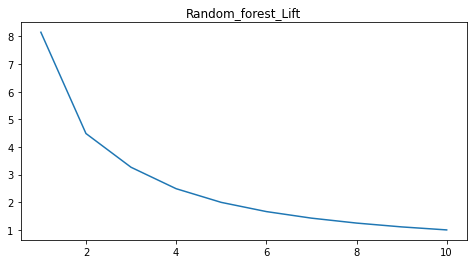

In [44]:
rf=RandomForestClassifier(max_depth=10, random_state=22, n_estimators=10,class_weight='balanced_subsample')
rf.fit(X_train, y_train)

y_pred_df = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob': rf.predict_proba(X_test)[:,1]})

sorted_predict_df = y_pred_df[['predicted_prob','actual']].sort_values('predicted_prob',ascending=False)

num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_df = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_df.columns = ['decile','gain']

gain_lift_df['gain__percetage']= (100* gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum())
gain_lift_df['lift']= (gain_lift_df.gain__percetage/(gain_lift_df.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_df['decile'],
         gain_lift_df['lift'],'-')
plt.title('Random_forest_Lift')
plt.show()

number of observations per decile: 1184


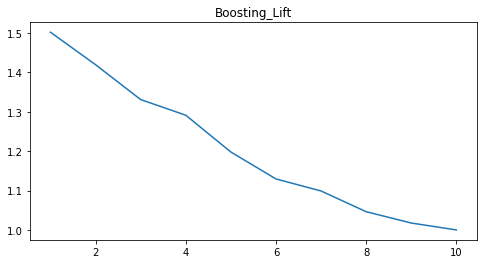

In [46]:
boost=AdaBoostClassifier(base_estimator = LogisticRegression(class_weight='balanced'), algorithm = 'SAMME.R', n_estimators=10)
boost.fit(X_train, y_train)

y_pred_df = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob': boost.predict_proba(X_test)[:,1]})

sorted_predict_df = y_pred_df[['predicted_prob','actual']].sort_values('predicted_prob',ascending=False)

num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_df = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_df.columns = ['decile','gain']

gain_lift_df['gain__percetage']= (100* gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum())
gain_lift_df['lift']= (gain_lift_df.gain__percetage/(gain_lift_df.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_df['decile'],
         gain_lift_df['lift'],'-')
plt.title('Boosting_Lift')
plt.show()

number of observations per decile: 1184


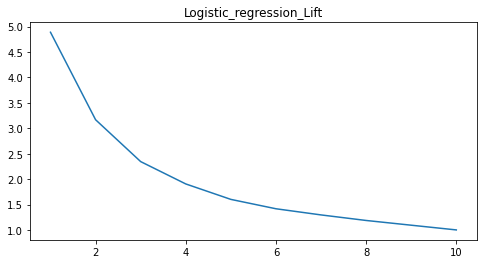

In [47]:
LR=LogisticRegressionCV(class_weight='balanced')
LR.fit(X_train, y_train)

y_pred_df = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob': LR.predict_proba(X_test)[:,1]})

sorted_predict_df = y_pred_df[['predicted_prob','actual']].sort_values('predicted_prob',ascending=False)

num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_df = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_df.columns = ['decile','gain']

gain_lift_df['gain__percetage']= (100* gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum())
gain_lift_df['lift']= (gain_lift_df.gain__percetage/(gain_lift_df.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_df['decile'],
         gain_lift_df['lift'],'-')
plt.title('Logistic_regression_Lift')
plt.show()

<div class="alert alert-block alert-danger" >
From the plot we can observe the following:
    
b. RandomForest gives highest lift in the top decile
     
c. RandomForest gives best lift in the top quartile

### Q2.7

What feature selection techniques could be used to reduce the number of features? What other feature selection techniques could be used in this scenario?

#### A 2.7

<div class="alert alert-block alert-danger" >
`We could use Chi-Square_test,Correlation_coefficients, Variance threshold, Mean Absolute Difference, Forward feature selction, Backward feature elimination, reccursive feature elemination.`

`We could also use Lasso Regularization or Random forest feature importance`

**Example**

In [43]:
df_corr=X_train.copy()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
print(f' With correlation greater than 0.8 we can drop {len(to_drop)} highly correlated features and reduce features and data redundancy')

 With correlation greater than 0.8 we can drop 240 highly correlated features and reduce features and data redundancy


or get top 20 features by randomforest feature importance

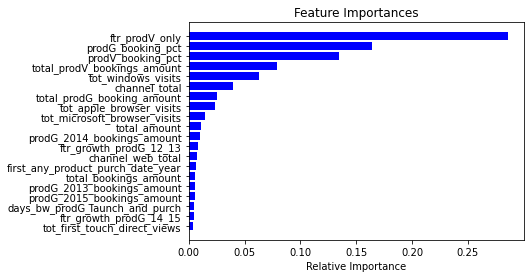

In [49]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [46]:
df_train[df_train['ftr_prodV_only']==0][response_variable].value_counts(normalize=True)

1    0.553315
0    0.446685
Name: trainy_period_workstation_purchase_flag, dtype: float64

**The most important feature when respose variable is 0 contains 55% 1 and 44% times 0**

In [45]:
df_train[df_train['ftr_prodV_only']==1][response_variable].value_counts()

0    71988
Name: trainy_period_workstation_purchase_flag, dtype: int64

**The most important feature when respose variable is 1 contains only records classified as 0 for the feature 'ftr_prodV_only which is classified as the most important variable under RF model**

In [37]:
df_train.groupby(['total_prodV_bookings_amount'])[response_variable].value_counts()

total_prodV_bookings_amount  trainy_period_workstation_purchase_flag
-1294.85                     0                                          1
-439.50                      0                                          1
-286.00                      0                                          1
-230.58                      0                                          1
-200.00                      0                                          1
                                                                       ..
 61158.15                    1                                          1
 129496.82                   0                                          1
 189925.80                   0                                          1
 3958462.06                  1                                          1
 7745657.81                  1                                          1
Name: trainy_period_workstation_purchase_flag, Length: 10896, dtype: int64

In [50]:
imp_features=[features[i] for i in indices]

In [51]:
imp_features

['tot_first_touch_direct_views',
 'ftr_growth_prodG_14_15',
 'days_bw_prodG_launch_and_purch',
 'prodG_2015_bookings_amount',
 'prodG_2013_bookings_amount',
 'total_bookings_amount',
 'first_any_product_purch_date_year',
 'channel_web_total',
 'ftr_growth_prodG_12_13',
 'prodG_2014_bookings_amount',
 'total_amount',
 'tot_microsoft_browser_visits',
 'tot_apple_browser_visits',
 'total_prodG_booking_amount',
 'channel_total',
 'tot_windows_visits',
 'total_prodV_bookings_amount',
 'prodV_booking_pct',
 'prodG_booking_pct',
 'ftr_prodV_only']

The above Features will be used in our modelling from henceforth

### Modeling Technique

#### A2.8
<div class="alert alert-block alert-danger" >
The main difference between random forests and gradient boosting lies in how the decision trees are created and aggregated. Unlike random forests, the decision trees in gradient boosting are built additively; in other words, each decision tree is built one after another.

However, these trees are not being added without purpose. Each new tree is built to improve on the deficiencies of the previous trees and this concept is called boosting.

The gradient part of gradient boosting comes from minimising the gradient of the loss function as the algorithm builds each tree.

Another key difference between random forests and gradient boosting is how they aggregate their results. In random forests, the results of decision trees are aggregated at the end of the process. Gradient boosting doesn’t do this and instead aggregates the results of each decision tree along the way to calculate the final result.

Overall, gradient boosting usually performs better than random forests but they’re prone to overfitting; to avoid this, we need to remember to tune the parameters carefully.

In [68]:
rf = RandomForestClassifier( random_state = 10)
params = {
    'n_estimators': [20,50,200],
    'max_depth': [8,12, None]
}
cv = GridSearchCV(rf, params, cv = 2)
# Fit GridSearchCV to training set 
cv.fit(X_train[imp_features], y_train)
# Best parameters
cv.best_params_

KeyboardInterrupt: 

* max_depth='None'
* n_estimators=200

In other words, the most ideal random forest model for this training set contains 200 decision trees with a maximum depth of 'None'.

In [54]:
from sklearn.metrics import precision_recall_fscore_support

In [58]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 200, max_depth =None, random_state = 10,class_weight='balanced_subsample')
# Fit model
start = time.time()
rf_model = rf.fit(X_train[imp_features],y_train)
end = time.time()
fit_time = end - start
# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test[imp_features])
probas=rf.predict_proba(X_test[imp_features])[:,1]
auc_score = roc_auc_score(y_test, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_test).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 11.681 / Predict time: 0.356
Precision: 0.891 / Recall: 0.63 / Accuracy: 0.979
AUC: 0.99


**Training accuracy is as seen above**

In [59]:
# Predict on scoring set
start = time.time()
Y_pred = rf_model.predict(X_score[imp_features])
probas=rf.predict_proba(X_score[imp_features])[:,1]
auc_score = roc_auc_score(y_score, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_score, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_score).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 11.681 / Predict time: 1.003
Precision: 0.911 / Recall: 0.766 / Accuracy: 0.988
AUC: 1.0


**scoring accuracy is as above, we have good AUC with the scoring data**

<AxesSubplot:>

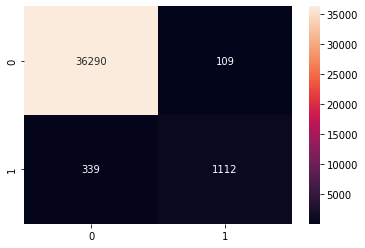

In [68]:
# Confusion matrix for GradientBoostingClassifier
import seaborn as sns
matrix = confusion_matrix(y_score, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

In [70]:
# Set up GridSearchCV
gb = GradientBoostingClassifier(random_state = 10)
params = {
    'n_estimators': [5, 50, 250],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}
cv = GridSearchCV(gb, params, cv = 3)
# Fit GridSearchCV to training set
cv.fit(X_train[imp_features], y_train)
# Best parameters
cv.best_params_

KeyboardInterrupt: 

In [71]:
# Instantiate GradientBoostingClassifier with best hyperparameters 
rf = GradientBoostingClassifier(n_estimators = 250, max_depth = 3, learning_rate = 0.01, random_state = 42)
# Fit model
start = time.time()
rf_model = rf.fit(X_train[imp_features],y_train)
end = time.time()
fit_time = end - start
# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test[imp_features])
probas=rf.predict_proba(X_test[imp_features])[:,1]
auc_score = roc_auc_score(y_test, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_test).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 24.502 / Predict time: 0.059
Precision: 0.89 / Recall: 0.533 / Accuracy: 0.975
AUC: 0.99


In [72]:
# Predict on scoring set
start = time.time()
Y_pred = rf_model.predict(X_score[imp_features])
probas=rf.predict_proba(X_score[imp_features])[:,1]
auc_score = roc_auc_score(y_score, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_score, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_score).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 24.502 / Predict time: 0.193
Precision: 0.923 / Recall: 0.703 / Accuracy: 0.986
AUC: 1.0


scoring accuracy is as above, we have good AUC with the scoring data 

# Q2.9 
How could clustering be combined with classification for this problem?

#### A2.9
<div class="alert alert-block alert-danger" >
Clustering is a type of unsupervised machine learning which aims to find homogeneous subgroups such that objects in the same group (clusters) are more similar to each other than the others.

KMeans is a clustering algorithm which divides observations into k clusters. Since we can dictate the amount of clusters, it can be easily used in classification where we divide data into clusters which can be equal to or more than the number of classes.

`In the VMWare dataset which is a collection of labelled workstations purchase flags, we can use KMeans to find clusters within the dataset and test how good it is as a feature`

`Clustering apart from being an unsupervised machine learning can also be used to create clusters as features to improve classification models. On their own they aren’t enough for classification. But when used as features they improve model accuracy.`

In [109]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [107]:
class clust():
    def _load_data(self, sklearn_load_ds):
        data = sklearn_load_ds
        X = pd.DataFrame(data.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, data.target, test_size=0.3, random_state=42)
        
        
    def __init__(self, x_train,x_test,y_train,y_test):
        self.X_train=x_train
        self.X_test=x_test
        self.y_train=y_train
        self.y_test=y_test


    
    def classify(self, model=LogisticRegression(random_state=42,solver='newton-cg', class_weight='balanced')):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        probas=model.predict_proba(self.X_test)[:,1]
        auc=round(roc_auc_score(self.y_test, probas),2)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))
        print('AUC: {}'.format(auc))


    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

### Predicting only K-Means Clustering

In [98]:
clust(X_train,X_score,y_train,y_score).Kmeans(output='replace').classify(model=RandomForestClassifier(n_estimators = 200, max_depth =None, random_state = 10,class_weight='balanced_subsample'))
# Fit model)

Accuracy: 0.816221928665786
AUC: 0.53


### Predicting without using K-Means Clustering using Logistics Regression

In [110]:
clust(X_train[imp_features],X_score[imp_features],y_train,y_score).classify()

Accuracy: 0.829881109643329
AUC: 0.88


### Predicting using K-Means Clustering and Logistics Regression

In [111]:
clust(X_train[imp_features],X_score[imp_features],y_train,y_score).Kmeans(output='add').classify()

Accuracy: 0.8964861294583883
AUC: 0.95


`Clustering apart from being an unsupervised machine learning can also be used to create clusters as features to improve classification models. On their own they aren’t enough for classification as the results show. But when used as features they improve model accuracy.`

# Q2.10 Logistics Regression Questions:
## Q2.10.1 	What value of regularization parameter leads to the best results for penalized logistic regression?

In [50]:
from sklearn.preprocessing import StandardScaler
# Standardizing the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[imp_features]).copy()
X_test_std = scaler.transform(X_test[imp_features]).copy()
X_val_train_std = scaler.fit_transform(X_val[imp_features]).copy()
X_val_test_std = scaler.fit_transform(X_val_test[imp_features]).copy()

y_train_std=y_train.values
y_test_std=y_test.values

In [52]:
from sklearn.model_selection import KFold
# Make a list of 6 C values to vary the range of regularization such that you get the best accuracy
Clist = [1e-30,1e-20,1e-17,1e-15,1e-5,1e-3,1,1e3,1e5]

# Create a dictionary to store the validation acurracies of corresponding c values
validation_accuracy = {}

for i in Clist:
    cross_validation_score = []

    # Specifying the number of splits needed
    kf = KFold(n_splits=5)

    # Getting the split indices iteratively
    for train_index , val_index in kf.split(X_train_std):

        # Getting the cross-validation train and val data using the indies
        X_train_cross , X_val_cross = X_train_std[train_index,:],X_train_std[val_index,:]
        y_train_std_cross , y_val_cross = y_train_std[train_index] , y_train_std[val_index]

        # Making a logistic regression model
        lr_l2 = LogisticRegression(C=i, max_iter=16000,class_weight='balanced',solver='newton-cg',penalty='l2')

        # Fitting the model
        lr_l2.fit(X_train_cross,y_train_std_cross)

        # Predicting on val data and storing the accuracy
        y_val_pred = lr_l2.predict(X_val_cross)
        cross_validation_score.append(accuracy_score(y_val_cross, y_val_pred))
    
    # Storing the accuracy corresponding to every c-value 
    validation_accuracy[i] = np.mean(cross_validation_score)

# Calculating the best value of c
best_c = max(validation_accuracy.items(), key=lambda x: x[1])[0]
print(f'The best regularization parameter C is {best_c}')

The best regularization parameter C is 1000.0


<div class="alert alert-block alert-danger" >

The best regularization parameter C is 1000.0

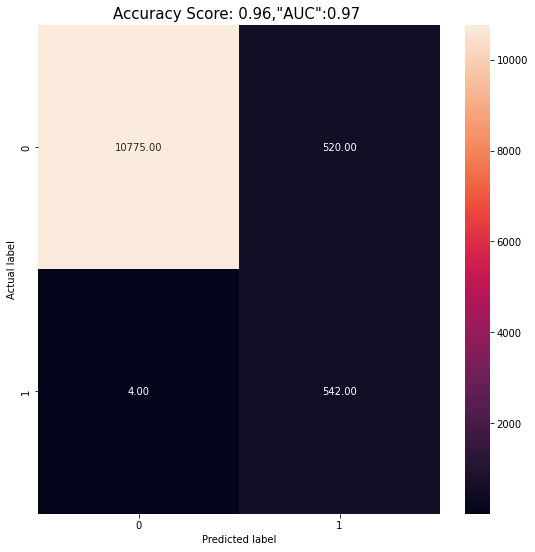

In [69]:
# Training the best model
lr_best = LogisticRegression(C=best_c, max_iter=16000,class_weight='balanced',solver='newton-cg',penalty='l2')
lr_best.fit(X_train_std, y_train_std)
y_pred_test = lr_best.predict(X_test_std)
logreg_best_auc = roc_auc_score(y_test,y_pred_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title(f'Accuracy Score: {round(accuracy_score(y_test,y_pred_test),2)},"AUC":{round(logreg_best_auc,2)} ', size = 15);

## Q10.2 b.	How many features have non-zero coefficients when the penalization parameter alpha is set to 0?

setting alpha to 0 is building the model on ridge regularization, which from above penalty=L2 makes it ridge regularization

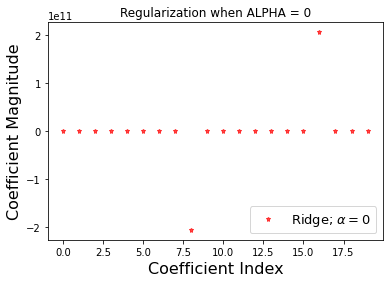

In [61]:
from sklearn.linear_model import Ridge
lr_zero = LogisticRegression(C=1000, max_iter=16000,class_weight='balanced',solver='newton-cg',penalty='l2')
lr_zero.fit(X_train_std, y_train_std)
rr0 = Ridge(alpha=0) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rr0.fit(X_train_std, y_train_std)
rr100 = Ridge(alpha=1) #  comparison with alpha value 1
rr100.fit(X_train_std, y_train_std)
train_score=lr_zero.score(X_train_std, y_train_std)
test_score=lr_zero.score(X_test_std, y_test_std)
Ridge_train_score = rr0.score(X_train_std,y_train_std)
Ridge_test_score = rr0.score(X_test_std, y_test_std)
Ridge_train_score100 = rr100.score(X_train_std,y_train_std)
Ridge_test_score100 = rr100.score(X_test_std, y_test_std)
plt.plot(rr0.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0$',zorder=7) 
#plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 1$') 
#plt.plot(lr_zero.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.title('Regularization when ALPHA = 0')
plt.legend(fontsize=13,loc=4)
plt.show()


<div class="alert alert-block alert-danger" >
`When alpha is 0 we can observe that out of the 20 top important features, there were 2 with non zero coefficients`

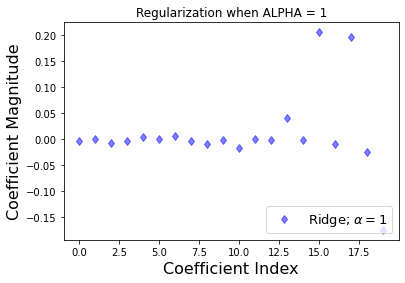

In [62]:
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 1$')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.title('Regularization when ALPHA = 1')
plt.legend(fontsize=13,loc=4)
plt.show()


<div class="alert alert-block alert-danger" >
`When alpha is 1 we can observe that out of the 20 top important features, there were none with non zero coefficients`

## We will generate a normal logictics to compare with the best model genereated above 

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none') 0.65


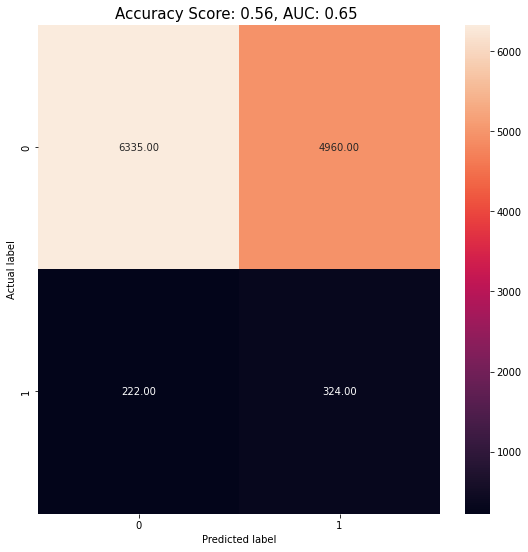

In [88]:
# Fit a vanilla Logistic Regression classifier and make predictions
lr_normal = LogisticRegression(max_iter=1000, penalty='none',class_weight='balanced')
lr_normal.fit(X_train[imp_features], y_train)
y_pred_test = lr_normal.predict(X_test[imp_features])
probas_normal = lr_normal.predict_proba(X_test[imp_features])[:,1]
lr_normal_auc = round(roc_auc_score(y_test, probas_normal),2)

print(lr_normal,lr_normal_auc)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title(f'Accuracy Score: {round(accuracy_score(y_test,y_pred_test),2)}, AUC: {lr_normal_auc} ', size = 15);

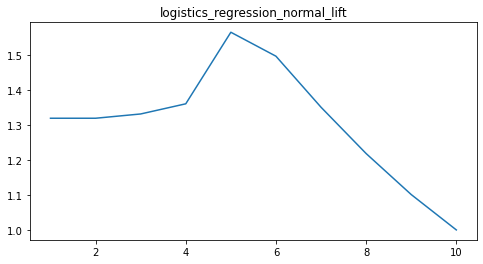

In [176]:


y_pred_df_normal = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob_lr_normal': lr_normal.predict_proba(X_test[imp_features])[:,1]})

sorted_predict_df = y_pred_df_normal[['predicted_prob_lr_normal','actual']].sort_values('predicted_prob_lr_normal',ascending=False)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_lr_normal = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_lr_normal.columns = ['decile','gain']

gain_lift_lr_normal['gain__percetage']= (100* gain_lift_lr_normal.gain.cumsum()/gain_lift_lr_normal.gain.sum())
gain_lift_lr_normal['lift']= (gain_lift_lr_normal.gain__percetage/(gain_lift_lr_normal.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_lr_normal['decile'],
         gain_lift_lr_normal['lift'],'-')
plt.title('logistics_regression_normal_lift')
plt.show()

In [163]:
num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

number of observations per decile: 1184


In [164]:
print(f' Total records in our data is {X_test.shape[0]//10*10}')

 Total records in our data is 11840


In [165]:
y_test.value_counts()[1]

546

`We have 546 buyers of workstation in our test data` 

In [180]:
gain_lift_lr_normal['No_of_observations']=[int(x) for x in list(np.linspace(0, X_test.shape[0], 10+1)[1:])] #10 because decile +1 for explicit pos argument
gain_lift_lr_normal['No_of_WS_buyers_without_model']=[int(x) for x in list(np.linspace(0, y_test.value_counts()[1], 10+1)[1:])]
gain_lift_lr_normal.rename(columns={'gain':'No_of_WS_buyers_using_model'},inplace=True)
gain_lift_lr_normal['CumSum_positives_using_the_model']=gain_lift_lr_normal.No_of_WS_buyers_using_model.cumsum()
rearrange_gain_lift_df_col=['decile', 'No_of_observations', 'No_of_WS_buyers_without_model', 'No_of_WS_buyers_using_model','CumSum_positives_using_the_model','gain__percetage', 'lift']

In [182]:
gain_lift_lr_normal[rearrange_gain_lift_df_col]

decile  No_of_observations  No_of_WS_buyers_without_model  \
0       1                1184                             54   
1       2                2368                            109   
2       3                3552                            163   
3       4                4736                            218   
4       5                5920                            273   
5       6                7104                            327   
6       7                8288                            382   
7       8                9472                            436   
8       9               10656                            491   
9      10               11841                            546   

   No_of_WS_buyers_using_model  CumSum_positives_using_the_model  \
0                           72                                72   
1                           72                               144   
2                           74                               218   
3                           79                               297   
4                          130                               427   
5                           63                               490   
6                           26                               516   
7                           16                               532   
8                            9                               541   
9                            5                               546   

   gain__percetage      lift  
0        13.186813  1.318681  
1        26.373626  1.318681  
2        39.926740  1.330891  
3        54.395604  1.359890  
4        78.205128  1.564103  
5        89.743590  1.495726  
6        94.505495  1.350078  
7        97.435897  1.217949  
8        99.084249  1.100936  
9       100.000000  1.000000

<div class="alert alert-block alert-danger" >
From above we can observe that the from the **Normal Logistics regression model** we can reach 490 customers buying the workstation within the 5th decile while it would take upto the 9th decile for 490 customers to buy workstation  

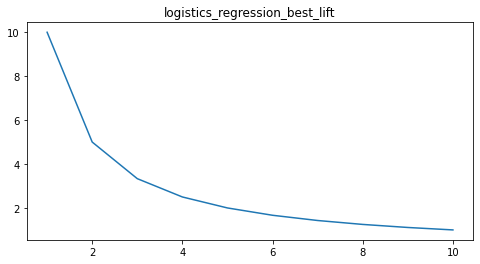

In [197]:
y_pred_df_best = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob_lr_best': lr_best.predict_proba(X_test_std)[:,1]})

sorted_predict_df = y_pred_df_best[['predicted_prob_lr_best','actual']].sort_values('predicted_prob_lr_best',ascending=False)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_lr_best = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_lr_best.columns = ['decile','gain']

gain_lift_lr_best['gain__percetage']= (100* gain_lift_lr_best.gain.cumsum()/gain_lift_lr_best.gain.sum())
gain_lift_lr_best['lift']= (gain_lift_lr_best.gain__percetage/(gain_lift_lr_best.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_lr_best['decile'],
         gain_lift_lr_best['lift'],'-')
plt.title('logistics_regression_best_lift')
plt.show()

In [198]:
gain_lift_lr_best['No_of_observations']=[int(x) for x in list(np.linspace(0, X_test.shape[0], 10+1)[1:])] #10 because decile +1 for explicit pos argument
gain_lift_lr_best['No_of_WS_buyers_without_model']=[int(x) for x in list(np.linspace(0, y_test.value_counts()[1], 10+1)[1:])]
gain_lift_lr_best.rename(columns={'gain':'No_of_WS_buyers_using_model'},inplace=True)
gain_lift_lr_best['CumSum_positives_using_the_model']=gain_lift_lr_best.No_of_WS_buyers_using_model.cumsum()
rearrange_gain_lift_df_col=['decile', 'No_of_observations', 'No_of_WS_buyers_without_model', 'No_of_WS_buyers_using_model','CumSum_positives_using_the_model','gain__percetage', 'lift']

In [199]:
gain_lift_lr_best[rearrange_gain_lift_df_col]

decile  No_of_observations  No_of_WS_buyers_without_model  \
0       1                1184                             54   
1       2                2368                            109   
2       3                3552                            163   
3       4                4736                            218   
4       5                5920                            273   
5       6                7104                            327   
6       7                8288                            382   
7       8                9472                            436   
8       9               10656                            491   
9      10               11841                            546   

   No_of_WS_buyers_using_model  CumSum_positives_using_the_model  \
0                          546                               546   
1                            0                               546   
2                            0                               546   
3                            0                               546   
4                            0                               546   
5                            0                               546   
6                            0                               546   
7                            0                               546   
8                            0                               546   
9                            0                               546   

   gain__percetage       lift  
0            100.0  10.000000  
1            100.0   5.000000  
2            100.0   3.333333  
3            100.0   2.500000  
4            100.0   2.000000  
5            100.0   1.666667  
6            100.0   1.428571  
7            100.0   1.250000  
8            100.0   1.111111  
9            100.0   1.000000

<div class="alert alert-block alert-danger" >
From above we can observe that the from the **Rgularized Logistics regression model** we can reach all the 546 customers buying the workstation within the 1st decile itself.Showing us the regularization works well for for dataset

#### Comparing values of coeffecients

In [207]:
#make a dictionary of the coefficients along with the predictors as keys

lreg_best_coef = dict(zip(X_train[imp_features].columns, np.transpose(lr_best.coef_)))

#Linear regression coefficient values to plot

lreg_reg_x = list(lreg_best_coef.keys())
lreg_reg_y = list(lreg_best_coef.values())

In [208]:
#make a dictionary of the coefficients along with the predictors as keys
lreg_normal_coef = dict(zip(X_train[imp_features].columns, np.transpose(lr_normal.coef_)))

#Linear regression coefficient values to plot

lreg_normal_x = list(lreg_normal_coef.keys())
lreg_normal_y = list(lreg_normal_coef.values())

Normal linear regression coeeficients Max and Min

In [227]:
min([float(x) for x in lreg_normal_y]),max([float(x) for x in lreg_normal_y])

(-6.512705361409642e-15, 6.09929847446008e-10)

Max coefficient for normal logistics regression is 6*10^-10 a very small coeffecient

Regularized linear regression coeeficients: Max and Min

In [224]:
min([float(x) for x in lreg_reg_y]),max([float(x) for x in lreg_reg_y])

(-5.248958713047074, 1.3258572106754494)

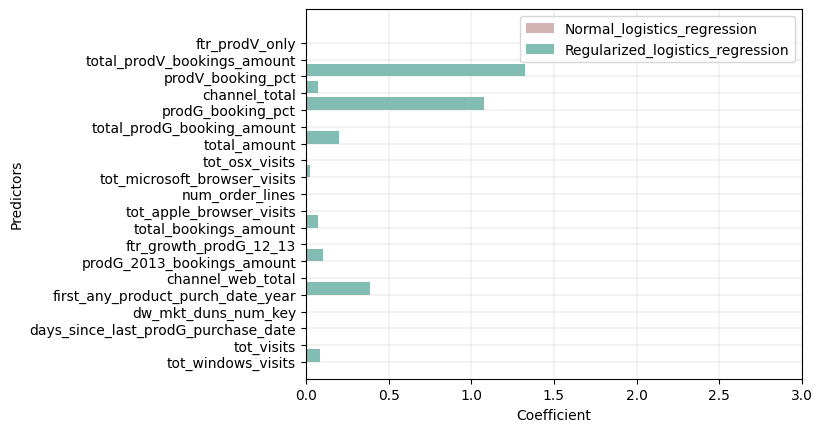

In [226]:
plt.rcdefaults()

plt.barh(lreg_normal_x,[float(x) for x in lreg_normal_y],1.0, align='edge',color="#D3B4B4", label="Normal_logistics_regression")
plt.barh(lreg_reg_x,[float(x) for x in lreg_reg_y],0.75 ,align='edge',color="#81BDB2",label = "Regularized_logistics_regression")

plt.grid(linewidth=0.2)
plt.xlabel("Coefficient")
plt.ylabel("Predictors")
plt.legend(loc='best')
plt.xlim(-6.5e-15,3)
plt.show()

### Comparing AUC of Normal LR and Regularized Logistics regression

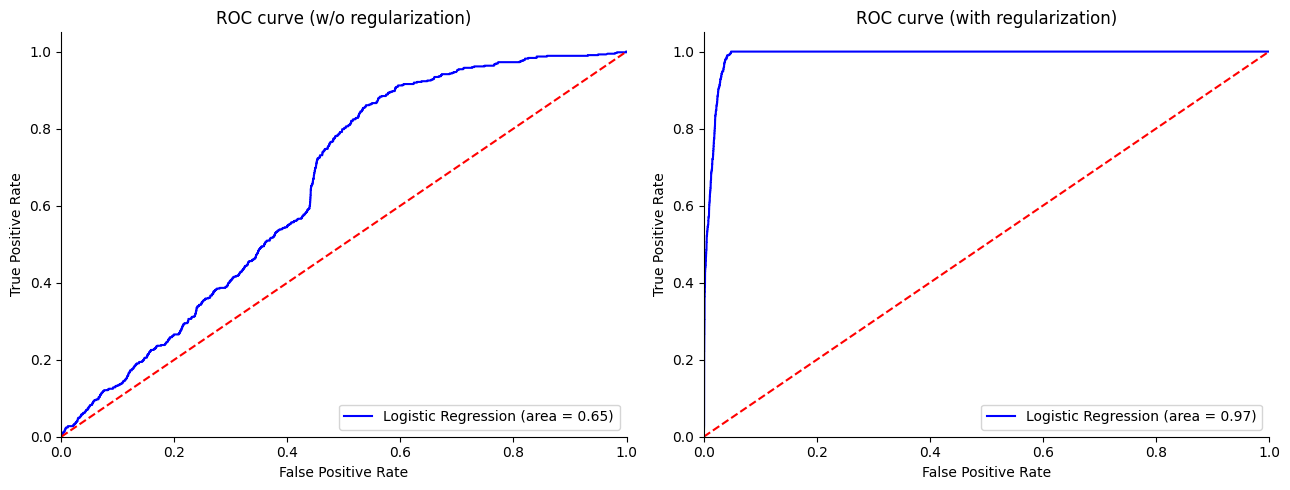

In [231]:
fig, ax = plt.subplots(1, 2, figsize = (13,5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)

# Plotting the ROC curve for logistic regression without regularization
y_probs = lr_normal.predict_proba(X_test[imp_features])[:,1]
plot_roc(y_test,y_probs,lr_normal_auc,ax[0])
ax[0].set_title('ROC curve (w/o regularization)')

# Plotting the ROC curve for logistic regression with regularization
y_probs_best = lr_best.predict_proba(X_test_std)[:,1]
plot_roc(y_test,y_probs_best,logreg_best_auc,ax[1])
ax[1].set_title('ROC curve (with regularization)')
plt.tight_layout()

# Q2.11.	What other methods can be used to handle imbalanced datasets such as this one?

**Random Under-Sampling**
- Random Undersampling aims to balance class distribution by randomly eliminating majority class examples.  This is done until the majority and minority class instances are balanced out.

**Random Over-Sampling**
- Over-Sampling increases the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.

**Cluster-Based Over Sampling**
In this case, the K-means clustering algorithm is independently applied to minority and majority class instances. This is to identify clusters in the dataset. Subsequently, each cluster is oversampled such that all clusters of the same class have an equal number of instances and all classes have the same size.  

**Informed Over Sampling: Synthetic Minority Over-sampling Technique for imbalanced data (SMOTE)**
- This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.

**Algorithmic Ensemble Techniques**
- The main objective of ensemble methodology is to improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their predictions.

#### Example of few Imbalance Techniques

#### Strategy 1 - Vanilla Random Forest

- No correction for imbalance

In [63]:
# Define a Random Forest classifier with randon_state as above
random_state=22
max_depth=10
# Set the maximum depth to be max_depth and use 10 estimators
random_forest = RandomForestClassifier(max_depth=2, random_state=22, n_estimators=5)

# Fit the model on the training set
random_forest.fit(X_train[imp_features], y_train)


RandomForestClassifier(max_depth=2, n_estimators=5, random_state=22)

In [64]:
# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score1
f_score = f1_score(y_val_test, predictions)
score1 = round(f_score, 2)

# Compute the AUC and assign it to variable auc1
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc1 = round(auc_score, 2)


#### Strategy 2 - Random Forest with class weighting
- Balancing the class imbalance in each bootstrap

In [65]:
# Define a Random Forest classifier with randon_state as above
# Set the maximum depth to be max_depth and use 10 estimators
# Use class_weight as balanced_subsample to weigh the class accordingly
random_forest = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=10,class_weight='balanced_subsample')

# Fit the model on the training se
random_forest.fit(X_train[imp_features], y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=10, random_state=22)

In [66]:
### edTest(test_balanced) ###

# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score2
f_score = f1_score(y_val_test, predictions)
score2 = round(f_score, 2)

# Compute the AUC and assign it to variable auc2
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc2 = round(auc_score, 2)


#### Strategy 3 - Balanced Random Forest with SMOTE 

- Using the **imblearn** `BalancedRandomForestClassifier()` 
- Read more about this implementation [here](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)

In [67]:
# Perform upsampling using SMOTE

# Define a SMOTE with random_state=2
sm = SMOTE(random_state=2)

# Use the SMOTE object to upsample the train data
# You may have to use ravel() 
X_train_res, y_train_res = sm.fit_resample(X_train[imp_features], y_train.ravel())

In [68]:
# Define a Random Forest classifier with randon_state as above
# Set the maximum depth to be max_depth and use 10 estimators
# Use class_weight as balanced_subsample to weigh the class accordingly
random_forest = BalancedRandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=10, class_weight='balanced_subsample')

# Fit the Random Forest on upsampled data 
random_forest.fit(X_train_res, y_train_res)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                               n_estimators=10, random_state=22)

In [69]:
# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute the F1-score and assign it to variable score3
f_score = f1_score(y_val_test, predictions)
score3 = round(f_score, 2)

# Compute the AUC and assign it to variable auc3
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc3 = round(auc_score, 2)

#### Strategy 4 - Downsample the data

Using the imblearn RandomUnderSampler().

In [70]:
# Define an RandomUnderSampler instance with random state as 2
rs = RandomUnderSampler(random_state=2)

# Downsample the train data
# You may have to use ravel()
X_train_res, y_train_res = rs.fit_resample(X_train[imp_features], y_train.ravel())


In [71]:
# Define a Random Forest classifier with randon_state as above
# Set the maximum depth to be max_depth and use 10 estimators
# Use class_weight as balanced_subsample to weigh the class accordingly
random_forest = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=10,class_weight='balanced_subsample')

# Fit the Random Forest on downsampled data 
random_forest.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=10, random_state=22)

In [72]:
# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score4
f_score = f1_score(y_val_test, predictions)
score4 = round(f_score, 2)

# Compute the AUC and assign it to variable auc4
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc4 = round(auc_score, 2)

In [73]:
# Compile the results from the implementations above

pt = PrettyTable()
pt.field_names = ["Strategy","F1 Score","AUC score"]
pt.add_row(["Random Forest - No imbalance correction",score1,auc1])
pt.add_row(["Random Forest - balanced_subsamples",score2,auc2])
pt.add_row(["Random Forest - Upsampling",score3,auc3])
pt.add_row(["Random Forest - Downsampling",score4,auc4])
print(pt)


+-----------------------------------------+----------+-----------+
|                 Strategy                | F1 Score | AUC score |
+-----------------------------------------+----------+-----------+
| Random Forest - No imbalance correction |   0.0    |    0.97   |
|   Random Forest - balanced_subsamples   |   0.78   |    0.98   |
|        Random Forest - Upsampling       |   0.77   |    0.98   |
|       Random Forest - Downsampling      |   0.76   |    0.97   |
+-----------------------------------------+----------+-----------+


<div class="alert alert-block alert-danger" >
When faced with imbalanced data sets there is no one stop solution to improve the accuracy of the prediction model.  One may need to try out multiple methods to figure out the best-suited sampling techniques for the dataset. In most cases, synthetic techniques like SMOTE and MSMOTE will outperform the conventional oversampling and undersampling methods.

For better results, one can use synthetic sampling methods like SMOTE and MSMOTE along with advanced boosting methods like Gradient boosting and XG Boost.

One of the advanced bagging techniques commonly used to counter the imbalanced dataset problem is SMOTE bagging. It follows an entirely different approach from conventional bagging to create each Bag/Bootstrap. It generates the positive instances by the SMOTE Algorithm by setting a SMOTE resampling rate in each iteration. The set of negative instances is bootstrapped in each iteration.

Depending on the characteristics of the imbalanced data set, the most effective techniques will vary. Relevant evaluation parameters should be considered during the model comparison.

While comparing multiple prediction models built through an exhaustive combination of the above-mentioned techniques Lift & Area under the ROC Curve will be instrumental in determining which model is superior to the others.

# Communicating results to business

# Q2.12. Based on Q. 7, how should the lift values be communicated to the business?

<div class="alert alert-block alert-danger" >
The lift could be interpreted as the gain ratio percentage to the random percentage at a given decile level. In a layman term, in decile 1, we have 10 means that when selecting 10% of the data based on the model, we could find the target (actual positive) 10 times more than the randomly selected 10% of the data without a model.

# Q2.13.  List a few uses of the propensity model in an online store.How can the model be white-boxed to explain the importance of various features in the model?

<div class="alert alert-block alert-danger" >
    
Propensity modeling attempts to predict the likelihood that visitors, leads, and customers will perform certain actions. It’s a statistical approach that accounts for all the independent and confounding variables that affect said behavior.

So, for example, propensity modeling can help a marketing team predict the likelihood that a lead will convert to a customer. Or that a customer will churn. Or even that an email recipient will unsubscribe.

The propensity score, then, is the probability that the visitor, lead, or customer will perform a certain action. 


The first step is to actually pick a model because you have a few options. For example, instead of measuring propensity to churn, you could choose a survival analysis.

Regression is a good option because it’s very interpretable for non-technical audiences, which means it can be communicated easily.

It’s also less of a black box, making the risk more manageable. If something goes wrong and accuracy is low or you get an unexpected result, it’s easy to drill down to the formula and figure out how to fix it.

# Q3

### Q 3.A.
**What strategy should Vijaya Kumar adopt for developing forecasting model for demand estimation of 20,000 spare parts?**

<div class="alert alert-block alert-danger" >

For estimating 20,000 spare parts it would be very expensive and time consuming to forecast 20,000 individual demand. Therefore, we can develop a strategy where we categorize the spare parts in  
1. Based on the **frequency of demand**, for simplicity we can have three categories - fast (F), medium (M), and slow (S). Call them as FMS categorization. 
2. Based on the **value of the product**, according to value: high (H), medium (M), and low (L),we can call this as the HML categorization.
3. Based ABC analysis where the spare parts belonging to category A constitutes 70% of the sales, the spare parts belonging to category B constituted 25% of the sales, while category C spare parts constituted 5% of the sales.
4. Categorization based on combinations of these three categories and rankin them accordingly.

For example, a category A spare part that was fast-moving (F) and had high value (H) will be assigned the top rank; this combination would be termed “AHF” and so on. 

### Q 3.B	Develop forecasting models for data provided in the Excel sheet titled ‘‘L&T Spare Parts Forecasting’’ and discuss the choice for using a particular forecasting model. !

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing

In [10]:
# let us read the 
data= pd.read_excel('LT Spare Parts Forecasting.xlsx',engine='openpyxl')

In [11]:
data[:5]

Month  205-70-N1190  PC_198_27_42263  PC_203_32_51461  PC_600_863_4210  \
0 2009-04-01          2013              0.0              0.0              1.0   
1 2009-05-01          1776              0.0              0.0              1.0   
2 2009-06-01          2092              0.0              0.0              0.0   
3 2009-07-01          1793              0.0              0.0              2.0   
4 2009-08-01          1829             15.0              0.0              0.0   

   PC_6735_61_3410  D30141135  600-181-6740I.  07063-51210I.  600-319-4540I.  \
0              0.0        457             381            435             231   
1              0.0        439             327            349             373   
2              0.0        404             389            339             112   
3              2.0        392             283            338             103   
4              0.0        403             310            389             223   

   6735-51-5143I  07000-B2011I.  
0            578             10  
1            535             17  
2            540             38  
3            682             27  
4            634             32

In [12]:
data[data.isna().any(axis=1)]

Month  205-70-N1190  PC_198_27_42263  PC_203_32_51461  \
48 2013-04-01          3394              NaN              NaN   

    PC_600_863_4210  PC_6735_61_3410  D30141135  600-181-6740I.  \
48              NaN              NaN        359             286   

    07063-51210I.  600-319-4540I.  6735-51-5143I  07000-B2011I.  
48            500             676            552             39

In [12]:
df=data.copy()
## time series EDA
df.set_index('Month',inplace=True)
df.index.min(), df.index.max()

(Timestamp('2009-04-01 00:00:00'), Timestamp('2013-04-01 00:00:00'))

In [13]:
Summary =pd.DataFrame([i for i in df.columns],columns=['Variable'])
Summary_ls=[]

we can observe the the time series is of 48 months or 4 years aggregated monthly data

In [14]:
fc_ls1= list(df.columns)

From the data provided with no data decription we can forecast for those variables the monthly count is greater than 100. We have 6 variable with monthly count greater than 100. The variable name are printed above.

##### The following steps are used to determine the appropriate forecasting model for different variables:

**Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series**

**step 1b: Perform hypothesis test for stationarity**
1. augmented dickey fuller test ADF: 
    - Null hypothesis: the series contains a unit root: it is not stationary.
    -Alternative hypothesis: there is no unit root.
    -Low p-values are preferable. If the test returns a p-value below the chosen significance level (e.g. 0.05),we reject the null and conclude that the series does not contain a unit root.
    -If the ADF test does not find a unit root, but the KPSS test does, the series is difference-stationary: it still requires differencing.
    -The pmdarima tests, both ADF and KPSS, provide as outputs the p-value; and a Boolean value that is the answer to the the question: “Should we difference?”
    
2. Kwiatkowski-Phillips-Schmidt-Shin KPSS test: 
    - Null hypothesis: the series is stationary around a deterministic trend (trend-stationary).
    -Note that the KPSS test swaps the null hypothesis and alternative hypothesis, compared to the ADF test.
    -Alternative hypothesis: the series has a unit root. It is non-stationary.
    -High p-values are preferable. If the test returns a p-value above the chosen significance level (e.g. 0.05), we conclude that it appears to be (at least trend-)stationary.
    -If the KPSS test does not find a unit root, but the ADF test does, the series is trend-stationary: it requires differencing (or other transformations such as de-trending) to remove the trend.
3. Osborn-Chui-Smith-Birchenhall OCSB for seasonal differencing
4. Canova-Hansen CH for seasonal differencing


- Has neither trend nor seasonality -> stationary
- Has either trend or seasonality -> nonstationary

**Step 2a: If stationary, identify p ,d and q to build Exponential-Smoothing and ARIMA Models:**
- Finding q such that ACF(q) falls outside confidence limits (shaded area in ACF plot) and ACF(k) falls inside confidence limits for all k>q
- Finding p such that PACF(p) falls outside confidence limits (shaded area in PACF plot) and choosing the highest value of them and PACF(k) falls inside confidence limits for all k>p.
- Split the data into train test
- Determining all ordered pairs p in \[1,2,4,6,8,10\] , d in range(0,3) and q in range(0,3) and trying out different models with these combinations.
- find the best parameter which has the least RMSE
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best


**Step 2b: If nonstationary, detrend and de-seasonality:**

1. Diagnose and determine appropriate trend and/or seasonal components.
2. Obtain the residuals after applying the trend and/or seasonal components.
3. Verify that the residuals appear to be stationary.
4. Determine an appropriate ARMA model for the residual series.


**Step 3: Combine all the components (trend, seasonality, ARIMA, interventions, regressors)**

**Step 4: Evaluate models- Basically, we evaluate and explain the following factors (trade-off):**
1. Whether the model passes all the tests (white noise test, unit & seasonal root tests)
2. Whether the model has acceptable error (e.g. RMSE)
3. Whether the parameters are significant
4. Whether the model is too complex
5. Whether the forecast is reasonable

Not all Dickey–Fuller regression models have white noise residuals. If there is autocorrelation in the series, it has to be removed from the residuals of the regressions before the Dickey–Fuller tests are run.

Under conditions of residual serial correlation, the augmented Dickey–Fuller test,
$$y_t = α_0+\rho_1*y_{t-1}+\sum\limits_{j=2}^{p-1}\beta_t*\Delta y_{t-j}+\epsilon_t$$


### Dickey Fuller Test (Unit root test)

The series could be nonstationary because of stochastic trend or deterministic trend.

The three cases of Dickey-Fuller Test:
-  a pure random walk, 
-  random walk plus drift, or 
 - the combination of deterministic trend, random walk, and drift.

One way to test this is to evaluate a regression that nests a mean, a lagged term (to test for difference stationarity), and a deterministic trend term (to test for trend stationarity) in one model.
$$y_t = α+\rho*y_{t-1}+\beta_t+\epsilon_t$$

And by taking the first difference of the yt one finds that:

$$\Delta y_t = α+(\rho-1)*y_{t-1}+\beta_t+\epsilon_t$$


The Dickey–Fuller tests involve an individual and a joint test for RWD and Deterministic Trend.

### Dickey Fuller -RW

The regression equation to be tested in the first case is:
$$ y_t = \rho*y_{t-1}+\epsilon_t$$


The null hypothesis is that ρ = 1

If the null hypothesis cannot be rejected, the data generating process is inferred to have a unit root and to be non-stationary. 

Therefore, the two-sided significance test performed is that for the statistical significance of ρ – 1 = 0. The test resembles a t-test.

### Dickey Fuller -RWD

The regression equation to be tested in the second case is:
$$ y_t = \alpha+\rho*y_{t-1}+\epsilon_t$$
	

The null hypothesis is that ρ = 1 and the alternative hypothesis is that the series is stationary.

The Dickey–Fuller tests involve an individual and a joint test. There is not only the test for ρ = 1; there is a joint F test for the null hypothesis that α = 0 and ρ = 1 as well.

### Dickey Fuller -RWD with Deterministic Trend

The regression equation to be tested in the third case is:
$$ y_t = \alpha+\rho*y_{t-1}+\beta_t+\epsilon_t$$


The null hypothesis is that ρ = 1 and the alternative hypothesis is that the series is stationary.

The Dickey–Fuller tests involve an individual and a joint test. There is not only the test for ρ = 1; there is a joint F test for the null hypothesis that ρ = 1 and β = 0 as well.




### Variable 1:  205-70-N1190

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



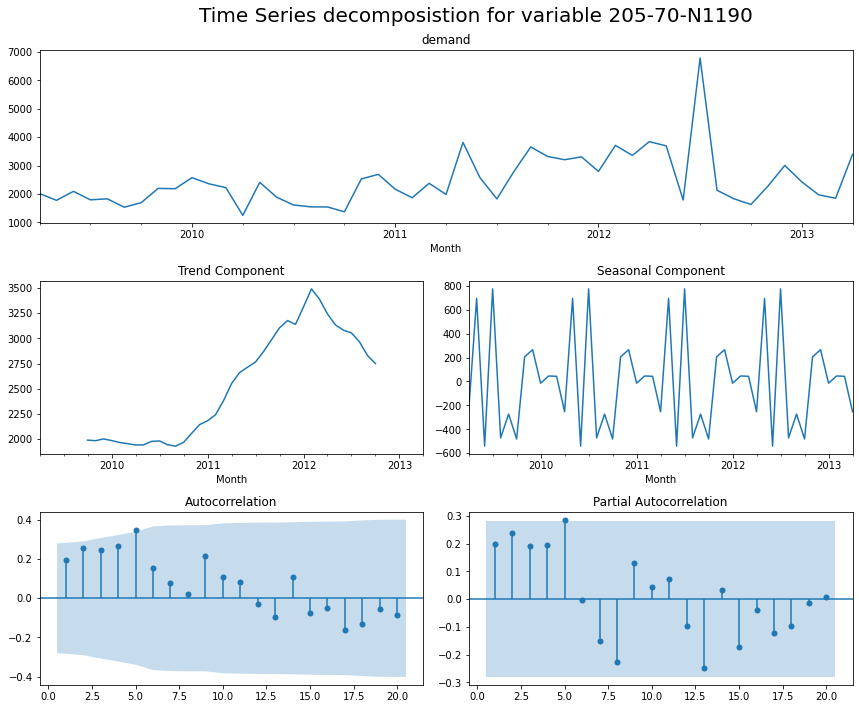

In [15]:
i=0
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- we can see that there is no significant values for lag '1' for the ACF and PACF function. 
- ACF is decreasing after 1st lag term
- From the decomposition we can observe upward trend till start of 2012 and following with a downward trend**

indicating the series is non stationary and we need to address the systematic component before we fit the model

In [16]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 205-70-N1190 variable using PMD lib: before differencing


Statsmodel                   PMD_model  \
                                ADF        KPSS             ADF   
ADF statistic              -5.49932    0.325257             NaN   
conclusion               stationary  stationary  non-stationary   
p-value                 2.08861e-06         0.1        0.476777   
should we difference?         False       False            True   

                                        
                                  KPSS  
ADF statistic                      NaN  
conclusion              not stationary  
p-value                      0.0187062  
should we difference?             True

we have conflicting hypothesis test report from pmd module and stats module, but from the plots it is clearly evident thet the series is non stationary


In [17]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 205-70-N1190:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [18]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on 205-70-N1190?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -6.29223    0.110748         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 3.57603e-08         0.1        0.01         0.1
should we difference?         False       False       False       False

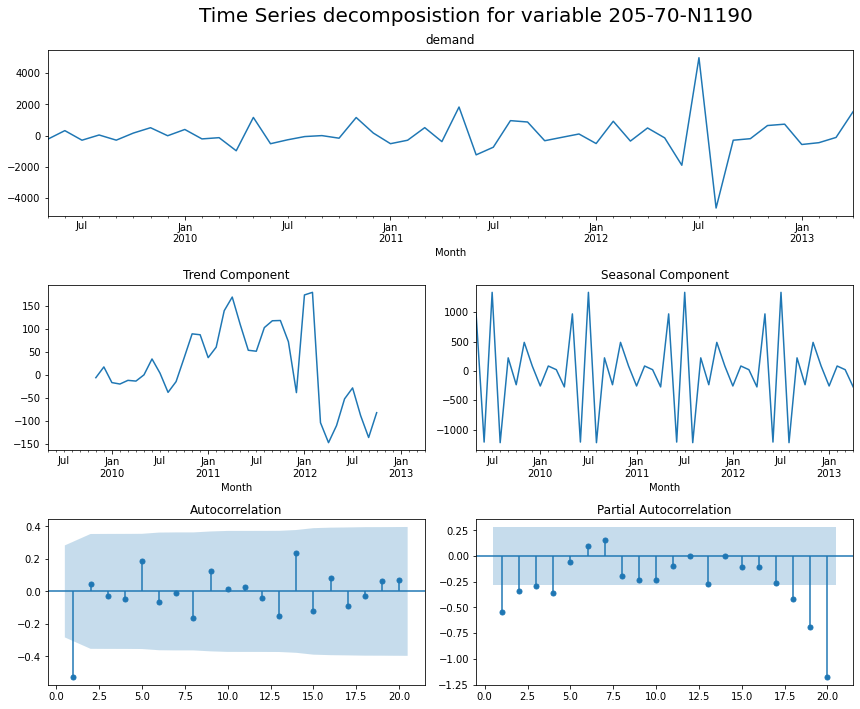

In [19]:
plot_stationarity(df_diff1,20)

**ACF has significant values after first difference is applied at lag ‘1’**

Now the trend component is stationary , what about seasonality ? 

In [20]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]])

time series before differencing on 205-70-N1190 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [21]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on 205-70-N1190 -
recommended order of seasonal differencing : 
OCSB recommendation : 1
nCH recommendation : 0


[None, None, None]

Stationary after 1 round of first-differencing on 205-70-N1190?


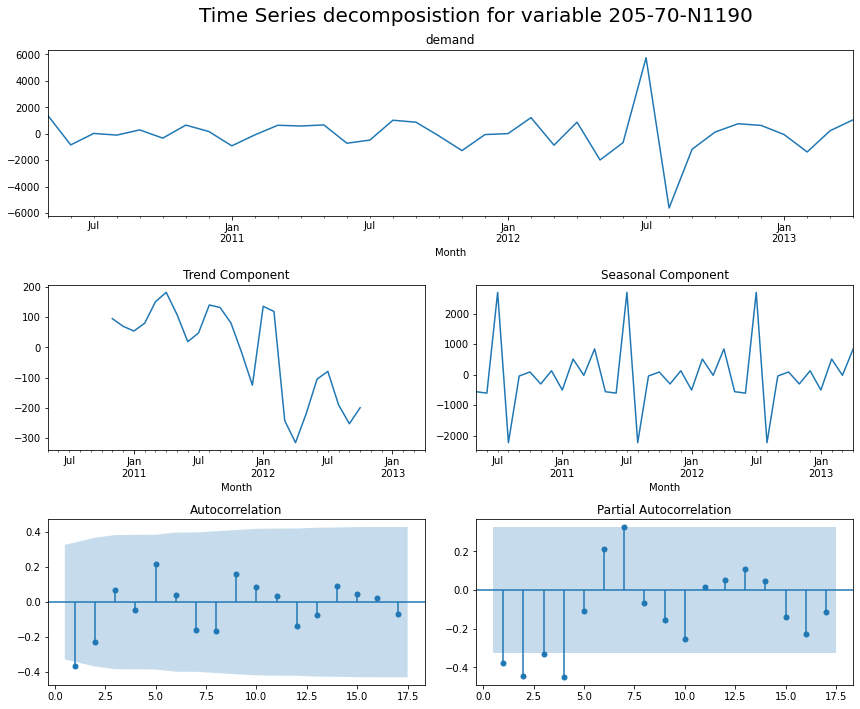

In [22]:
#seasonality differencing
n_diff=12
df_diff1S = df_diff1.diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
plot_stationarity(df_diff1S,17)

In [23]:
stationarity_check(df_diff1S)

Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -5.68741    0.201598         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 8.21843e-07         0.1        0.01         0.1
should we difference?         False       False       False       False

Stationarity check for differenced seasonal data
from the above ACF and PACF plot we can observe the q<=5 from PACF and p=0 from ACF 

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

Single Exponential smoothing is appropriate for a stable time series- one that exhibits no significant trend, cyclical, or seasonal effects-- because the use the previous movement they adapt to changes in the time series. This technique generally forecasts well with de-seasonalized monthly data

when yearly data are analyzed, single exponential smoothing often **does not do as well as** the Holt-Winter methods, where trend and seasonality may be involved

In [24]:
edf = df.loc[:,fc_ls1[i]] # data with seasonality and trend 
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 12 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:32].copy()
        test = edf[32:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong


In [25]:
best_config,best_RMSE

([None, True, None, 12, True, True], 571.5074946596628)

In [26]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

571.5074946596628 [None, True, None, 12, True, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:       455.667
1                     Mean Squared Error:      2546.046
2                Root Mean Squared Error:       571.507
3         Mean absolute percentage error:        17.437
4  Scaled Mean absolute percentage error:        18.137
5                    Mean forecast error:      2329.589
6          Normalised mean squared error:         0.901
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [27]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred['205-70-N1190'].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred['205-70-N1190'].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var1=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))

error_var1

Errors  Holts_winter  EWMA 0.17  EWMA 0.4  \
0                    Mean Absolute Error:       455.667    606.411   455.667   
1                     Mean Squared Error:      2546.046   2546.046  2546.046   
2                Root Mean Squared Error:       571.507    676.444   564.797   
3         Mean absolute percentage error:        17.437     27.767    17.636   
4  Scaled Mean absolute percentage error:        18.137     23.724    18.142   
5                    Mean forecast error:      2329.589   2880.233  2356.233   
6          Normalised mean squared error:         0.901      1.262     0.880   

   EWMA 0.8     SMA-6    SMA-12  
0   774.938   368.389   667.736  
1  2546.046  2546.046  2546.046  
2   950.097   457.664   729.496  
3    27.905    14.624    29.957  
4    34.228    14.704    25.777  
5  1711.062  2477.798  2936.271  
6     2.490     0.578     1.468

In [275]:
# grid search ARIMA parameters for time series

series = df_diff1S[:-6]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 1) RMSE=2295.998


predicted=2157.16, expected=-1170.00
predicted=2941.31, expected=132.00
predicted=2486.46, expected=758.00
predicted=579.77, expected=631.00
predicted=-35.72, expected=-62.00
predicted=11.31, expected=-1376.00
predicted=932.22, expected=234.00
predicted=440.56, expected=1058.00
Test RMSE: 1758.780


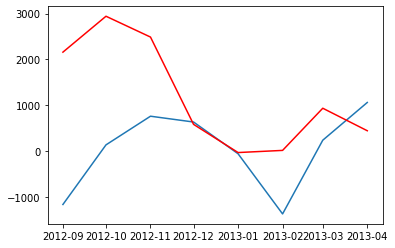

In [28]:
X=df_diff1S
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [29]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -300.040
Date:                Tue, 17 May 2022   AIC                            606.080
Time:                        14:57:24   BIC                            610.746
Sample:                             0   HQIC                           607.691
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.9549     63.824     -0.438      0.661    -153.048      97.138
ma.L1         -0.7286      0.149     -4.881      0.000      -1.021      -0.436
sigma2        1.6e+06   3.13e+05      5.117      0.0

                 0
count    35.000000
mean     37.869386
std    1291.080520
min   -2766.773739
25%    -474.095620
50%     -66.004284
75%     744.603372
max    4606.235429


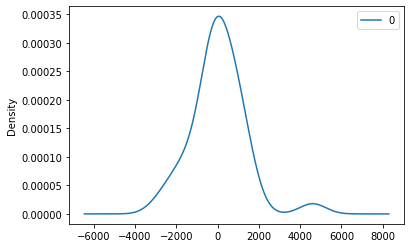

In [30]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

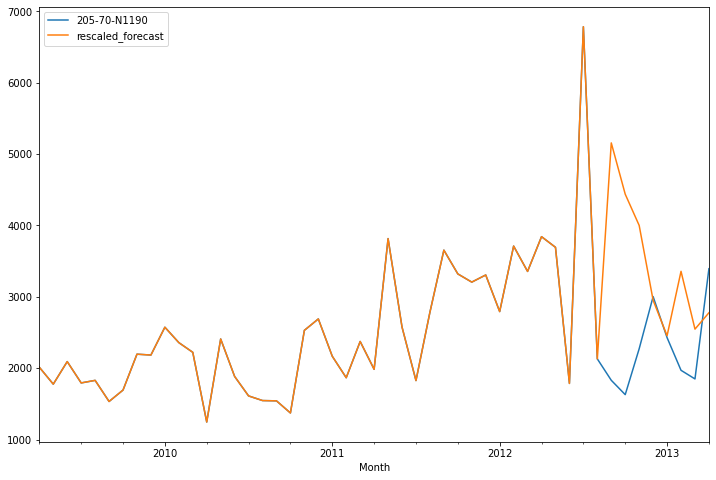

In [31]:
df_var1=pd.DataFrame(df[fc_ls1[i]])
df_var1['diff1']=df_var1.iloc[:,0].diff(1)
df_var1['Sdiff1']=df_var1.iloc[:,0].diff(1).diff(12)
df_var1['forecast']=predictions
df_var1['forecast2']=pd.concat([train,predictions])
#df_var1['rescale_ARIMA']=df_var1['diff1'].cumsum()
df_var1['rescaled_forecast']= df_var1['forecast2']+df_var1['diff1'].shift(12)+df_var1[fc_ls1[i]].shift(1)
df_var1['rescaled_forecast'].iloc[:13]=df_var1[fc_ls1[i]].iloc[:13]
df_var1.drop('forecast2',inplace=True,axis=1)
df_var1
df_var1[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [32]:
error_var1=error_var1.merge(model_eval(df[fc_ls1[i]][size:],df_var1['rescaled_forecast'][size:],'ARIMA'))
error_var1.set_index('Errors',inplace= True)
# multi index columns
error_var1.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var1.columns)])
error_var1

205-70-N1190                      \
                                       Holts_winter EWMA 0.17  EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                        455.667   606.411   455.667   
Mean Squared Error:                        2546.046  2546.046  2546.046   
Root Mean Squared Error:                    571.507   676.444   564.797   
Mean absolute percentage error:              17.437    27.767    17.636   
Scaled Mean absolute percentage error:       18.137    23.724    18.142   
Mean forecast error:                       2329.589  2880.233  2356.233   
Normalised mean squared error:                0.901     1.262     0.880   

                                                                                
                                        EWMA 0.8     SMA-6    SMA-12     ARIMA  
Errors                                                                          
Mean Absolute Error:                     774.938   368.389   667.736   506.924  
Mean Squared Error:                     2546.046  2546.046  2546.046  3186.744  
Root Mean Squared Error:                 950.097   457.664   729.496  1085.543  
Mean absolute percentage error:           27.905    14.624    29.957    26.643  
Scaled Mean absolute percentage error:    34.228    14.704    25.777    16.648  
Mean forecast error:                    1711.062  2477.798  2936.271  3591.454  
Normalised mean squared error:             2.490     0.578     1.468     0.914

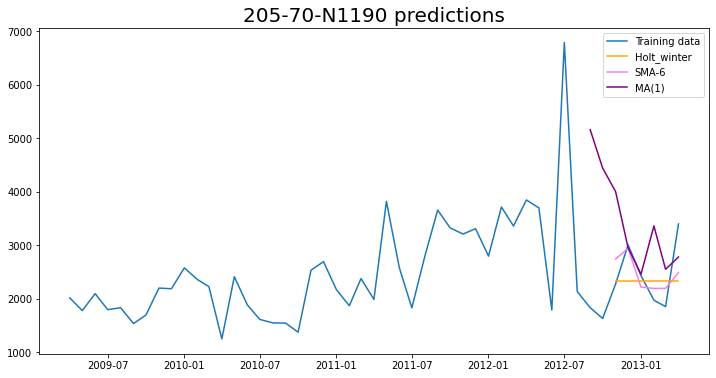

In [102]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
#plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var1['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [103]:
len(predictions)

8

In [33]:
Summary_ls.append('MA(1)')

<div class="alert alert-block alert-danger" >
Here for this variable we can opt for MA(1) as it is performing the well with the test_data (last 8 months ) on the long run this model will perfom better than HW or SMA flat predictions

### Variable2 : PC_198_27_42263 ( var 2)

PC_198_27_42263


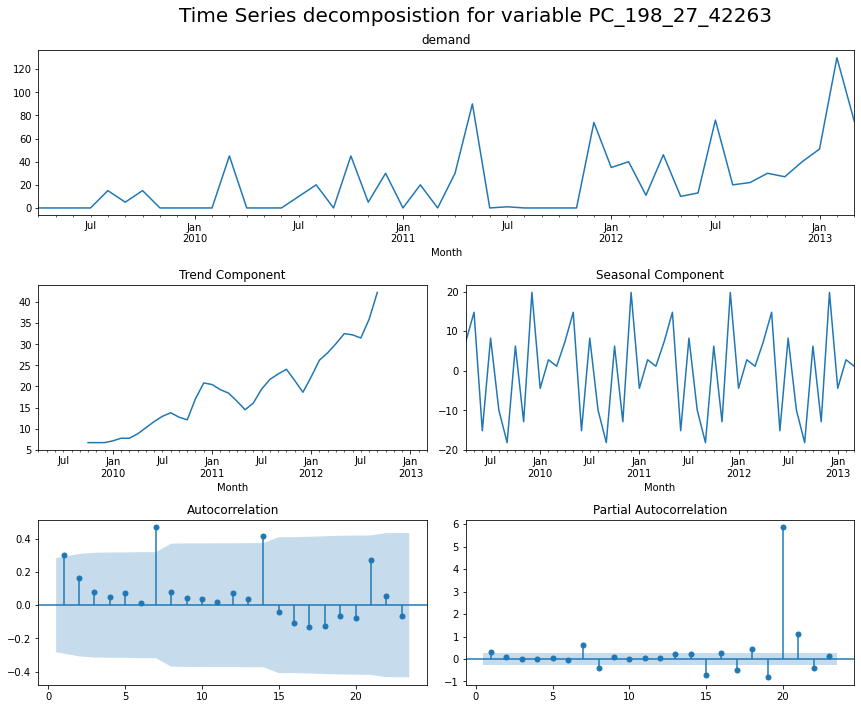

In [35]:
i=1
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],23)

**We can observe a slight trend and seasonality pattern observed, it is a clear indication that the variable is not stationary.**
- ACF, PACF have significant values at lag ‘1’
- ACF reduces significantly after lag ‘1’


##### Stationarity checks and feature engineering for variable 'PC_198_27_42263'

In [122]:
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_198_27_42263 variable using PMD lib: before differencing


Statsmodel                  \
                                               ADF            KPSS   
ADF statistic                             0.880124        0.546022   
conclusion              non-stationary (unit root)  not stationary   
p-value                                   0.992825       0.0313014   
should we difference?                         True            True   

                             PMD_model                  
                                   ADF            KPSS  
ADF statistic                      NaN             NaN  
conclusion              non-stationary  not stationary  
p-value                      0.0629335            0.01  
should we difference?             True            True

In [123]:

# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print("recommended order of first differencing for original data:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [124]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on PC_198_27_42263?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -7.24752    0.149394         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 1.81584e-10         0.1        0.01         0.1
should we difference?         False       False       False       False

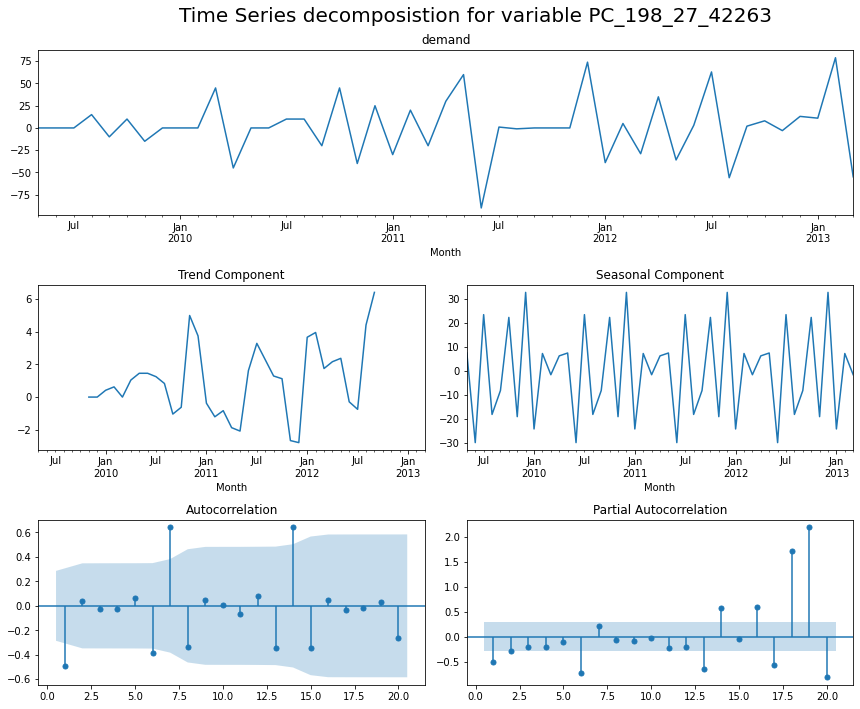

In [125]:
plot_stationarity(df_diff1, 20)

ACF has significant difference at lag ‘1’

**Trend exists in our data**

##### Seasonality test

In [126]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on PC_198_27_42263 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [127]:
# after first AND seasonal differencing: compare ADF, KPSS, OCSB and CH results
n_adf = pmd.arima.ndiffs(df_diff1, test="adf")
n_kpss = pmd.arima.ndiffs(df_diff1, test="kpss")
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff1)
n_ch = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff1)

print("after 1 round of differencing - do we need more?")
n_diffs = {"recommended additional differencing":"", "ADF first":n_adf, "KPSS first":n_kpss, 
    "OCSB seasonal":n_ocsb, "CH seasonal":n_ch}
[print(key, ":", value) for key,value in n_diffs.items()]

after 1 round of differencing - do we need more?
recommended additional differencing : 
ADF first : 0
KPSS first : 0
OCSB seasonal : 0
CH seasonal : 0


[None, None, None, None, None]

 **From the seasonality decomposistion, We can see that there is no pattern that is repeated over a period of time. Also from the seasonality differencing check pmd models suggests no seasonal exists.**

In [128]:
edf = df.loc[:,fc_ls1[i]][:-1] # data with seasonality and trend 
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 12 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:32].copy()
        test = edf[32:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something i

In [129]:
best_config,best_RMSE

(['add', False, 'add', 12, False, True], 41.70313744884088)

In [130]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

41.70313744884088 ['add', False, 'add', 12, False, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        29.660
1                     Mean Squared Error:        68.745
2                Root Mean Squared Error:        41.703
3         Mean absolute percentage error:        41.259
4  Scaled Mean absolute percentage error:        51.117
5                    Mean forecast error:        37.961
6          Normalised mean squared error:         1.146
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [131]:
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var2=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [132]:
error_var2

Errors  Holts_winter  EWMA 0.0  EWMA 0.4  \
0                    Mean Absolute Error:        29.660    27.988    30.196   
1                     Mean Squared Error:        68.745    40.060    40.060   
2                Root Mean Squared Error:        41.703    39.945    41.301   
3         Mean absolute percentage error:        41.259   100.412   113.673   
4  Scaled Mean absolute percentage error:        51.117   204.796   342.896   
5                    Mean forecast error:        37.961     0.537     4.544   
6          Normalised mean squared error:         1.146     0.871     0.931   

   EWMA 0.8   SMA-6  SMA-12  
0    30.742  20.917  26.069  
1    40.060  68.745  68.745  
2    41.573  34.335  39.886  
3   122.146  25.411  33.124  
4   420.890  31.799  42.375  
5     5.363  40.911  35.834  
6     0.943   0.777   1.048

In [133]:
# grid search ARIMA parameters for time series

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 1) RMSE=25.931


predicted=18.29, expected=3.00
predicted=14.44, expected=63.00
predicted=-43.05, expected=-56.00
predicted=12.51, expected=2.00
predicted=10.30, expected=8.00
predicted=2.84, expected=-3.00
predicted=6.05, expected=13.00
predicted=-5.61, expected=11.00
predicted=-14.42, expected=79.00
predicted=-84.67, expected=-55.00
Test RMSE: 35.834


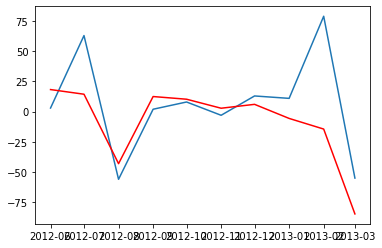

In [135]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [137]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -213.587
Date:                Tue, 17 May 2022   AIC                            433.175
Time:                        08:08:28   BIC                            438.661
Sample:                             0   HQIC                           435.230
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0412      0.531      1.961      0.050       0.000       2.082
ma.L1         -0.9987      5.118     -0.195      0.845     -11.031       9.033
sigma2       581.6962   2909.778      0.200      0.8

               0
count  46.000000
mean   -1.147456
std    24.794734
min   -27.334768
25%   -16.898351
50%    -8.793462
75%     8.182501
max    87.577437


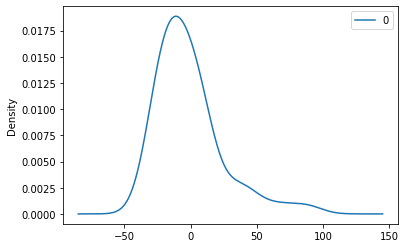

In [138]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

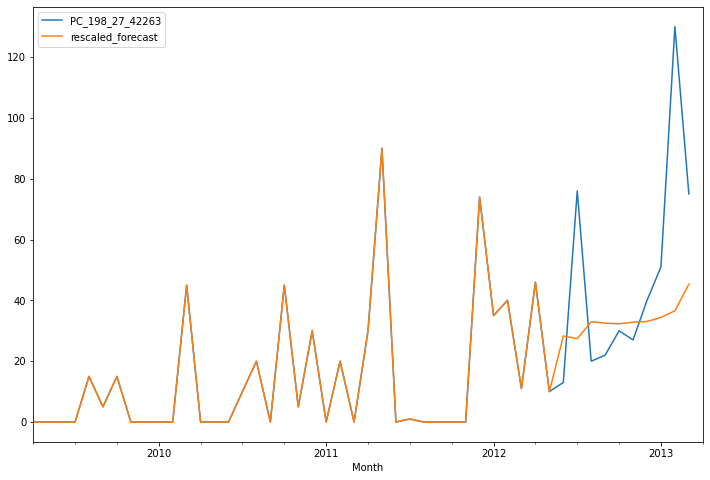

In [139]:
df_var2=pd.DataFrame(df[fc_ls1[i]])
df_var2['diff1']=df_var2.iloc[:,0].diff(1)
#df_var2['Sdiff1']=df_var2.iloc[:,0].diff(1).diff(12)
df_var2['forecast']=predictions
df_var2['forecast2']=pd.concat([train,predictions])
#df_var2['rescale_ARIMA']=df_var2['diff1'].cumsum()
df_var2['rescaled_forecast']= df_var2['forecast2']+df_var2[fc_ls1[i]].shift(1)
df_var2['rescaled_forecast'].iloc[:13]=df_var2[fc_ls1[i]].iloc[:13]
df_var2.drop('forecast2',inplace=True,axis=1)
df_var2
df_var2[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [146]:
error_var2=error_var2.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var2['rescaled_forecast'][-6:-1],'ARIMA'))
error_var2.set_index('Errors',inplace= True)
# multi index columns
error_var2.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var2.columns)])
error_var2

PC_198_27_42263                    \
                                          Holts_winter EWMA 0.0 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                            29.660   27.988   30.196   
Mean Squared Error:                             68.745   40.060   40.060   
Root Mean Squared Error:                        41.703   39.945   41.301   
Mean absolute percentage error:                 41.259  100.412  113.673   
Scaled Mean absolute percentage error:          51.117  204.796  342.896   
Mean forecast error:                            37.961    0.537    4.544   
Normalised mean squared error:                   1.146    0.871    0.931   

                                                                         
                                       EWMA 0.8   SMA-6  SMA-12   ARIMA  
Errors                                                                   
Mean Absolute Error:                     30.742  20.917  26.069  30.496  
Mean Squared Error:                      40.060  68.745  68.745  74.101  
Root Mean Squared Error:                 41.573  34.335  39.886  44.643  
Mean absolute percentage error:         122.146  25.411  33.124  36.594  
Scaled Mean absolute percentage error:  420.890  31.799  42.375  47.779  
Mean forecast error:                      5.363  40.911  35.834  36.734  
Normalised mean squared error:            0.943   0.777   1.048   1.210

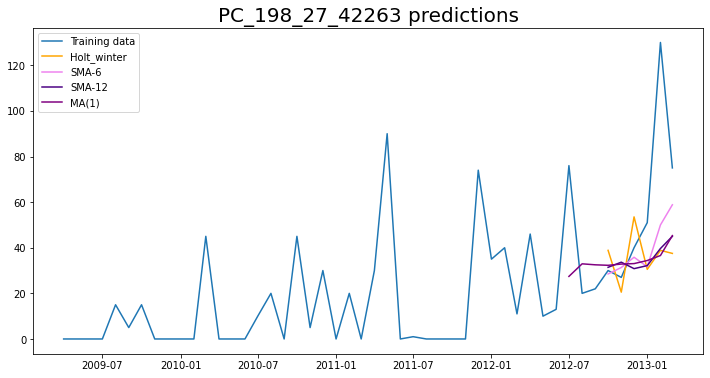

In [148]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var2['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [36]:
Summary_ls.append('SMA-6')

<div class="alert alert-block alert-danger" >
We can conclude that 'SMA-6 with low RMSE and MAPE suits best for 'PC_198_27_42263' variable

### Variable PC_203_32_51461( var 3)

PC_203_32_51461


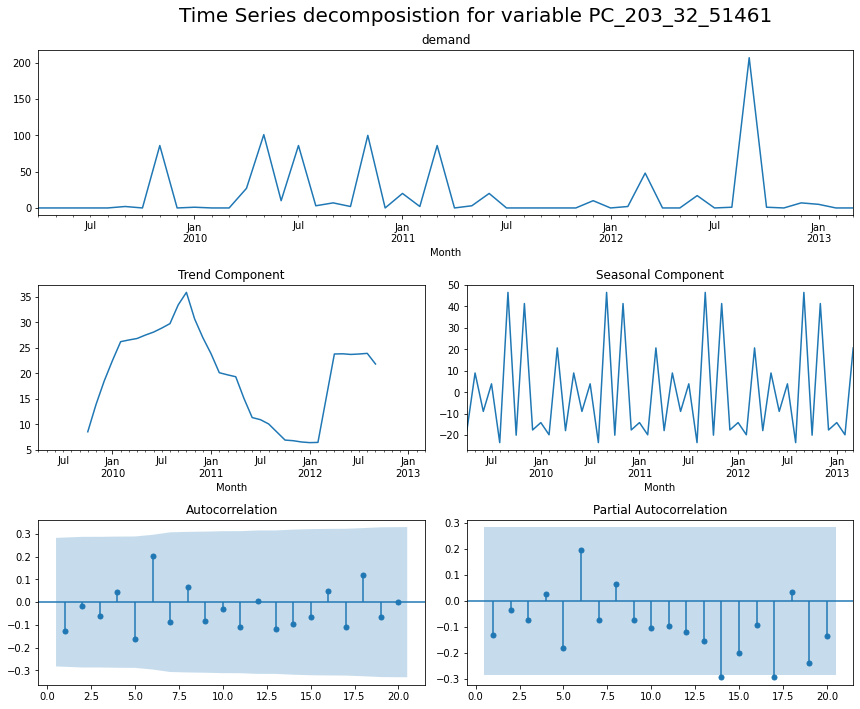

In [151]:
i=2
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],20)

**We can observe that there is no trend and NO seasonality pattern observed, it is a clear indication that the variable is  stationary.**


##### Stationarity checks and feature engineering for variable 'PC_203_32_51461'

In [152]:
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_203_32_51461 variable using PMD lib: before differencing


Statsmodel                   PMD_model            
                                ADF        KPSS             ADF        KPSS
ADF statistic              -7.64138    0.087969             NaN         NaN
conclusion               stationary  stationary  non-stationary  stationary
p-value                 1.89195e-11         0.1       0.0726869         0.1
should we difference?         False       False            True       False

we have conflicting claim of stationarity from pmd model, but the ACF and PACF all lie withing the region except for those further down at 14th lag term, It is highly unlikely that t_1 is highly correlated with t_14. We can conclude that the variable is stationary and we can use a mean model for this variable 

In [153]:
def mean_model(df,column,ma):
    df=df[column].to_frame()
    idx=df.index
    df[f'SMA_{ma}']=df[[df.columns[0]]].rolling(ma, min_periods=1).mean()
    s=df
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot_date(idx,s.iloc[:,0],'v-',color='Orange')
    ax.plot_date(idx,s[f'SMA_{ma}'],'v-',color='green')
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()
    #ax.set_xlabel('xlabel', fontsize=10)
    ax.set_ylabel('Demand ', fontsize=25)
    ax.set_title(f' Mean model for {fc_ls1[i]}',fontsize=25)
    ax.tick_params(which='minor',labelsize=20)
    ax.tick_params(which='major',labelsize=20)
    plt.legend(labels =list(s.columns), fontsize=14)
    plt.tight_layout()

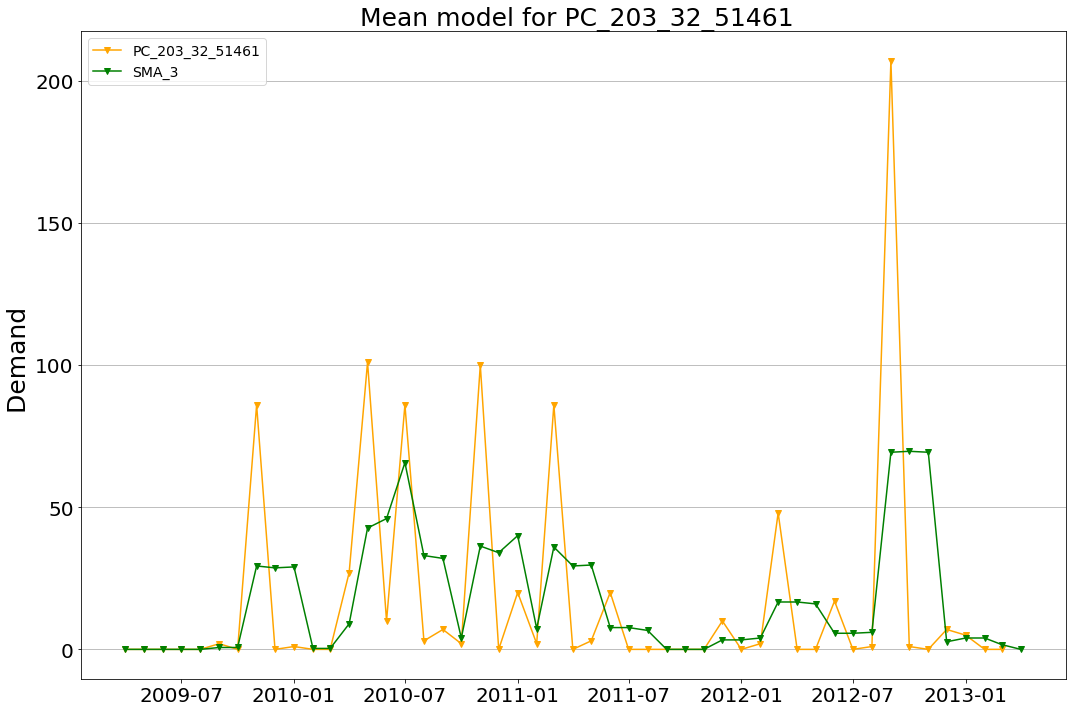

In [154]:
mean_model(df,fc_ls1[i],3)

In [155]:
mean_model_df = df[[fc_ls1[i]]]
mean_model_df[f'SMA_2']=mean_model_df.rolling(2, min_periods=1).mean()
mean_model_df[f'SMA_3']=mean_model_df.iloc[:,0].rolling(3, min_periods=1).mean()
mean_model_df[f'SMA_4']=mean_model_df.iloc[:,0].rolling(4, min_periods=1).mean()
mean_model_df[f'SMA_6']=mean_model_df.iloc[:,0].rolling(6, min_periods=1).mean()
mean_model_df[f'SMA_12']=mean_model_df.iloc[:,0].rolling(12, min_periods=1).mean()


In [156]:
error_var3= model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,1],'SMA_2').\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,2],'SMA_3')).\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,3],'SMA_4')).\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,4],'SMA_6')).\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,5],'SMA_12'))
error_var3.set_index('Errors',inplace= True)
# multi index columns
error_var3.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var3.columns)])
error_var3

PC_203_32_51461                    \
                                                 SMA_2    SMA_3    SMA_4   
Errors                                                                     
Mean Absolute Error:                             1.500   16.067   21.350   
Mean Squared Error:                              3.847    3.847    3.847   
Root Mean Squared Error:                         1.987   31.131   31.422   
Mean absolute percentage error:                    inf      inf      inf   
Scaled Mean absolute percentage error:         121.212  142.375  159.267   
Mean forecast error:                             3.309   31.142   33.609   
Normalised mean squared error:                   0.350   85.764   87.375   

                                                          
                                          SMA_6   SMA_12  
Errors                                                    
Mean Absolute Error:                     27.467   20.617  
Mean Squared Error:                       3.847    3.847  
Root Mean Squared Error:                 30.405   20.811  
Mean absolute percentage error:             inf      inf  
Scaled Mean absolute percentage error:  177.415  167.896  
Mean forecast error:                     32.926   23.072  
Normalised mean squared error:           81.810   38.326

In [37]:
Summary_ls.append('SMA-2')

<div class="alert alert-block alert-danger" >
for the variable the mean model is most appropriate as there is no trend or seasonality for the data, MA of 2 has the lowest RMSE score

### Variable 4:  PC_600_863_4210

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



PC_600_863_4210


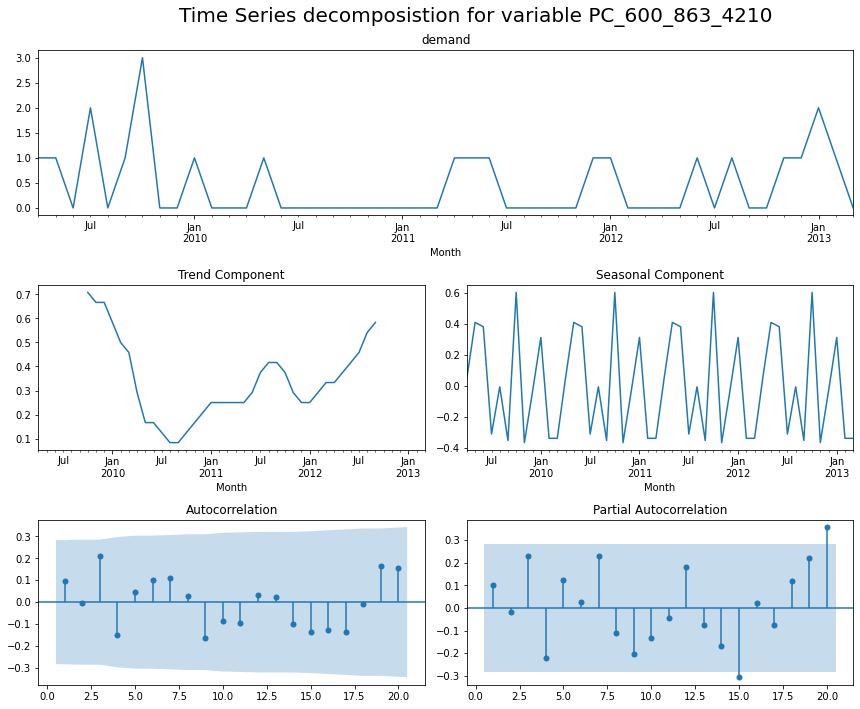

In [158]:
i=3
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the above autocorrelation plots, we see that there is no significant spike at lag 1 in ACF and PACF.

In [159]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_600_863_4210 variable using PMD lib: before differencing


Statsmodel                   PMD_model            
                                ADF        KPSS             ADF        KPSS
ADF statistic              -6.07985    0.145465             NaN         NaN
conclusion               stationary  stationary  non-stationary  stationary
p-value                 1.09886e-07         0.1        0.078477         0.1
should we difference?         False       False            True       False

we have conflicting hypothesis test report from pmd module and stats module, but from the plots it is clearly evident thet the series is non stationary


In [160]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable PC_600_863_4210:
ADF ndiff : 1
KPSS ndiff : 0


[None, None]

In [161]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]][:-1].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on PC_600_863_4210?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -5.66762    0.116399         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 9.07504e-07         0.1        0.01         0.1
should we difference?         False       False       False       False

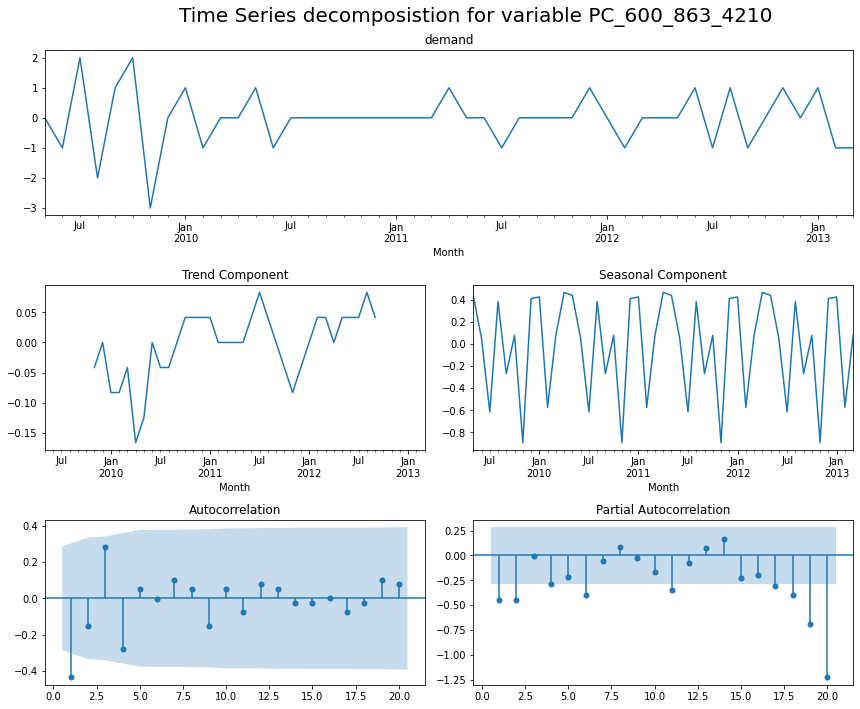

In [162]:
plot_stationarity(df_diff1,20)

**After applying first differencing, the unit root test results become significant, signifying that there is trend in the
series.**

Now the trend component is stationary , what about seasonality ? 

In [163]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on PC_600_863_4210 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [164]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on PC_600_863_4210 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**there is no recomendation for seasonal differencing, and we can conclude that there is no seasonality in our differenced data.**

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

Single Exponential smoothing is appropriate for a stable time series- one that exhibits no significant trend, cyclical, or seasonal effects-- because the use the previous movement they adapt to changes in the time series. This technique generally forecasts well with de-seasonalized monthly data

when yearly data are analyzed, single exponential smoothing often **does not do as well as** the Holt-Winter methods, where trend and seasonality may be involved

In [165]:
edf = df.loc[:,fc_ls1[i]][:-1] # data with seasonality and trend 
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 12 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:32].copy()
        test = edf[32:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model
0
['add', True, 'add', 12, True, True]
something is wrong
1
['add', True, 'add', 12, True, False]
something is wrong
2
['add', True, 'add', 12, False, True]
0.981119921779462
3
['add', True, 'add', 12, False, False]
0.9811062799071432
4
['add', True, 'mul', 12, True, True]
something is wrong
5
['add', True, 'mul', 12, True, False]
something is wrong
6
['add', True, 'mul', 12, False, True]
something is wrong
7
['add', True, 'mul', 12, False, False]
something is wrong
8
['add', True, None, 12, True, True]
something is wrong
9
['add', True, None, 12, True, False]
something is wrong
10
['add', True, None, 12, False, True]
0.902622416480965
11
['add', True, None, 12, False, False]
0.9025927803299477
12
['add', False, 'add', 12, True, True]
something is wrong
13
['add', False, 'add', 12, True, False]
something is wrong
14
['add', False, 'add', 12, False, True]
1.095878706839787
15
['add', False, 'add', 12, False, False]
1.0958659495462841
16
['add', False, 'mul', 12, True

In [166]:
best_config,best_RMSE

([None, True, None, 12, False, False], 0.8098738743226855)

In [177]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

0.8098738743226855 [None, True, None, 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:         0.698
1                     Mean Squared Error:         1.080
2                Root Mean Squared Error:         0.810
3         Mean absolute percentage error:           inf
4  Scaled Mean absolute percentage error:       131.152
5                    Mean forecast error:         0.405
6          Normalised mean squared error:         1.157
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [178]:
#EWMA fit on stationary data
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf
#fit SMA ON ORIGINAL DATA
df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var4=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [179]:
error_var4

Errors  Holts_winter  EWMA 0.0  EWMA 0.4  \
0                    Mean Absolute Error:         0.698     0.675     0.742   
1                     Mean Squared Error:         1.080     0.816     0.816   
2                Root Mean Squared Error:         0.810     0.817     0.847   
3         Mean absolute percentage error:           inf       inf       inf   
4  Scaled Mean absolute percentage error:       131.152   200.159   214.222   
5                    Mean forecast error:         0.405     0.024     0.225   
6          Normalised mean squared error:         1.157     0.834     0.897   

   EWMA 0.8    SMA-6   SMA-12  
0     0.889    0.583    0.667  
1     0.816    1.080    1.080  
2     1.053    0.670    0.770  
3       inf      inf      inf  
4   412.120  105.645  122.890  
5     0.666    0.670    0.481  
6     1.387    0.792    1.046

In [180]:
# grid search ARIMA parameters for time series

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(8, 0, 2) RMSE=0.422


predicted=0.28, expected=1.00
predicted=-0.30, expected=-1.00
predicted=0.58, expected=1.00
predicted=-0.49, expected=-1.00
predicted=-0.68, expected=0.00
predicted=0.14, expected=1.00
predicted=-0.98, expected=0.00
predicted=-0.08, expected=1.00
predicted=-0.47, expected=-1.00
predicted=0.04, expected=-1.00
Test RMSE: 0.784


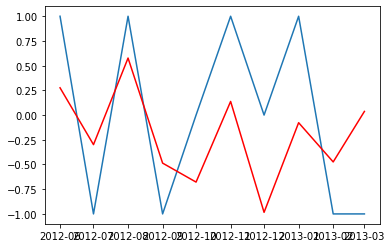

In [181]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(8,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [182]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(8, 0, 2)   Log Likelihood                 -40.841
Date:                Tue, 17 May 2022   AIC                            105.682
Time:                        08:29:46   BIC                            127.625
Sample:                             0   HQIC                           113.902
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.039     -0.068      0.945      -0.080       0.075
ar.L1         -0.0638      0.430     -0.148      0.882      -0.907       0.779
ar.L2         -0.7702      0.370     -2.083      0.0

               0
count  46.000000
mean    0.016249
std     0.625355
min    -1.350520
25%    -0.411306
50%    -0.029413
75%     0.469992
max     1.719076


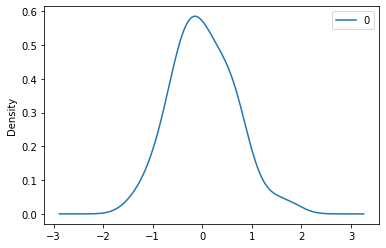

In [183]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

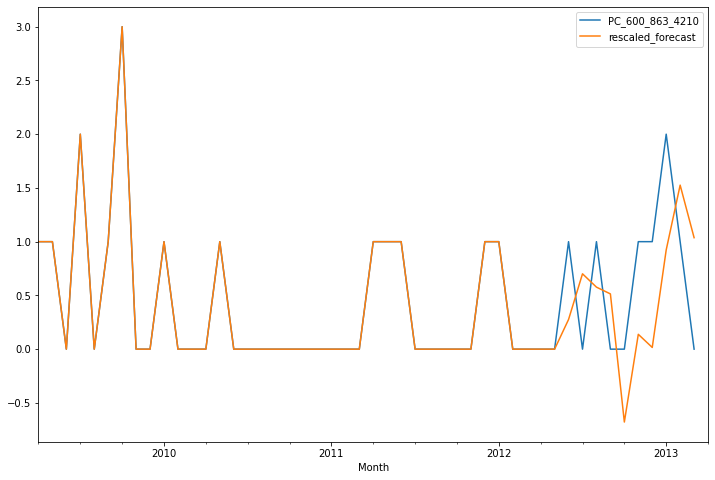

In [184]:
df_var4=pd.DataFrame(df[fc_ls1[i]])
df_var4['diff1']=df_var4.iloc[:,0].diff(1)
#df_var4['Sdiff1']=df_var4.iloc[:,0].diff(1).diff(12)
df_var4['forecast']=predictions
df_var4['forecast2']=pd.concat([train,predictions])
#df_var4['rescale_ARIMA']=df_var4['diff1'].cumsum()
df_var4['rescaled_forecast']= df_var4['forecast2']+df_var4[fc_ls1[i]].shift(1)
df_var4['rescaled_forecast'].iloc[:13]=df_var4[fc_ls1[i]].iloc[:13]
df_var4.drop('forecast2',inplace=True,axis=1)
df_var4
df_var4[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [185]:
error_var4=error_var4.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var4['rescaled_forecast'][-6:-1],'ARIMA'))
error_var4.set_index('Errors',inplace= True)
# multi index columns
error_var4.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var4.columns)])
error_var4

PC_600_863_4210                    \
                                          Holts_winter EWMA 0.0 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                             0.698    0.675    0.742   
Mean Squared Error:                              1.080    0.816    0.816   
Root Mean Squared Error:                         0.810    0.817    0.847   
Mean absolute percentage error:                    inf      inf      inf   
Scaled Mean absolute percentage error:         131.152  200.159  214.222   
Mean forecast error:                             0.405    0.024    0.225   
Normalised mean squared error:                   1.157    0.834    0.897   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                      0.889    0.583    0.667    0.897  
Mean Squared Error:                       0.816    1.080    1.080    1.183  
Root Mean Squared Error:                  1.053    0.670    0.770    0.919  
Mean absolute percentage error:             inf      inf      inf      inf  
Scaled Mean absolute percentage error:  412.120  105.645  122.890  132.107  
Mean forecast error:                      0.666    0.670    0.481    0.925  
Normalised mean squared error:            1.387    0.792    1.046    1.689

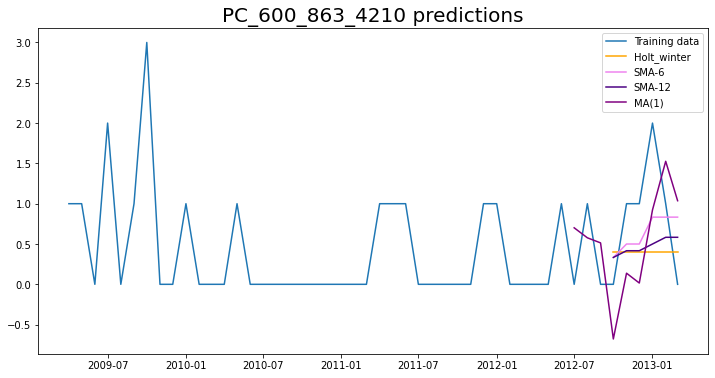

In [188]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var4['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [38]:
Summary_ls.append('AR(8) and MA(2)')

<div class="alert alert-block alert-danger" >
For the variable 'PC_600_863_4210' we could achieve lower RMSE with AR of 8 and MA of 2 , we can conclude tht ARMA model works well for the variable

### Variable 5:  PC_6735_61_3410

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



PC_6735_61_3410


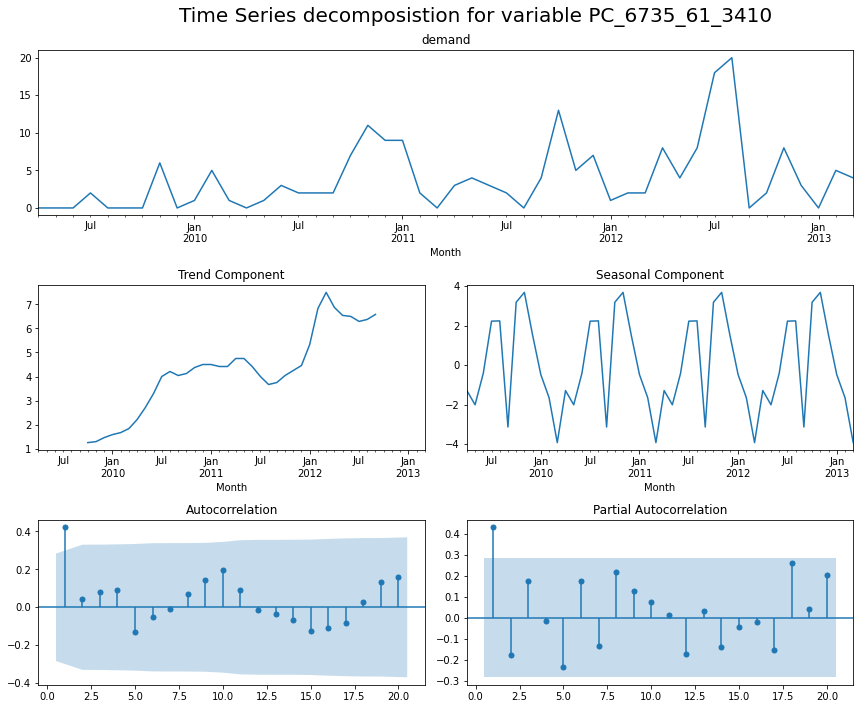

In [201]:
i=4
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the autocorrelation plots, we see that there is a significant spike at lag 1 in ACF and PACF which shows there could be trend in the series and there doesn’t appear to be any significant spikes at lag S (signifying no trace of seasonality in the series).

In [202]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_6735_61_3410 variable using PMD lib: before differencing


Statsmodel                   PMD_model  \
                                ADF        KPSS             ADF   
ADF statistic               -4.3169    0.406281             NaN   
conclusion               stationary  stationary  non-stationary   
p-value                 0.000415205    0.074448       0.0991003   
should we difference?         False       False            True   

                                        
                                  KPSS  
ADF statistic                      NaN  
conclusion              not stationary  
p-value                      0.0477593  
should we difference?             True

we have conflicting hypothesis test report from pmd module and stats module, but from the plots it is clearly evident that the series is non stationary


In [203]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable PC_6735_61_3410:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [204]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]][:-1].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on PC_6735_61_3410?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -4.31168    0.145052         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 0.000423972         0.1   0.0182342         0.1
should we difference?         False       False       False       False

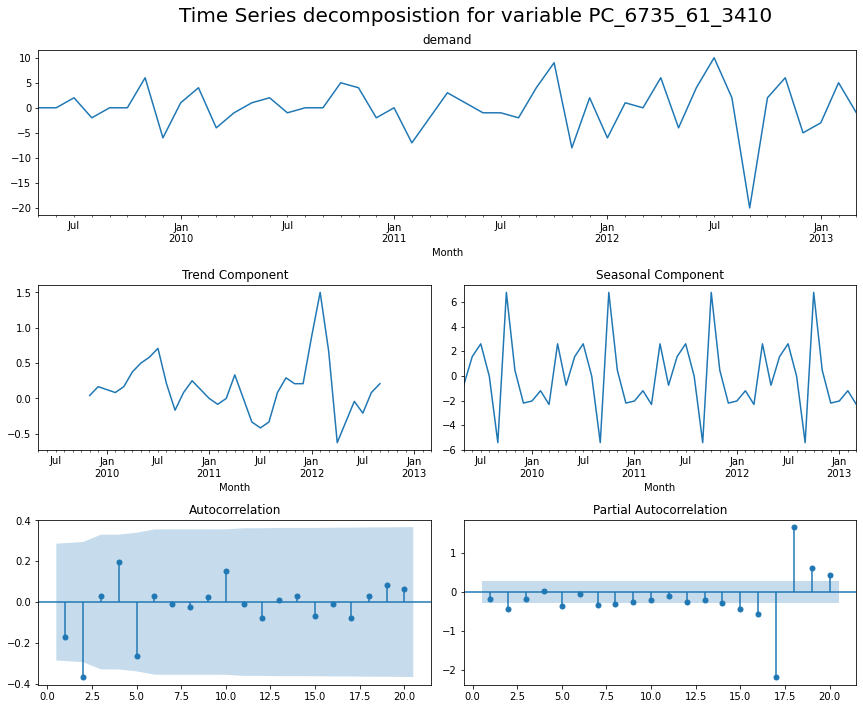

In [205]:
plot_stationarity(df_diff1,20)

**After applying first differencing, the unit root test results become significant, signifying that there is trend in the
series.**

Now the trend component is stationary , what about seasonality ? 

In [206]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on PC_6735_61_3410 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [207]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on PC_6735_61_3410 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**there is no recomendation for seasonal differencing, and we can conclude that there is no seasonality in our differenced data.**

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

Single Exponential smoothing is appropriate for a stable time series- one that exhibits no significant trend, cyclical, or seasonal effects-- because the use the previous movement they adapt to changes in the time series. This technique generally forecasts well with de-seasonalized monthly data

when yearly data are analyzed, single exponential smoothing often **does not do as well as** the Holt-Winter methods, where trend and seasonality may be involved

In [198]:
edf = df.loc[:,fc_ls1[i]][:-1] # data with seasonality and trend 
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 12 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:32].copy()
        test = edf[32:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model
0
['add', True, 'add', 12, True, True]
something is wrong
1
['add', True, 'add', 12, True, False]
something is wrong
2
['add', True, 'add', 12, False, True]
6.238927475450811
3
['add', True, 'add', 12, False, False]
6.238933943730455
4
['add', True, 'mul', 12, True, True]
something is wrong
5
['add', True, 'mul', 12, True, False]
something is wrong
6
['add', True, 'mul', 12, False, True]
something is wrong
7
['add', True, 'mul', 12, False, False]
something is wrong
8
['add', True, None, 12, True, True]
something is wrong
9
['add', True, None, 12, True, False]
something is wrong
10
['add', True, None, 12, False, True]
5.367026019937217
11
['add', True, None, 12, False, False]
5.36702603379393
12
['add', False, 'add', 12, True, True]
something is wrong
13
['add', False, 'add', 12, True, False]
something is wrong
14
['add', False, 'add', 12, False, True]
6.46518417031762
15
['add', False, 'add', 12, False, False]
6.465188013069734
16
['add', False, 'mul', 12, True, Tru

In [208]:
best_config,best_RMSE

([None, True, None, 12, False, False], 5.025568055570011)

In [209]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

5.025568055570011 [None, True, None, 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:         4.363
1                     Mean Squared Error:         4.435
2                Root Mean Squared Error:         5.026
3         Mean absolute percentage error:           inf
4  Scaled Mean absolute percentage error:        87.550
5                    Mean forecast error:         8.029
6          Normalised mean squared error:         3.383
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [210]:
#EWMA fit on stationary data
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf
#fit SMA ON ORIGINAL DATA
df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var5=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [211]:
error_var5

Errors  Holts_winter  EWMA 0.0  EWMA 0.4  \
0                    Mean Absolute Error:         4.363     3.667     6.447   
1                     Mean Squared Error:         4.435     4.082     4.082   
2                Root Mean Squared Error:         5.026     4.082     7.602   
3         Mean absolute percentage error:           inf   100.000   231.218   
4  Scaled Mean absolute percentage error:        87.550   200.000  2354.129   
5                    Mean forecast error:         8.029     0.000     5.780   
6          Normalised mean squared error:         3.383     0.856     2.969   

   EWMA 0.8   SMA-6  SMA-12  
0    16.005   3.556   3.250  
1     4.082   4.435   4.435  
2    16.504   4.298   3.670  
3   613.519     inf     inf  
4   253.699  82.455  78.441  
5    15.338   6.918   6.474  
6    13.992   2.474   1.804

In [213]:
# grid search ARIMA parameters for time series

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 2) RMSE=6.279


predicted=0.81, expected=4.00
predicted=-1.13, expected=10.00
predicted=-6.68, expected=2.00
predicted=-7.60, expected=-20.00
predicted=3.47, expected=2.00
predicted=5.29, expected=6.00
predicted=0.25, expected=-5.00
predicted=2.51, expected=-3.00
predicted=4.81, expected=5.00
predicted=2.24, expected=-1.00
Test RMSE: 6.590


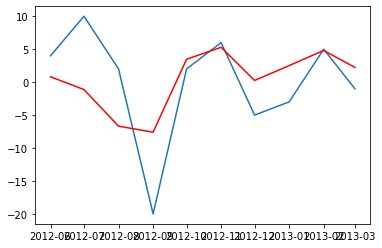

In [214]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [215]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -129.285
Date:                Tue, 17 May 2022   AIC                            266.570
Time:                        08:42:34   BIC                            273.884
Sample:                             0   HQIC                           269.310
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1345      0.077      1.741      0.082      -0.017       0.286
ma.L1         -0.5578     34.046     -0.016      0.987     -67.287      66.172
ma.L2         -0.4419     15.212     -0.029      0.9

               0
count  46.000000
mean    0.141695
std     3.992883
min   -10.860846
25%    -2.224888
50%    -0.157757
75%     2.561348
max    10.370257


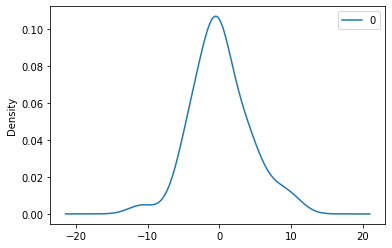

In [216]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

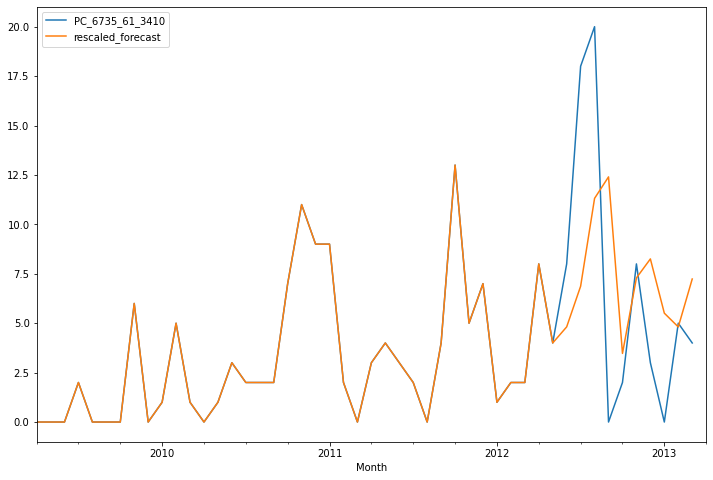

In [217]:
df_var5=pd.DataFrame(df[fc_ls1[i]])
df_var5['diff1']=df_var5.iloc[:,0].diff(1)
#df_var5['Sdiff1']=df_var5.iloc[:,0].diff(1).diff(12)
df_var5['forecast']=predictions
df_var5['forecast2']=pd.concat([train,predictions])
#df_var5['rescale_ARIMA']=df_var5['diff1'].cumsum()
df_var5['rescaled_forecast']= df_var5['forecast2']+df_var5[fc_ls1[i]].shift(1)
df_var5['rescaled_forecast'].iloc[:13]=df_var5[fc_ls1[i]].iloc[:13]
df_var5.drop('forecast2',inplace=True,axis=1)
df_var5
df_var5[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [218]:
error_var5=error_var5.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var5['rescaled_forecast'][-6:-1],'ARIMA'))
error_var5.set_index('Errors',inplace= True)
# multi index columns
error_var5.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var5.columns)])
error_var5

PC_6735_61_3410                     \
                                          Holts_winter EWMA 0.0  EWMA 0.4   
Errors                                                                      
Mean Absolute Error:                             4.363    3.667     6.447   
Mean Squared Error:                              4.435    4.082     4.082   
Root Mean Squared Error:                         5.026    4.082     7.602   
Mean absolute percentage error:                    inf  100.000   231.218   
Scaled Mean absolute percentage error:          87.550  200.000  2354.129   
Mean forecast error:                             8.029    0.000     5.780   
Normalised mean squared error:                   3.383    0.856     2.969   

                                                                         
                                       EWMA 0.8   SMA-6  SMA-12   ARIMA  
Errors                                                                   
Mean Absolute Error:                     16.005   3.556   3.250   2.979  
Mean Squared Error:                       4.082   4.435   4.435   4.775  
Root Mean Squared Error:                 16.504   4.298   3.670   3.713  
Mean absolute percentage error:         613.519     inf     inf     inf  
Scaled Mean absolute percentage error:  253.699  82.455  78.441  72.819  
Mean forecast error:                     15.338   6.918   6.474   6.739  
Normalised mean squared error:           13.992   2.474   1.804   1.622

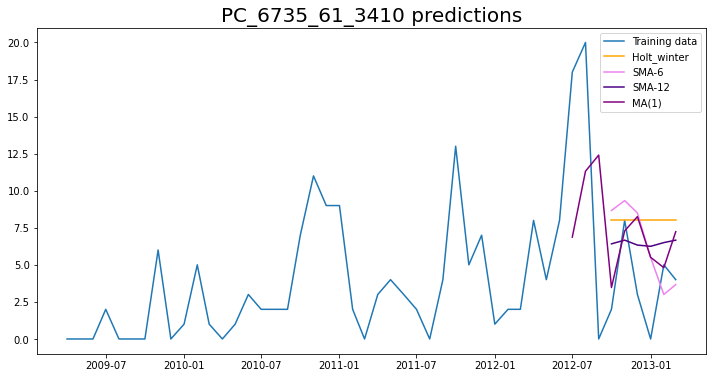

In [219]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var5['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [39]:
Summary_ls.append('ARMA(8)')

<div class="alert alert-block alert-danger" >
For the variable 'PC_6735_61_3410' we could achieve lower RMSE of 3.7 with  AR(0) and MA(8) of alpha 0.8 

### Variable 6:  D30141135

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



D30141135


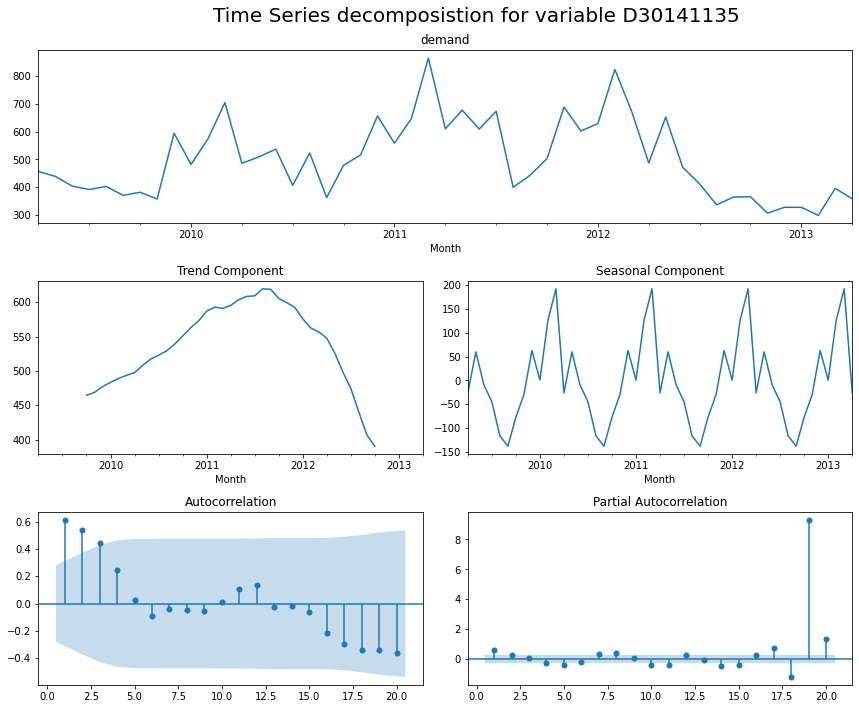

In [287]:
i=5
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the pattern observed above, Trend and Seasonality seems to be missing.
- Checking the other parameters to validate the same. 
- Viewing the Autocorrelation Plots before any differencing is applied. ACF plot seems to be gradually decreasing. 
- ACF and PACF have significant lag 1 valuee. 
- There is no significant vale for the 12th lag. Looks like seasonality does not exist.

In [222]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]}")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on D30141135


Statsmodel              \
                                               ADF        KPSS   
ADF statistic                             -1.12681    0.154822   
conclusion              non-stationary (unit root)  stationary   
p-value                                   0.704261         0.1   
should we difference?                         True       False   

                             PMD_model              
                                   ADF        KPSS  
ADF statistic                      NaN         NaN  
conclusion              non-stationary  stationary  
p-value                       0.552942         0.1  
should we difference?             True       False

we have conflicting hypothesis test report from   at ADF test from pmd module and stats module, but from the plots it is clearly evident that the series is non stationary


In [295]:
# ADF and KPSS tests after differencing:

n_diff = 1
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on D30141135?


Statsmodel                   PMD_model            
                                ADF        KPSS             ADF        KPSS
ADF statistic              -4.62854     0.22552             NaN         NaN
conclusion               stationary  stationary  non-stationary  stationary
p-value                 0.000114398         0.1        0.184397         0.1
should we difference?         False       False            True       False

After first differencing the varible is still not stationary this could be spurious as the data looks stationary lets look at the plot

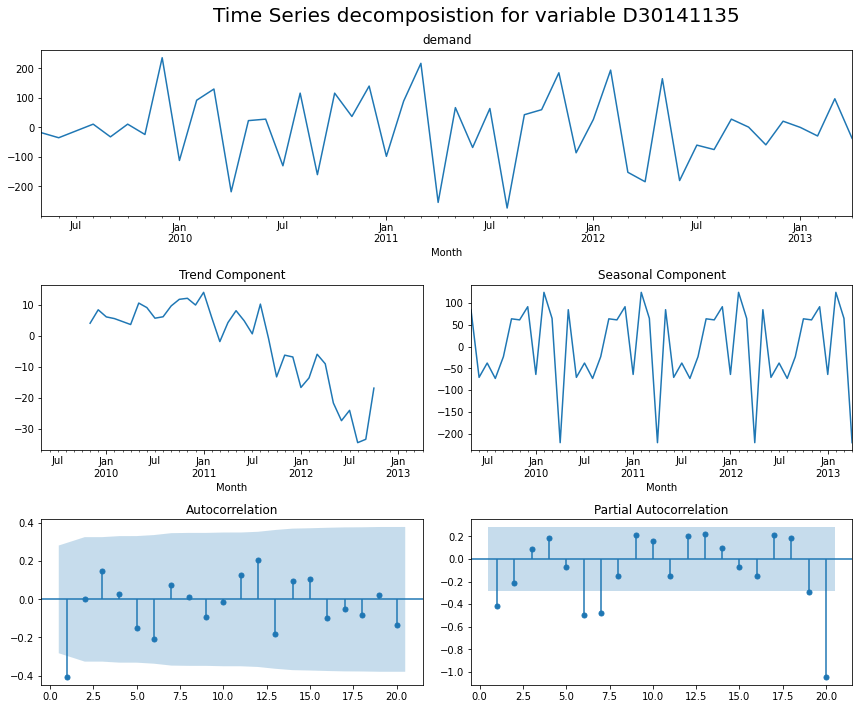

In [250]:
plot_stationarity(df_diff1,20)

The ACF now has few significant values after first differencing.

what about seasonality ? 

In [251]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on D30141135 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [252]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on D30141135 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**there is no recomendation for seasonal differencing, and we can conclude that there is no seasonality in our differenced data.
Since the time series is a Non Stationary Time Series, we will be applying grid search ARMA(p,q) models.**

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

### forecasts for variable D30141135

In [288]:
cfg_list = exp_smoothing_configs(seasonal=[0])

In [289]:
edf = df[fc_ls1[i]]
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 6 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:27].copy()
        test = edf[27:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong
something is wrong


In [290]:
best_RMSE,best_config

(39.5501319316505, ['add', False, None, 0, False, True])

In [291]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df[fc_ls1[i]].copy(), pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

39.5501319316505 ['add', False, None, 0, False, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        36.376
1                     Mean Squared Error:       337.766
2                Root Mean Squared Error:        39.550
3         Mean absolute percentage error:        11.095
4  Scaled Mean absolute percentage error:        10.630
5                    Mean forecast error:       353.911
6          Normalised mean squared error:         1.209
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [292]:
#EWMA fit on stationary data
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf
#fit SMA ON ORIGINAL DATA
df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var6=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [293]:
error_var6

Errors  Holts_winter  EWMA 0.0  EWMA 0.4  \
0                    Mean Absolute Error:        36.376    40.500    40.500   
1                     Mean Squared Error:       337.766    50.894    50.894   
2                Root Mean Squared Error:        39.550    50.890    53.208   
3         Mean absolute percentage error:        11.095       inf       inf   
4  Scaled Mean absolute percentage error:        10.630   198.509   415.363   
5                    Mean forecast error:       353.911     2.166    16.732   
6          Normalised mean squared error:         1.209     0.834     0.911   

   EWMA 0.8    SMA-6   SMA-12  
0    41.266   44.056  132.153  
1    50.894  339.016  339.016  
2    50.998   49.509  147.233  
3       inf   12.966   40.656  
4   204.733   12.366   32.502  
5     2.297  363.565  472.113  
6     0.837    1.795   15.876

In [296]:
# grid search diffrenced data for ARIMA parameters
series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(6, 1, 2) RMSE=104.321


for the differenced data the model is suggesting one more differencing , but before we do that let us check for the original variable, what p,d,q values the grid search suggests

In [267]:
# grid search ARIMA parameters for time series

series = df[fc_ls1[i]][:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(6, 0, 2) RMSE=107.787


on the original data the grid search is suggesting no more differencing and the data is stationary. From this we can conclude the data is stationary

predicted=502.53, expected=412.00
predicted=429.76, expected=337.00
predicted=390.67, expected=365.00
predicted=375.46, expected=366.00
predicted=393.75, expected=307.00
predicted=438.37, expected=328.00
predicted=435.38, expected=328.00
predicted=385.86, expected=299.00
predicted=323.97, expected=396.00
predicted=402.26, expected=359.00
Test RMSE: 79.617


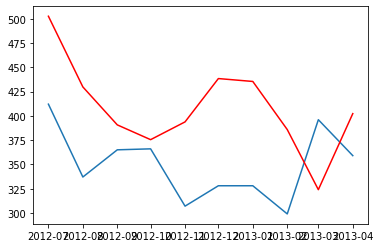

In [297]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(6,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [298]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(6, 0, 2)   Log Likelihood                -282.175
Date:                Tue, 17 May 2022   AIC                            584.349
Time:                        09:35:42   BIC                            603.061
Sample:                             0   HQIC                           591.421
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        504.0898     44.953     11.214      0.000     415.984     592.196
ar.L1          0.6951      0.196      3.540      0.000       0.310       1.080
ar.L2         -0.4512      0.280     -1.613      0.1

                0
count   48.000000
mean    -0.025324
std     85.602337
min   -148.517707
25%    -62.006926
50%    -21.033332
75%     49.034818
max    229.409062


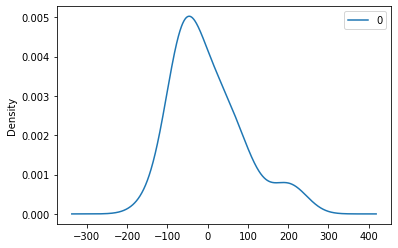

In [299]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

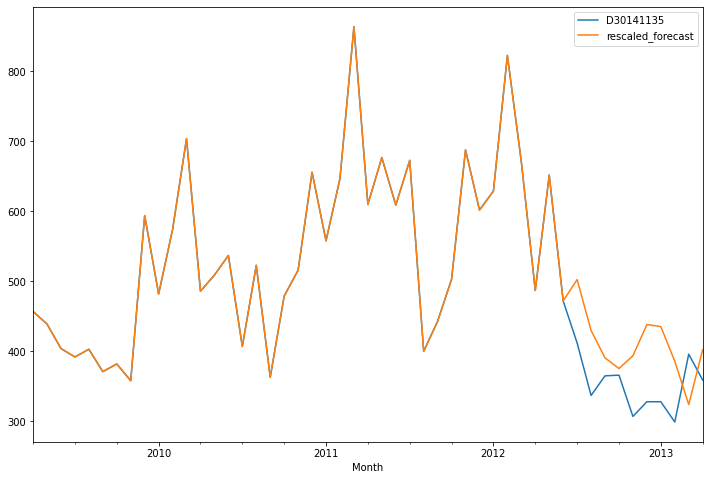

In [300]:
df_var6=pd.DataFrame(df[fc_ls1[i]])
#df_var6['diff1']=df_var6.iloc[:,0].diff(1)
#df_var6['Sdiff1']=df_var6.iloc[:,0].diff(1).diff(12)
df_var6['forecast']=predictions
df_var6['forecast2']=pd.concat([train,predictions])
#df_var6['rescale_ARIMA']=df_var6['diff1'].cumsum()
df_var6['rescaled_forecast']= df_var6['forecast2']#+df_var6[fc_ls1[i]].shift(1)
#df_var6['rescaled_forecast'].iloc[:13]=df_var6[fc_ls1[i]].iloc[:13]
df_var6.drop('forecast2',inplace=True,axis=1)
df_var6
df_var6[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [301]:
error_var6=error_var6.merge(model_eval(df[fc_ls1[i]][-6:],df_var6['rescaled_forecast'][-6:],'ARIMA'))
error_var6.set_index('Errors',inplace= True)
# multi index columns
error_var6.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var6.columns)])
error_var6

D30141135                    \
                                       Holts_winter EWMA 0.0 EWMA 0.4   
Errors                                                                  
Mean Absolute Error:                         36.376   40.500   40.500   
Mean Squared Error:                         337.766   50.894   50.894   
Root Mean Squared Error:                     39.550   50.890   53.208   
Mean absolute percentage error:              11.095      inf      inf   
Scaled Mean absolute percentage error:       10.630  198.509  415.363   
Mean forecast error:                        353.911    2.166   16.732   
Normalised mean squared error:                1.209    0.834    0.911   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     41.266   44.056  132.153   84.442  
Mean Squared Error:                      50.894  339.016  339.016  337.766  
Root Mean Squared Error:                 50.998   49.509  147.233   87.409  
Mean absolute percentage error:             inf   12.966   40.656   25.656  
Scaled Mean absolute percentage error:  204.733   12.366   32.502   23.073  
Mean forecast error:                      2.297  363.565  472.113  398.418  
Normalised mean squared error:            0.837    1.795   15.876    5.907

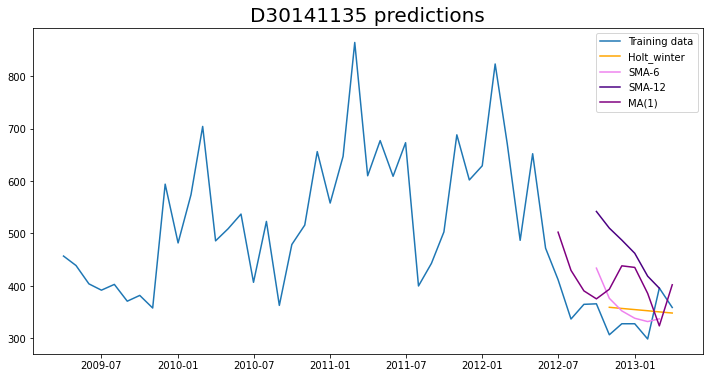

In [302]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var6['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [40]:
Summary_ls.append('AR(6) and MA(2)')

<div class="alert alert-block alert-danger" >
For the variable 'D30141135' we could achieve lower RMSE with  Holts-winter model, or AR(6) and MA(2) we can conclude tht either of models works well for the variable. HW is more flat predictions than ARMA, And It can be seen that the demand is likely to be dropping in the near future for the spare part D30141135.

### Variable 7:  600-181-6740I.

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



600-181-6740I.


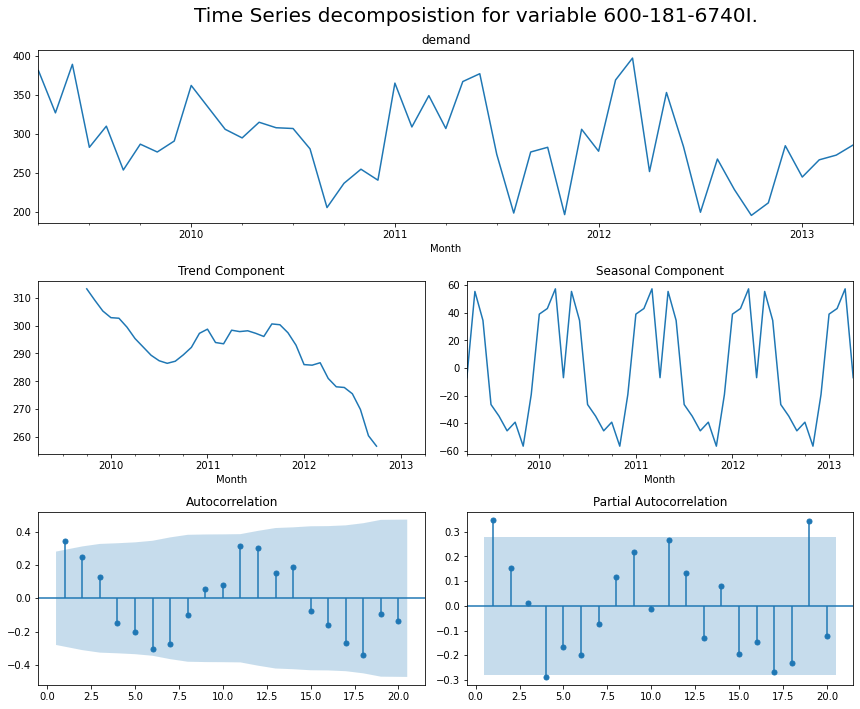

In [307]:
i=6
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Viewing the Autocorrelation Plots before any differencing is applied. ACF plot seems to be gradually decreasing. 
- ACF and PACF have significant lag 1 values. 
- There is no significant vale for the 12th lag. Looks like seasonality does not exist.

In [308]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 600-181-6740I. 


Statsmodel               PMD_model            
                               ADF        KPSS         ADF        KPSS
ADF statistic             -4.92165    0.449911         NaN         NaN
conclusion              stationary  stationary  stationary  stationary
p-value                 3.1644e-05   0.0556419   0.0301034         0.1
should we difference?        False       False       False       False

In [309]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 600-181-6740I.:
ADF ndiff : 0
KPSS ndiff : 0


[None, None]

From the hypothesis test report from pmd and stats module, there is no trend in the variable '600-181-6740I.'

What about seasonality ?

In [310]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series after first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series after first differencing for 600-181-6740I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After stationarity checks with respect to trend and seasonality, it is found the varibale '600-181-6740I.' is found to be stationary.**


### Forecasting for variable '600-181-6740I.'

In [311]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [313]:
edf = df[fc_ls1[i]]
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 6 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:len(edf)-6].copy()
        test = edf[len(edf)-6:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model


In [314]:
best_RMSE,best_config

(35.091890815503994, ['add', True, None, 12, True, False])

In [315]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

35.091890815503994 ['add', True, None, 12, True, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        23.988
1                     Mean Squared Error:       262.618
2                Root Mean Squared Error:        35.092
3         Mean absolute percentage error:        10.369
4  Scaled Mean absolute percentage error:         9.270
5                    Mean forecast error:       284.962
6          Normalised mean squared error:         1.525
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [316]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var7=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))
error_var7

Errors  Holts_winter  EWMA 0.46  EWMA 0.4  \
0                    Mean Absolute Error:        23.988     41.279    37.792   
1                     Mean Squared Error:       262.618    262.618   262.618   
2                Root Mean Squared Error:        35.092     45.394    41.209   
3         Mean absolute percentage error:        10.369     15.209    14.008   
4  Scaled Mean absolute percentage error:         9.270     16.639    15.116   
5                    Mean forecast error:       284.962    224.081   229.313   
6          Normalised mean squared error:         1.525      2.552     2.103   

   EWMA 0.8    SMA-6   SMA-12  
0    57.566   26.333   25.125  
1   262.618  262.618  262.618  
2    63.140   29.895   32.785  
3    21.168    9.862   10.482  
4    24.177   10.366    9.784  
5   203.768  241.716  268.306  
6     4.937    1.107    1.331

In [317]:
# grid search ARIMA parameters for time series

series = df[fc_ls1[i]][:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(3, 0, 2) RMSE=62.806


predicted=282.02, expected=200.00
predicted=312.14, expected=268.00
predicted=250.21, expected=229.00
predicted=280.60, expected=196.00
predicted=279.67, expected=212.00
predicted=288.55, expected=285.00
predicted=287.62, expected=245.00
predicted=330.21, expected=267.00
predicted=338.20, expected=273.00
predicted=328.61, expected=286.00
Test RMSE: 57.232


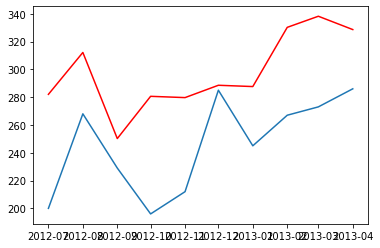

In [318]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [319]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -250.241
Date:                Tue, 17 May 2022   AIC                            514.483
Time:                        09:46:39   BIC                            527.581
Sample:                             0   HQIC                           519.433
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.6399      7.511     38.562      0.000     274.919     304.361
ar.L1          1.7072      0.265      6.439      0.000       1.188       2.227
ar.L2         -0.9816      0.436     -2.254      0.0

               0
count  48.000000
mean    1.503563
std    45.097008
min   -88.722597
25%   -33.272281
50%     3.478045
75%    27.468288
max    91.360122


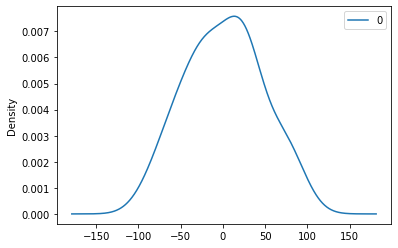

In [320]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

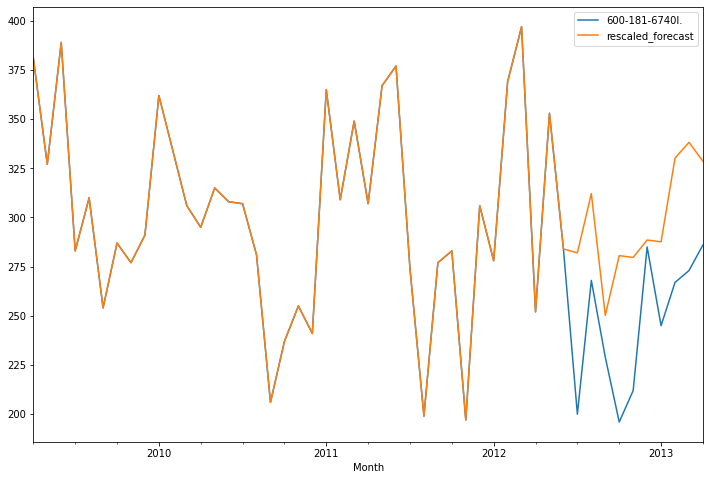

In [322]:
df_var7=pd.DataFrame(df[fc_ls1[i]])
#df_var7['diff1']=df_var7.iloc[:,0].diff(1)
#df_var7['Sdiff1']=df_var7.iloc[:,0].diff(1).diff(12)
df_var7['forecast']=predictions
df_var7['forecast2']=pd.concat([train,predictions])
#df_var7['rescale_ARIMA']=df_var7['diff1'].cumsum()
df_var7['rescaled_forecast']= df_var7['forecast2']#+df_var7[fc_ls1[i]].shift(1)
#df_var7['rescaled_forecast'].iloc[:13]=df_var7[fc_ls1[i]].iloc[:13]
df_var7.drop('forecast2',inplace=True,axis=1)
df_var7
df_var7[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [323]:
error_var7=error_var7.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var7['rescaled_forecast'][-6:-1],'ARIMA'))
error_var7.set_index('Errors',inplace= True)
# multi index columns
error_var7.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var7.columns)])
error_var7

600-181-6740I.                     \
                                         Holts_winter EWMA 0.46 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                           23.988    41.279   37.792   
Mean Squared Error:                           262.618   262.618  262.618   
Root Mean Squared Error:                       35.092    45.394   41.209   
Mean absolute percentage error:                10.369    15.209   14.008   
Scaled Mean absolute percentage error:          9.270    16.639   15.116   
Mean forecast error:                          284.962   224.081  229.313   
Normalised mean squared error:                  1.525     2.552    2.103   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     57.566   26.333   25.125   48.451  
Mean Squared Error:                     262.618  262.618  262.618  257.687  
Root Mean Squared Error:                 63.140   29.895   32.785   54.140  
Mean absolute percentage error:          21.168    9.862   10.482   19.624  
Scaled Mean absolute percentage error:   24.177   10.366    9.784   17.455  
Mean forecast error:                    203.768  241.716  268.306  305.817  
Normalised mean squared error:            4.937    1.107    1.331    3.545

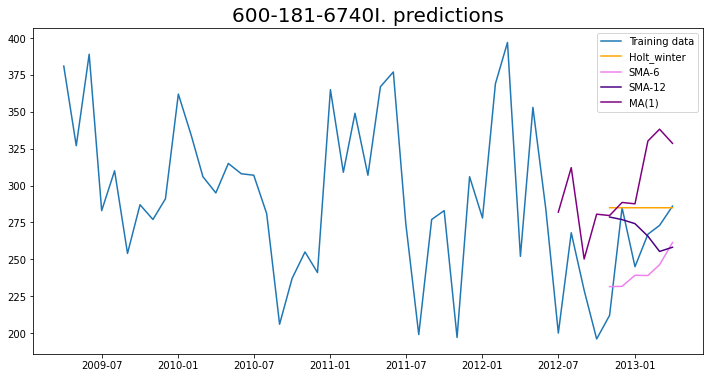

In [324]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var7['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [41]:
Summary_ls.append('SMA-6')

<div class="alert alert-block alert-danger" >
For the variable '600-181-6740I.' we could achieve lower RMSE with  SMA model, but they are flat prediction, these models will have lower life span,  we can conclude tht ARIMA accounts better for the pattern of the data and would be appropriate for the variable.

### Variable 8:  07063-51210I.

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



07063-51210I.


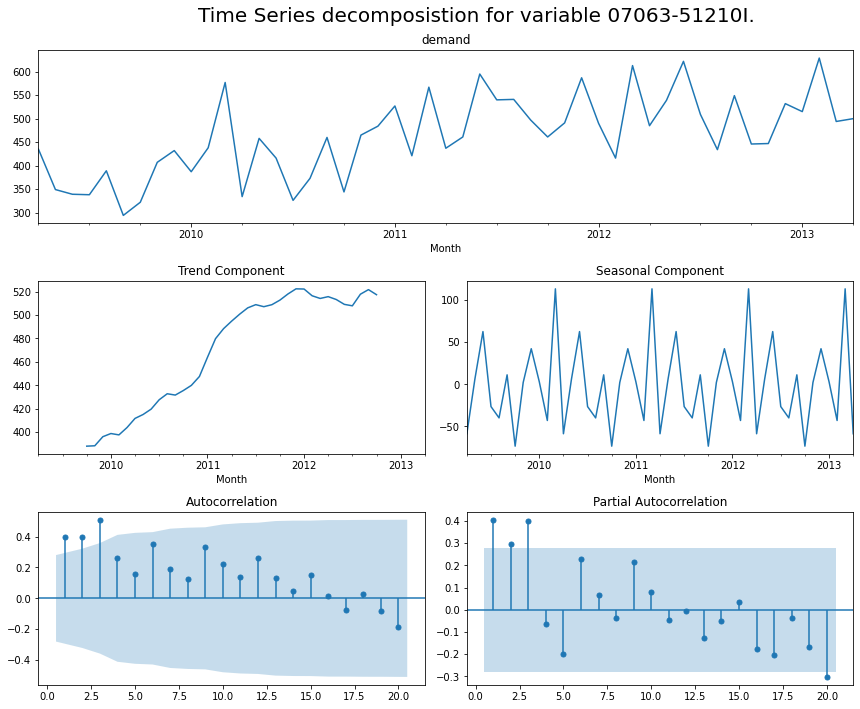

In [326]:
i=7
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the pattern observed above, an upward Trend seems to be present. Checking the other parameters to validate the same. Seasonality seems to be missing.
- ACF plot seems to be gradually decreasing but irregularities seem to be present. ACF and PACF have significant lag 1 values
- There is no significant vale for the 12th lag. Looks like seasonality does not exist.

In [327]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 07063-51210I. 


Statsmodel                  \
                                               ADF            KPSS   
ADF statistic                             -1.72278        0.474931   
conclusion              non-stationary (unit root)  not stationary   
p-value                                   0.419417       0.0473129   
should we difference?                         True            True   

                             PMD_model                  
                                   ADF            KPSS  
ADF statistic                      NaN             NaN  
conclusion              non-stationary  not stationary  
p-value                       0.308054            0.01  
should we difference?             True            True

In [328]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 07063-51210I.:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [329]:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1st round of differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1st round of differencing on 07063-51210I.?


Statsmodel               PMD_model            
                               ADF        KPSS         ADF        KPSS
ADF statistic             -4.36141    0.121427         NaN         NaN
conclusion              stationary  stationary  stationary  stationary
p-value                 0.00034715         0.1   0.0239966         0.1
should we difference?        False       False       False       False

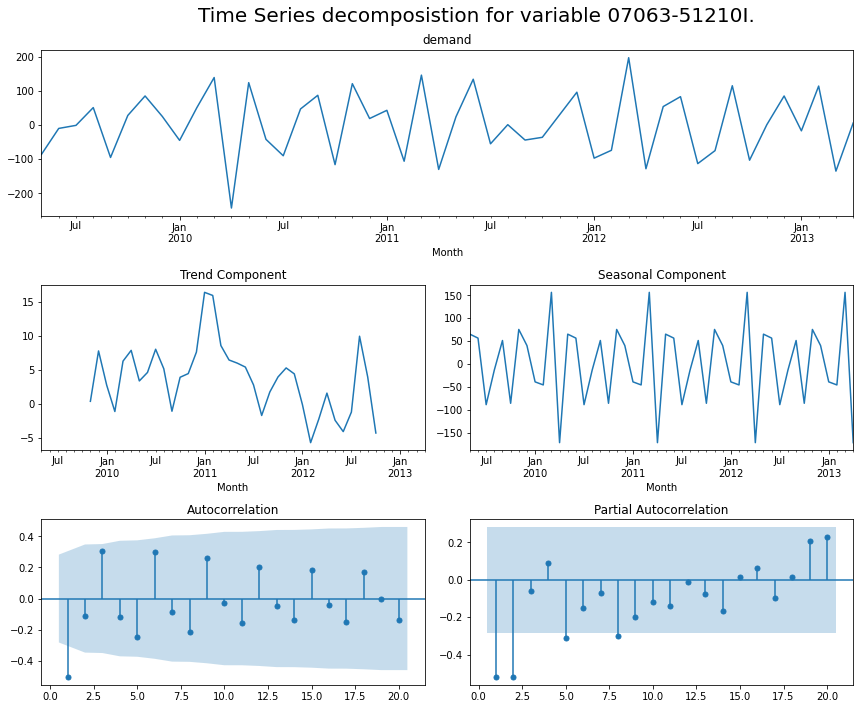

In [330]:
plot_stationarity(df_diff1,20)

The ACF now has few significant values after first differencing.

What about seasonality ?

In [331]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 07063-51210I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [332]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff1)


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df_diff1)


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 07063-51210I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '07063-51210I..'has no seasonality. The time series has only trend and thus is a Non stationary time series.**


### Forecasting for variable '07063-51210I.'

In [333]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [334]:
edf = df[fc_ls1[i]]
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 6 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #print(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:len(edf)-6].copy()
        test = edf[len(edf)-6:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model


In [335]:
best_RMSE,best_config

(55.52564222170151, [None, True, None, 12, True, True])

In [336]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

55.52564222170151 [None, True, None, 12, True, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        39.753
1                     Mean Squared Error:       522.452
2                Root Mean Squared Error:        55.526
3         Mean absolute percentage error:         7.436
4  Scaled Mean absolute percentage error:         7.519
5                    Mean forecast error:       516.759
6          Normalised mean squared error:         0.835
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [337]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var8=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))
error_var8

Errors  Holts_winter  EWMA 0.22  EWMA 0.4  \
0                    Mean Absolute Error:        39.753     39.167    44.140   
1                     Mean Squared Error:       522.452    522.452   522.452   
2                Root Mean Squared Error:        55.526     57.718    63.033   
3         Mean absolute percentage error:         7.436      7.134     7.935   
4  Scaled Mean absolute percentage error:         7.519      7.403     8.404   
5                    Mean forecast error:       516.759    503.506   489.540   
6          Normalised mean squared error:         0.835      0.903     1.077   

   EWMA 0.8    SMA-6   SMA-12  
0    61.999   45.528   39.792  
1   522.452  522.452  522.452  
2    79.347   55.401   51.855  
3    11.149    8.460    7.466  
4    12.133    8.688    7.537  
5   462.752  504.216  514.807  
6     1.706    0.832    0.729

In [276]:

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(2, 0, 0) RMSE=70.037


predicted=-85.82, expected=-113.00
predicted=59.68, expected=-75.00
predicted=129.26, expected=115.00
predicted=-42.27, expected=-103.00
predicted=25.61, expected=1.00
predicted=60.50, expected=85.00
predicted=-63.13, expected=-17.00
predicted=-26.85, expected=114.00
predicted=-70.42, expected=-135.00
predicted=56.47, expected=6.00
Test RMSE: 72.567


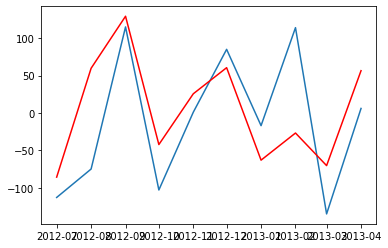

In [339]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [340]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -265.979
Date:                Tue, 17 May 2022   AIC                            539.958
Time:                        09:54:49   BIC                            547.358
Sample:                             0   HQIC                           542.743
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5557      4.463      0.797      0.426      -5.192      12.304
ar.L1         -0.7995      0.142     -5.639      0.000      -1.077      -0.522
ar.L2         -0.5239      0.131     -4.014      0.0

                0
count   47.000000
mean    -2.150700
std     70.170409
min   -130.121609
25%    -61.667993
50%    -12.425107
75%     50.103358
max    147.937862


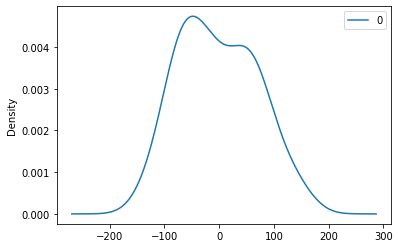

In [341]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

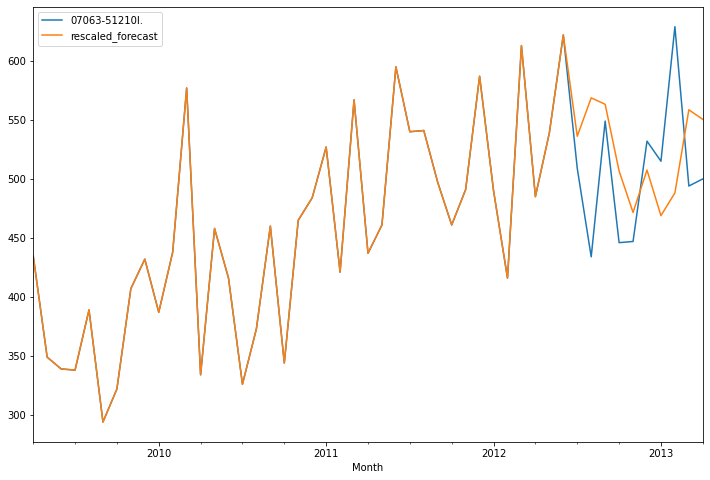

In [342]:
df_var8=pd.DataFrame(df[fc_ls1[i]])
df_var8['diff1']=df_var8.iloc[:,0].diff(1)
#df_var8['Sdiff1']=df_var8.iloc[:,0].diff(1).diff(12)
df_var8['forecast']=predictions
df_var8['forecast2']=pd.concat([train,predictions])
#df_var8['rescale_ARIMA']=df_var8['diff1'].cumsum()
df_var8['rescaled_forecast']= df_var8['forecast2']+df_var8[fc_ls1[i]].shift(1)
df_var8['rescaled_forecast'].iloc[:13]=df_var8[fc_ls1[i]].iloc[:13]
df_var8.drop('forecast2',inplace=True,axis=1)
df_var8
df_var8[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [343]:
error_var8=error_var8.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var8['rescaled_forecast'][-6:-1],'ARIMA'))
error_var8.set_index('Errors',inplace= True)
# multi index columns
error_var8.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var8.columns)])
error_var8

07063-51210I.                     \
                                        Holts_winter EWMA 0.22 EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                          39.753    39.167   44.140   
Mean Squared Error:                          522.452   522.452  522.452   
Root Mean Squared Error:                      55.526    57.718   63.033   
Mean absolute percentage error:                7.436     7.134    7.935   
Scaled Mean absolute percentage error:         7.519     7.403    8.404   
Mean forecast error:                         516.759   503.506  489.540   
Normalised mean squared error:                 0.835     0.903    1.077   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     61.999   45.528   39.792   60.134  
Mean Squared Error:                     522.452  522.452  522.452  526.827  
Root Mean Squared Error:                 79.347   55.401   51.855   73.950  
Mean absolute percentage error:          11.149    8.460    7.466   10.907  
Scaled Mean absolute percentage error:   12.133    8.688    7.537   11.387  
Mean forecast error:                    462.752  504.216  514.807  500.021  
Normalised mean squared error:            1.706    0.832    0.729    1.215

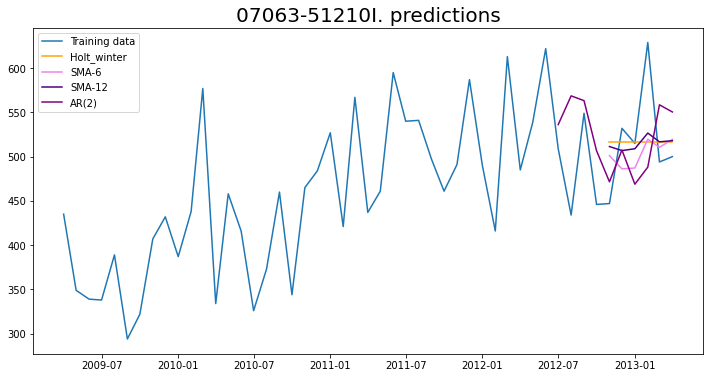

In [345]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var8['rescaled_forecast'][-len(predictions):],color='purple',label='AR(2)')
plt.legend();

In [42]:
Summary_ls.append('AR(2)')

<div class="alert alert-block alert-danger" >
For the variable '07063-51210I.' we could suggest implementing AR(2) model

### Variable 9:  600-319-4540I..

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



600-319-4540I.


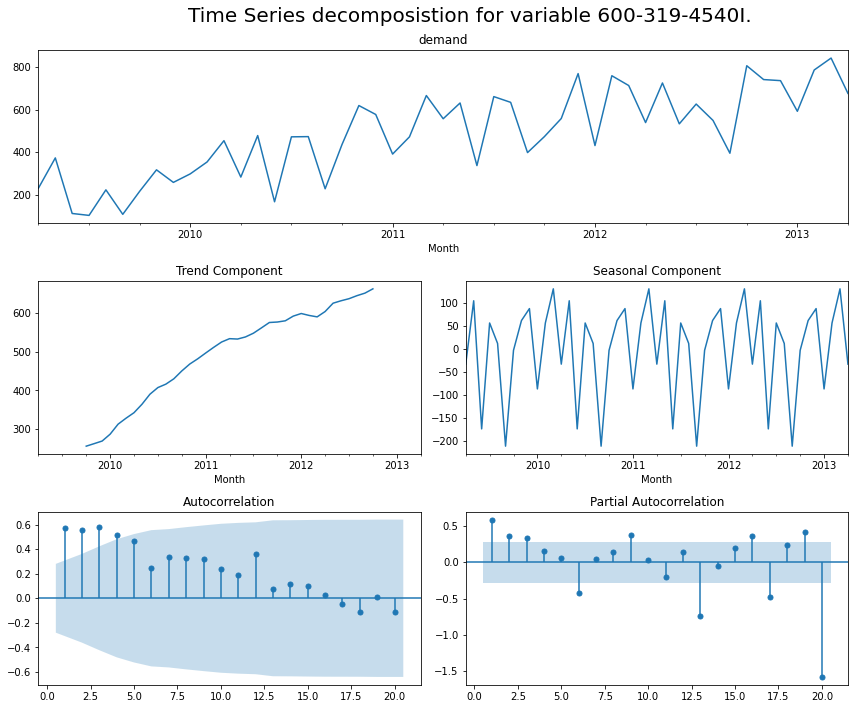

In [347]:
i=8
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Visually, it looks like there is an upward trend.
- There are significant lags at lag 1 for ACF and PACF and values at ACF are decaying slowly from lag 1. 
- There are no significant values at lag s in any of the graph.

In [359]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 600-319-4540I. 


Statsmodel                  \
                                               ADF            KPSS   
ADF statistic                             -2.65694         0.52462   
conclusion              non-stationary (unit root)  not stationary   
p-value                                  0.0817899       0.0361216   
should we difference?                         True            True   

                             PMD_model                  
                                   ADF            KPSS  
ADF statistic                      NaN             NaN  
conclusion              non-stationary  not stationary  
p-value                       0.252408            0.01  
should we difference?             True            True

In [360]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 600-319-4540I.:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [361]:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1st round of differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1st round of differencing on 600-319-4540I.?


Statsmodel               PMD_model            
                               ADF        KPSS         ADF        KPSS
ADF statistic             -3.92771    0.113541         NaN         NaN
conclusion              stationary  stationary  stationary  stationary
p-value                 0.00184015         0.1        0.01         0.1
should we difference?        False       False       False       False

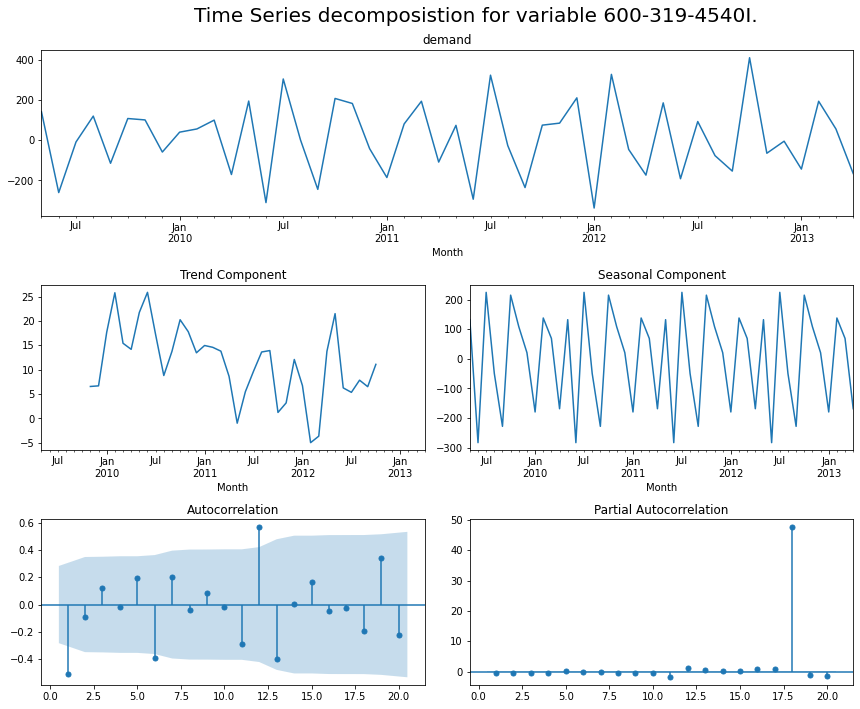

In [362]:
plot_stationarity(df_diff1,20)

ACF has fewer significant values after first differencing is applied.

What about seasonality ?

In [363]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 600-319-4540I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '600-319-4540I'has no seasonality after differencing and the series has only trend and no seasonality. We will optimize the ARIMA model to check if further differencing is required**


### Forecasting for variable '600-319-4540I.'

In [364]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [365]:
edf = df[fc_ls1[i]]
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 6 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #rint(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:len(edf)-6].copy()
        test = edf[len(edf)-6:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model


In [366]:
best_RMSE,best_config

(22.765068391005585, ['add', True, 'add', 12, False, False])

In [367]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

22.765068391005585 ['add', True, 'add', 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        15.442
1                     Mean Squared Error:       733.141
2                Root Mean Squared Error:        22.765
3         Mean absolute percentage error:         2.093
4  Scaled Mean absolute percentage error:         2.059
5                    Mean forecast error:       737.955
6          Normalised mean squared error:         0.069
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [368]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var9=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))
error_var9

Errors  Holts_winter  EWMA 0.25  EWMA 0.4  \
0                    Mean Absolute Error:        15.442    124.002   112.065   
1                     Mean Squared Error:       733.141    733.141   733.141   
2                Root Mean Squared Error:        22.765    141.861   127.414   
3         Mean absolute percentage error:         2.093     16.155    14.675   
4  Scaled Mean absolute percentage error:         2.059     17.957    16.058   
5                    Mean forecast error:       737.955    611.247   629.152   
6          Normalised mean squared error:         0.069      2.663     2.148   

   EWMA 0.8    SMA-6   SMA-12  
0    62.674   87.556  100.347  
1   733.141  733.141  733.141  
2    79.378   92.780  115.745  
3     8.988   11.808   13.181  
4     8.730   12.431   14.259  
5   730.479  675.648  645.563  
6     0.834    1.139    1.773

In [369]:
# grid search ARIMA parameters for time series
series = df_diff1[:-6]
# evaluate parameters
p_values = range(0,15)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(7, 1, 2) RMSE=137.636


predicted=218.22, expected=93.00
predicted=-9.64, expected=-77.00
predicted=28.19, expected=-154.00
predicted=259.45, expected=411.00
predicted=-288.92, expected=-65.00
predicted=-147.78, expected=-5.00
predicted=30.42, expected=-144.00
predicted=184.21, expected=194.00
predicted=41.90, expected=56.00
predicted=-172.00, expected=-166.00
Test RMSE: 133.287


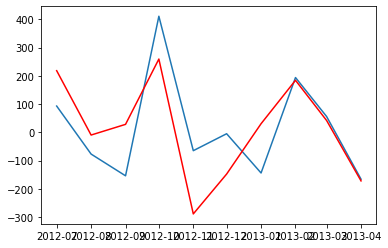

In [370]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [371]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -289.393
Date:                Tue, 17 May 2022   AIC                            598.786
Time:                        10:16:00   BIC                            617.072
Sample:                             0   HQIC                           605.636
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8991     24.430     -0.078      0.938     -49.781      45.983
ar.L2         -1.6919     21.960     -0.077      0.939     -44.733      41.349
ar.L3         -1.2062     19.369     -0.062      0.9

                0
count   47.000000
mean     9.463255
std    137.992911
min   -395.056997
25%    -71.981585
50%     12.867172
75%    112.761494
max    263.845953


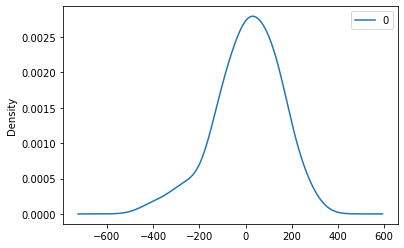

In [372]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

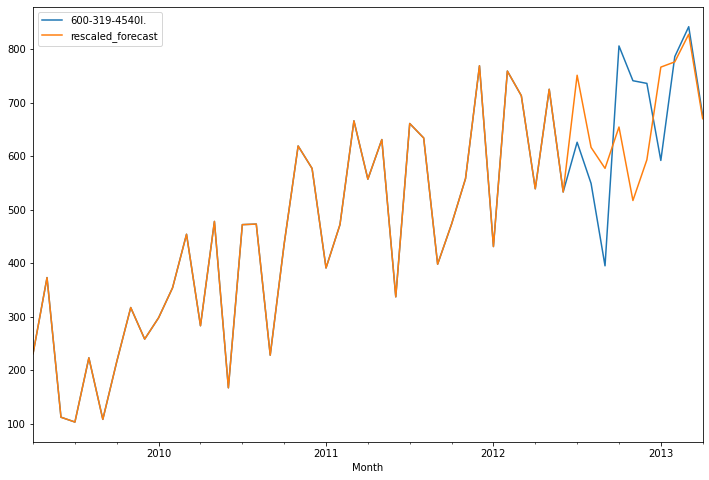

In [373]:
df_var9=pd.DataFrame(df[fc_ls1[i]])
df_var9['diff1']=df_var9.iloc[:,0].diff(1)
#df_var9['Sdiff1']=df_var9.iloc[:,0].diff(1).diff(12)
df_var9['forecast']=predictions
df_var9['forecast2']=pd.concat([train,predictions])
#df_var9['rescale_ARIMA']=df_var9['diff1'].cumsum()
df_var9['rescaled_forecast']= df_var9['forecast2']+df_var9[fc_ls1[i]].shift(1)
df_var9['rescaled_forecast'].iloc[:13]=df_var9[fc_ls1[i]].iloc[:13]
df_var9.drop('forecast2',inplace=True,axis=1)
df_var9
df_var9[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [374]:
error_var9=error_var9.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var9['rescaled_forecast'][-6:-1],'ARIMA'))
error_var9.set_index('Errors',inplace= True)
# multi index columns
error_var9.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var9.columns)])
error_var9

600-319-4540I.                     \
                                         Holts_winter EWMA 0.25 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                           15.442   124.002  112.065   
Mean Squared Error:                           733.141   733.141  733.141   
Root Mean Squared Error:                       22.765   141.861  127.414   
Mean absolute percentage error:                 2.093    16.155   14.675   
Scaled Mean absolute percentage error:          2.059    17.957   16.058   
Mean forecast error:                          737.955   611.247  629.152   
Normalised mean squared error:                  0.069     2.663    2.148   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     62.674   87.556  100.347  113.003  
Mean Squared Error:                     733.141  733.141  733.141  744.043  
Root Mean Squared Error:                 79.378   92.780  115.745  142.298  
Mean absolute percentage error:           8.988   11.808   13.181   16.400  
Scaled Mean absolute percentage error:    8.730   12.431   14.259   17.141  
Mean forecast error:                    730.479  675.648  645.563  706.344  
Normalised mean squared error:            0.834    1.139    1.773    2.352

In [43]:
Summary_ls.append('HOLTS-WINTER')

<div class="alert alert-block alert-danger" >
For the variable '600-319-4540I.' we could achieve lower RMSE with  Holts-winter model 

### Variable 10: '6735-51-5143I'. 

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



6735-51-5143I


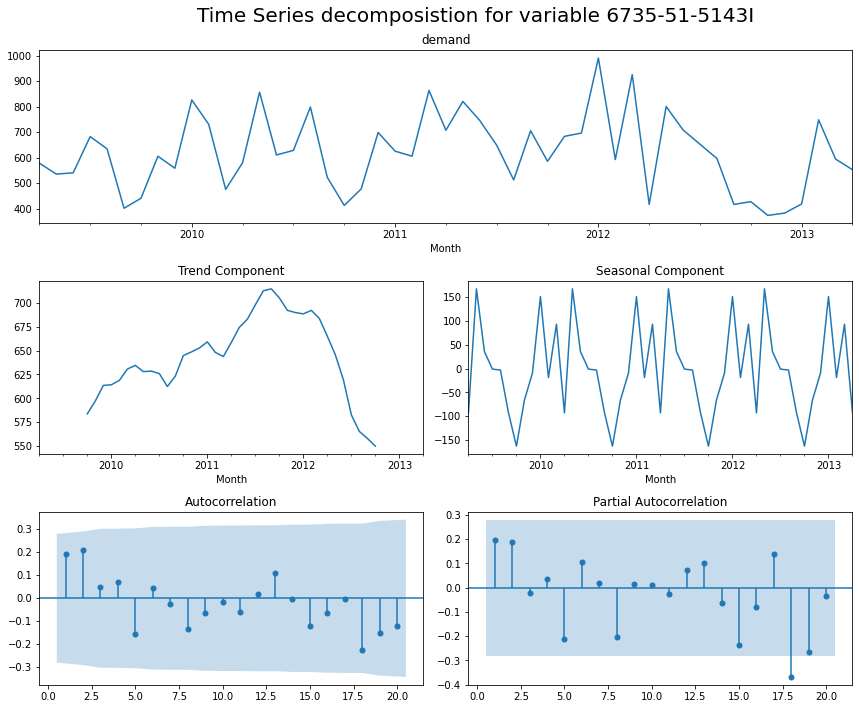

In [45]:
i=9
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Visually, it looks like there is no trend or seasonality.
- Since there are no lags outside the significant lines and no error terms , we can say the variable doesn’t have trend or seasonality and the model is stationary without any error terms.

In [46]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 6735-51-5143I 


Statsmodel                   PMD_model            
                               ADF        KPSS             ADF        KPSS
ADF statistic             -3.52004    0.137698             NaN         NaN
conclusion              stationary  stationary  non-stationary  stationary
p-value                 0.00748702         0.1         0.33123         0.1
should we difference?        False       False            True       False

onnly PMD statistics is not significant, from the ACF and PACF plot, since there are no lag terms outside the significance boundary , we can say the series doesn’t have trend or seasonality and the model is stationary without any error terms. What about seasonality ?

In [47]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 6735-51-5143I -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '6735-51-5143I'has no seasonality.**


### Forecasting for variable '6735-51-5143I'

In [48]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [49]:
edf = df[fc_ls1[i]]
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 6 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #rint(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:len(edf)-6].copy()
        test = edf[len(edf)-6:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model


In [50]:
best_RMSE,best_config

(148.87350562779412, ['mul', True, None, 12, False, False])

In [51]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

148.87350562779412 ['mul', True, None, 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:       136.438
1                     Mean Squared Error:       528.649
2                Root Mean Squared Error:       148.874
3         Mean absolute percentage error:        27.161
4  Scaled Mean absolute percentage error:        26.652
5                    Mean forecast error:       496.206
6          Normalised mean squared error:         1.016
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [52]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var10=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))


In [53]:
# grid search ARIMA parameters for time series
series = df[fc_ls1[i]][:-6]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 0) RMSE=168.718


predicted=646.41, expected=652.00
predicted=646.55, expected=596.00
predicted=645.32, expected=416.00
predicted=639.86, expected=427.00
predicted=634.91, expected=373.00
predicted=628.95, expected=382.00
predicted=623.47, expected=418.00
predicted=619.00, expected=748.00
predicted=621.74, expected=594.00
predicted=621.17, expected=552.00
Test RMSE: 171.603


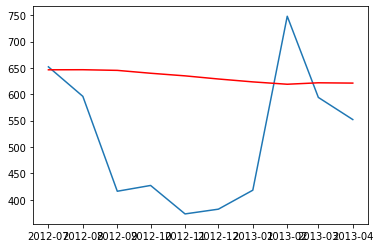

In [54]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [55]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                          ARIMA   Log Likelihood                -308.385
Date:                Tue, 17 May 2022   AIC                            620.770
Time:                        15:11:32   BIC                            624.512
Sample:                             0   HQIC                           622.184
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        621.1667     22.072     28.143      0.000     577.906     664.427
sigma2      2.226e+04   5339.989      4.168      0.000    1.18e+04    3.27e+04
Ljung-Box (L1) (Q):                   1.89   Jarque-

                0
count   48.000000
mean     0.000007
std    150.847723
min   -248.166659
25%   -101.666659
50%    -13.666659
75%     86.083341
max    368.833341


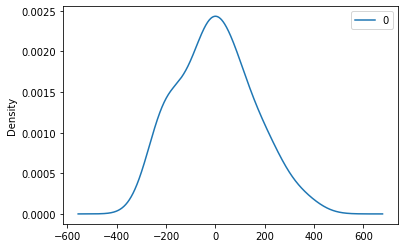

In [56]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

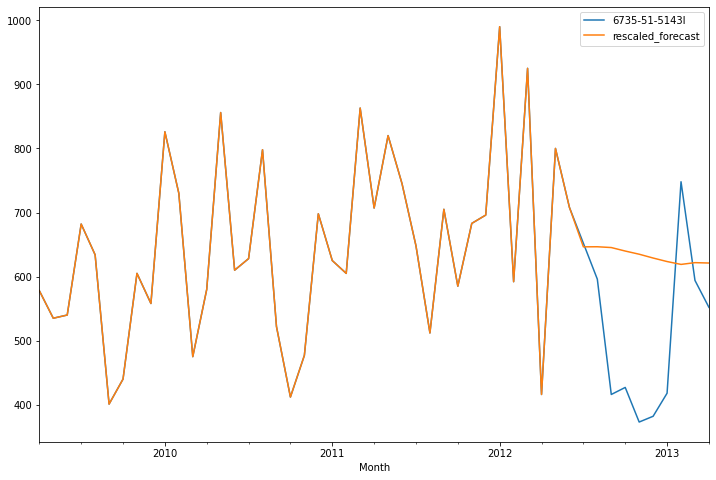

In [59]:
df_var10=pd.DataFrame(df[fc_ls1[i]])
#df_var10['diff1']=df_var10.iloc[:,0]#.diff(1)
#df_var10['Sdiff1']=df_var10.iloc[:,0].diff(1).diff(12)
df_var10['forecast']=predictions
df_var10['forecast2']=pd.concat([train,predictions])
#df_var10['rescale_ARIMA']=df_var10['diff1'].cumsum()
df_var10['rescaled_forecast']= df_var10['forecast2']#+df_var10[fc_ls1[i]].shift(1)
df_var10['rescaled_forecast'].iloc[:13]=df_var10[fc_ls1[i]].iloc[:13]
df_var10.drop('forecast2',inplace=True,axis=1)
df_var10
df_var10[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [60]:
error_var10=error_var10.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var10['rescaled_forecast'][-6:-1],'ARIMA'))
error_var10.set_index('Errors',inplace= True)
# multi index columns
error_var10.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var10.columns)])
error_var10

6735-51-5143I                     \
                                        Holts_winter EWMA 0.07 EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                         136.438   162.755  120.167   
Mean Squared Error:                          528.649   528.649  528.649   
Root Mean Squared Error:                     148.874   184.346  134.993   
Mean absolute percentage error:               27.161    37.881   24.041   
Scaled Mean absolute percentage error:        26.652    30.181   23.422   
Mean forecast error:                         496.206   636.883  504.518   
Normalised mean squared error:                 1.016     1.558    0.835   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                    120.167  116.194  142.389  174.215  
Mean Squared Error:                     528.649  528.649  528.649  523.854  
Root Mean Squared Error:                156.076  146.078  168.877  194.530  
Mean absolute percentage error:          20.612   22.219   32.433   41.187  
Scaled Mean absolute percentage error:   23.296   22.417   26.993   32.744  
Mean forecast error:                    432.548  484.412  579.037  625.641  
Normalised mean squared error:            1.117    0.978    1.307    1.414

In [64]:
Summary_ls.append('EWMA_0.8')

<div class="alert alert-block alert-danger" >
EWMA-0.8 is achieving a MAPE of 20%. The spare '6735-51-5143I' can be forecasted using EWMA_0.8

### Variable 11: '07000-B2011I.' 

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



07000-B2011I.


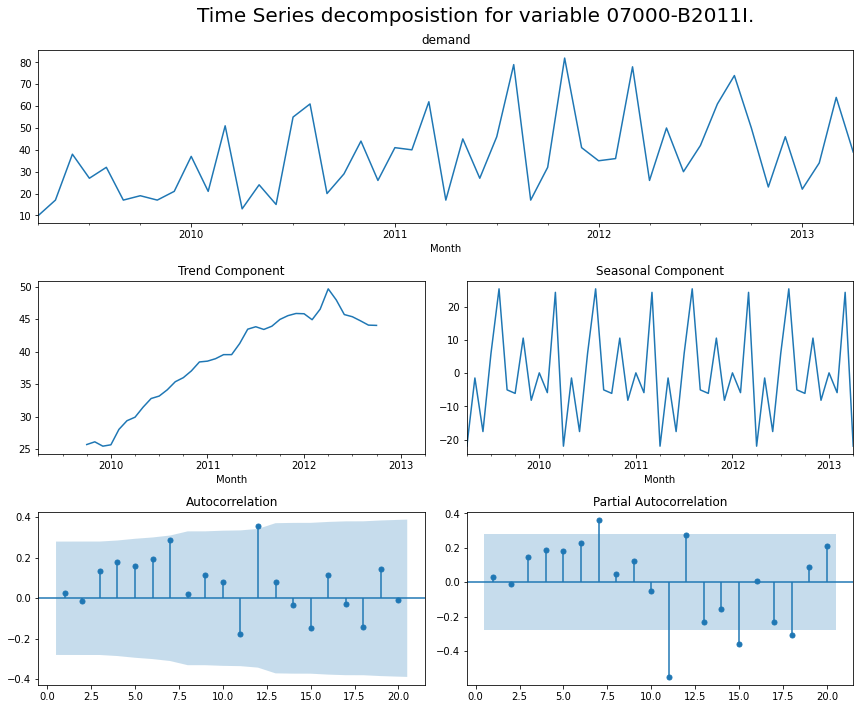

In [65]:
i=10
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Since, there are no lags at lag 1 and there is no decaying pattern, we can conclude that the model is stationary and there is no trend and seasonality. 
- From the above plot we can see that p=11 and we will check for different model s with different p values.

In [66]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])['Statsmodel']

Stationarity test results for original data on 07000-B2011I. 


ADF        KPSS
ADF statistic              -6.75673    0.455197
conclusion               stationary  stationary
p-value                 2.85927e-09   0.0533634
should we difference?         False       False

What about seasonality ?

In [67]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 07000-B2011I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '07000-B2011I.'has no seasonality after differencing and before.**


### Forecasting for variable '07000-B2011I.'

In [223]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [68]:
edf = df[fc_ls1[i]]
ts = edf.iloc[:len(edf)-6].copy()
ts_v = edf[len(edf)-6:].copy()
ind = edf.index[-6:]  # this will select last 6 months' indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    #print(j)
    try:
        cg = cfg_list[j]
        #rint(cg)
        t,d,s,p,b,r = cg
        train = edf.iloc[:len(edf)-6].copy()
        test = edf[len(edf)-6:].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        #print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        print('something is wrong')

Holt's Winter Model


In [69]:
best_RMSE,best_config

(16.662034839684946, [None, True, None, 12, True, False])

In [70]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

16.662034839684946 [None, True, None, 12, True, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        14.296
1                     Mean Squared Error:        40.624
2                Root Mean Squared Error:        16.662
3         Mean absolute percentage error:        49.519
4  Scaled Mean absolute percentage error:        36.676
5                    Mean forecast error:        46.443
6          Normalised mean squared error:         1.121
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [71]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var11=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))


In [72]:
# grid search ARIMA parameters for time series
series = df[fc_ls1[i]]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10,11,12]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 1, 1) RMSE=17.538


predicted=42.48, expected=42.00
predicted=42.41, expected=61.00
predicted=44.92, expected=74.00
predicted=49.30, expected=50.00
predicted=49.40, expected=23.00
predicted=45.44, expected=46.00
predicted=45.51, expected=22.00
predicted=42.50, expected=34.00
predicted=41.42, expected=64.00
predicted=44.24, expected=39.00
Test RMSE: 17.469


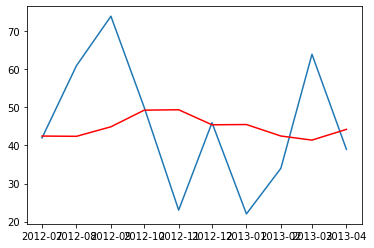

In [84]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [85]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -203.848
Date:                Tue, 17 May 2022   AIC                            411.696
Time:                        15:27:00   BIC                            415.396
Sample:                             0   HQIC                           413.089
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8770      0.086    -10.207      0.000      -1.045      -0.709
sigma2       332.0830     76.273      4.354      0.000     182.590     481.576
Ljung-Box (L1) (Q):                   1.85   Jarque-

               0
count  48.000000
mean    4.447120
std    17.851842
min   -25.433214
25%    -7.893899
50%     0.177196
75%    14.074031
max    44.414497


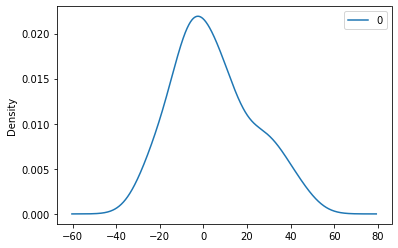

In [86]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

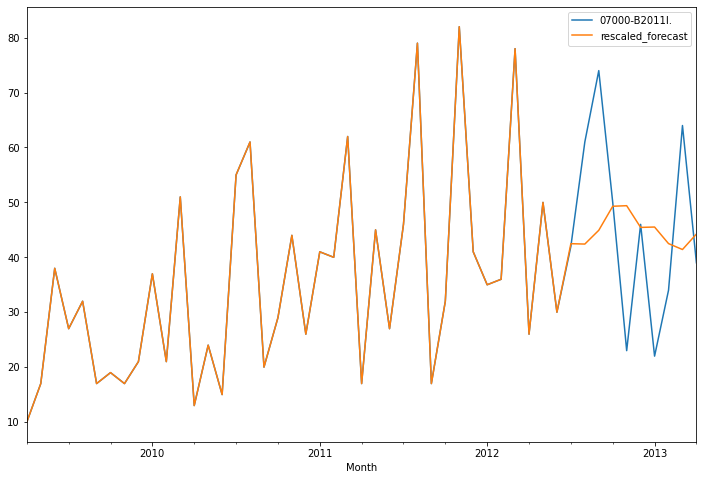

In [87]:
df_var11=pd.DataFrame(df[fc_ls1[i]])
#df_var11['diff1']=df_var11.iloc[:,0]#.diff(1)
#df_var11['Sdiff1']=df_var11.iloc[:,0].diff(1).diff(12)
df_var11['forecast']=predictions
df_var11['forecast2']=pd.concat([train,predictions])
#df_var11['rescale_ARIMA']=df_var11['diff1'].cumsum()
df_var11['rescaled_forecast']= df_var11['forecast2']#+df_var11[fc_ls1[i]].shift(1)
df_var11['rescaled_forecast'].iloc[:13]=df_var11[fc_ls1[i]].iloc[:13]
df_var11.drop('forecast2',inplace=True,axis=1)
df_var11
df_var11[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [88]:
error_var11=error_var11.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var11['rescaled_forecast'][-6:-1],'ARIMA'))
error_var11.set_index('Errors',inplace= True)
# multi index columns
error_var11.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var11.columns)])
error_var11

07000-B2011I.                     \
                                        Holts_winter EWMA 0.13 EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                          14.296    15.893   20.215   
Mean Squared Error:                           40.624    40.624   40.624   
Root Mean Squared Error:                      16.662    17.995   22.504   
Mean absolute percentage error:               49.519    55.513   71.732   
Scaled Mean absolute percentage error:        36.676    39.800   47.338   
Mean forecast error:                          46.443    48.839   55.323   
Normalised mean squared error:                 1.121     1.308    2.045   

                                                                         
                                       EWMA 0.8   SMA-6  SMA-12   ARIMA  
Errors                                                                   
Mean Absolute Error:                     19.409  13.944  13.694  16.309  
Mean Squared Error:                      40.624  40.624  40.624  40.941  
Root Mean Squared Error:                 21.587  17.265  16.293  19.143  
Mean absolute percentage error:          68.709  46.937  46.586  56.629  
Scaled Mean absolute percentage error:   46.025  35.756  35.470  41.770  
Mean forecast error:                     54.114  43.743  44.840  44.941  
Normalised mean squared error:            1.882   1.204   1.072   1.185

In [89]:
Summary_ls.append('SMA-12')

<div class="alert alert-block alert-danger" >
ARIMA is achieving a RMSE of 21, while HW is getting 16.6, for the vaiable '07000-B2011I.' we can opt for Holts- winter for this variable

In [90]:
Summary['Best_model']=Summary_ls

In [91]:
Summary

Variable       Best_model
0      205-70-N1190            MA(1)
1   PC_198_27_42263            SMA-6
2   PC_203_32_51461            SMA-2
3   PC_600_863_4210  AR(8) and MA(2)
4   PC_6735_61_3410          ARMA(8)
5         D30141135  AR(6) and MA(2)
6    600-181-6740I.            SMA-6
7     07063-51210I.            AR(2)
8    600-319-4540I.     HOLTS-WINTER
9     6735-51-5143I         EWMA_0.8
10    07000-B2011I.           SMA-12

The best models for different variables are as above. 

### Q 3.3  Which forecasting techniques should L&T use to forecast different spare items?

<div class="alert alert-block alert-danger" >
We recommend a strategic solution for 20,000 forecasting models to be built. It is to rationalize the demand for each spare part quantitatively and qualitatively.It is recommended to be done by identifying the high variance  variables i.e. the spare parts which are causing the highest variability in supply chain and in the revenue. Once, these have been identified the forecasting techniques discussed in the methodology can be executed in a short time